In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'scale',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_scale_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 828)
(4629816, 8)
validation
(621056, 828)
(621056, 8)
test
(624904, 828)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 13:10 - loss: 2.3030 - STD: 0.0566 - MAE: 0.2203

  4/463 [..............................] - ETA: 10s - loss: 2.1410 - STD: 0.0402 - MAE: 0.2182  

  7/463 [..............................] - ETA: 10s - loss: 2.1251 - STD: 0.0559 - MAE: 0.2165

 10/463 [..............................] - ETA: 10s - loss: 2.1061 - STD: 0.0533 - MAE: 0.2163

 13/463 [..............................] - ETA: 10s - loss: 2.0942 - STD: 0.0463 - MAE: 0.2165

 16/463 [>.............................] - ETA: 10s - loss: 2.0881 - STD: 0.0415 - MAE: 0.2167

 19/463 [>.............................] - ETA: 10s - loss: 2.0821 - STD: 0.0386 - MAE: 0.2168

 22/463 [>.............................] - ETA: 10s - loss: 2.0763 - STD: 0.0380 - MAE: 0.2167

 25/463 [>.............................] - ETA: 10s - loss: 2.0708 - STD: 0.0388 - MAE: 0.2165

 28/463 [>.............................] - ETA: 10s - loss: 2.0651 - STD: 0.0392 - MAE: 0.2164

 31/463 [=>............................] - ETA: 10s - loss: 2.0575 - STD: 0.0388 - MAE: 0.2162

 34/463 [=>............................] - ETA: 10s - loss: 2.0477 - STD: 0.0388 - MAE: 0.2159

 37/463 [=>............................] - ETA: 9s - loss: 2.0364 - STD: 0.0396 - MAE: 0.2155 

 40/463 [=>............................] - ETA: 9s - loss: 2.0230 - STD: 0.0412 - MAE: 0.2150

 43/463 [=>............................] - ETA: 9s - loss: 2.0094 - STD: 0.0436 - MAE: 0.2144

 46/463 [=>............................] - ETA: 9s - loss: 1.9969 - STD: 0.0462 - MAE: 0.2137

 49/463 [==>...........................] - ETA: 9s - loss: 1.9849 - STD: 0.0487 - MAE: 0.2131

 52/463 [==>...........................] - ETA: 9s - loss: 1.9730 - STD: 0.0508 - MAE: 0.2125

 55/463 [==>...........................] - ETA: 9s - loss: 1.9607 - STD: 0.0527 - MAE: 0.2119

 58/463 [==>...........................] - ETA: 9s - loss: 1.9476 - STD: 0.0545 - MAE: 0.2113

 61/463 [==>...........................] - ETA: 9s - loss: 1.9341 - STD: 0.0563 - MAE: 0.2107

 64/463 [===>..........................] - ETA: 9s - loss: 1.9203 - STD: 0.0580 - MAE: 0.2100

 67/463 [===>..........................] - ETA: 9s - loss: 1.9064 - STD: 0.0599 - MAE: 0.2093

 70/463 [===>..........................] - ETA: 9s - loss: 1.8923 - STD: 0.0618 - MAE: 0.2086

 73/463 [===>..........................] - ETA: 9s - loss: 1.8782 - STD: 0.0637 - MAE: 0.2078

 76/463 [===>..........................] - ETA: 9s - loss: 1.8646 - STD: 0.0657 - MAE: 0.2071

 79/463 [====>.........................] - ETA: 8s - loss: 1.8510 - STD: 0.0678 - MAE: 0.2062

 82/463 [====>.........................] - ETA: 8s - loss: 1.8378 - STD: 0.0698 - MAE: 0.2054

 85/463 [====>.........................] - ETA: 8s - loss: 1.8247 - STD: 0.0719 - MAE: 0.2046

 88/463 [====>.........................] - ETA: 8s - loss: 1.8119 - STD: 0.0739 - MAE: 0.2038

 91/463 [====>.........................] - ETA: 8s - loss: 1.7996 - STD: 0.0758 - MAE: 0.2030

 94/463 [=====>........................] - ETA: 8s - loss: 1.7877 - STD: 0.0778 - MAE: 0.2022

 97/463 [=====>........................] - ETA: 8s - loss: 1.7763 - STD: 0.0798 - MAE: 0.2014

100/463 [=====>........................] - ETA: 8s - loss: 1.7649 - STD: 0.0817 - MAE: 0.2006

103/463 [=====>........................] - ETA: 8s - loss: 1.7542 - STD: 0.0835 - MAE: 0.1999

106/463 [=====>........................] - ETA: 8s - loss: 1.7436 - STD: 0.0853 - MAE: 0.1991

109/463 [======>.......................] - ETA: 8s - loss: 1.7335 - STD: 0.0870 - MAE: 0.1984

112/463 [======>.......................] - ETA: 8s - loss: 1.7236 - STD: 0.0887 - MAE: 0.1977

115/463 [======>.......................] - ETA: 8s - loss: 1.7140 - STD: 0.0902 - MAE: 0.1970

118/463 [======>.......................] - ETA: 8s - loss: 1.7045 - STD: 0.0917 - MAE: 0.1963

121/463 [======>.......................] - ETA: 7s - loss: 1.6955 - STD: 0.0932 - MAE: 0.1957

124/463 [=======>......................] - ETA: 7s - loss: 1.6866 - STD: 0.0946 - MAE: 0.1951

127/463 [=======>......................] - ETA: 7s - loss: 1.6781 - STD: 0.0960 - MAE: 0.1944

130/463 [=======>......................] - ETA: 7s - loss: 1.6700 - STD: 0.0973 - MAE: 0.1938

133/463 [=======>......................] - ETA: 7s - loss: 1.6618 - STD: 0.0987 - MAE: 0.1932

136/463 [=======>......................] - ETA: 7s - loss: 1.6540 - STD: 0.1000 - MAE: 0.1926

139/463 [========>.....................] - ETA: 7s - loss: 1.6463 - STD: 0.1012 - MAE: 0.1920

142/463 [========>.....................] - ETA: 7s - loss: 1.6390 - STD: 0.1024 - MAE: 0.1915

145/463 [========>.....................] - ETA: 7s - loss: 1.6319 - STD: 0.1036 - MAE: 0.1909

148/463 [========>.....................] - ETA: 7s - loss: 1.6249 - STD: 0.1048 - MAE: 0.1904

151/463 [========>.....................] - ETA: 7s - loss: 1.6182 - STD: 0.1059 - MAE: 0.1898

154/463 [========>.....................] - ETA: 7s - loss: 1.6116 - STD: 0.1070 - MAE: 0.1893

157/463 [=========>....................] - ETA: 7s - loss: 1.6051 - STD: 0.1081 - MAE: 0.1888

160/463 [=========>....................] - ETA: 7s - loss: 1.5989 - STD: 0.1092 - MAE: 0.1883

163/463 [=========>....................] - ETA: 6s - loss: 1.5927 - STD: 0.1102 - MAE: 0.1878

166/463 [=========>....................] - ETA: 6s - loss: 1.5867 - STD: 0.1112 - MAE: 0.1873

169/463 [=========>....................] - ETA: 6s - loss: 1.5808 - STD: 0.1122 - MAE: 0.1869

172/463 [==========>...................] - ETA: 6s - loss: 1.5752 - STD: 0.1132 - MAE: 0.1864

175/463 [==========>...................] - ETA: 6s - loss: 1.5697 - STD: 0.1141 - MAE: 0.1860

178/463 [==========>...................] - ETA: 6s - loss: 1.5644 - STD: 0.1150 - MAE: 0.1855

181/463 [==========>...................] - ETA: 6s - loss: 1.5590 - STD: 0.1159 - MAE: 0.1851

184/463 [==========>...................] - ETA: 6s - loss: 1.5539 - STD: 0.1167 - MAE: 0.1847

187/463 [===========>..................] - ETA: 6s - loss: 1.5488 - STD: 0.1176 - MAE: 0.1843

190/463 [===========>..................] - ETA: 6s - loss: 1.5439 - STD: 0.1184 - MAE: 0.1839

193/463 [===========>..................] - ETA: 6s - loss: 1.5392 - STD: 0.1192 - MAE: 0.1835

196/463 [===========>..................] - ETA: 6s - loss: 1.5344 - STD: 0.1200 - MAE: 0.1831

199/463 [===========>..................] - ETA: 6s - loss: 1.5297 - STD: 0.1208 - MAE: 0.1827

202/463 [============>.................] - ETA: 6s - loss: 1.5252 - STD: 0.1215 - MAE: 0.1823

205/463 [============>.................] - ETA: 6s - loss: 1.5208 - STD: 0.1223 - MAE: 0.1819

208/463 [============>.................] - ETA: 5s - loss: 1.5166 - STD: 0.1230 - MAE: 0.1816

211/463 [============>.................] - ETA: 5s - loss: 1.5123 - STD: 0.1237 - MAE: 0.1812

214/463 [============>.................] - ETA: 5s - loss: 1.5081 - STD: 0.1244 - MAE: 0.1809

217/463 [=============>................] - ETA: 5s - loss: 1.5041 - STD: 0.1250 - MAE: 0.1806

220/463 [=============>................] - ETA: 5s - loss: 1.5000 - STD: 0.1257 - MAE: 0.1802

223/463 [=============>................] - ETA: 5s - loss: 1.4961 - STD: 0.1264 - MAE: 0.1799

226/463 [=============>................] - ETA: 5s - loss: 1.4921 - STD: 0.1270 - MAE: 0.1796

229/463 [=============>................] - ETA: 5s - loss: 1.4883 - STD: 0.1276 - MAE: 0.1792

232/463 [==============>...............] - ETA: 5s - loss: 1.4846 - STD: 0.1283 - MAE: 0.1789

235/463 [==============>...............] - ETA: 5s - loss: 1.4809 - STD: 0.1289 - MAE: 0.1786

238/463 [==============>...............] - ETA: 5s - loss: 1.4773 - STD: 0.1295 - MAE: 0.1783

241/463 [==============>...............] - ETA: 5s - loss: 1.4739 - STD: 0.1301 - MAE: 0.1780

244/463 [==============>...............] - ETA: 5s - loss: 1.4705 - STD: 0.1306 - MAE: 0.1777

247/463 [===============>..............] - ETA: 5s - loss: 1.4670 - STD: 0.1312 - MAE: 0.1774

250/463 [===============>..............] - ETA: 4s - loss: 1.4637 - STD: 0.1318 - MAE: 0.1771

253/463 [===============>..............] - ETA: 4s - loss: 1.4605 - STD: 0.1323 - MAE: 0.1768

256/463 [===============>..............] - ETA: 4s - loss: 1.4573 - STD: 0.1329 - MAE: 0.1766

259/463 [===============>..............] - ETA: 4s - loss: 1.4542 - STD: 0.1334 - MAE: 0.1763

262/463 [===============>..............] - ETA: 4s - loss: 1.4510 - STD: 0.1339 - MAE: 0.1760

265/463 [================>.............] - ETA: 4s - loss: 1.4482 - STD: 0.1344 - MAE: 0.1758

268/463 [================>.............] - ETA: 4s - loss: 1.4451 - STD: 0.1349 - MAE: 0.1755

271/463 [================>.............] - ETA: 4s - loss: 1.4421 - STD: 0.1354 - MAE: 0.1752

274/463 [================>.............] - ETA: 4s - loss: 1.4392 - STD: 0.1359 - MAE: 0.1750

277/463 [================>.............] - ETA: 4s - loss: 1.4363 - STD: 0.1364 - MAE: 0.1747

280/463 [=================>............] - ETA: 4s - loss: 1.4334 - STD: 0.1368 - MAE: 0.1745

283/463 [=================>............] - ETA: 4s - loss: 1.4305 - STD: 0.1373 - MAE: 0.1742

286/463 [=================>............] - ETA: 4s - loss: 1.4277 - STD: 0.1378 - MAE: 0.1740

289/463 [=================>............] - ETA: 4s - loss: 1.4249 - STD: 0.1382 - MAE: 0.1737

292/463 [=================>............] - ETA: 3s - loss: 1.4223 - STD: 0.1387 - MAE: 0.1735

295/463 [==================>...........] - ETA: 3s - loss: 1.4196 - STD: 0.1391 - MAE: 0.1733

298/463 [==================>...........] - ETA: 3s - loss: 1.4169 - STD: 0.1396 - MAE: 0.1730

301/463 [==================>...........] - ETA: 3s - loss: 1.4143 - STD: 0.1400 - MAE: 0.1728

304/463 [==================>...........] - ETA: 3s - loss: 1.4117 - STD: 0.1404 - MAE: 0.1726

307/463 [==================>...........] - ETA: 3s - loss: 1.4091 - STD: 0.1408 - MAE: 0.1724

310/463 [===================>..........] - ETA: 3s - loss: 1.4067 - STD: 0.1412 - MAE: 0.1721

313/463 [===================>..........] - ETA: 3s - loss: 1.4044 - STD: 0.1416 - MAE: 0.1719

316/463 [===================>..........] - ETA: 3s - loss: 1.4019 - STD: 0.1420 - MAE: 0.1717

319/463 [===================>..........] - ETA: 3s - loss: 1.3996 - STD: 0.1424 - MAE: 0.1715

322/463 [===================>..........] - ETA: 3s - loss: 1.3978 - STD: 0.1428 - MAE: 0.1713

325/463 [====================>.........] - ETA: 3s - loss: 1.3959 - STD: 0.1432 - MAE: 0.1711

328/463 [====================>.........] - ETA: 3s - loss: 1.3940 - STD: 0.1436 - MAE: 0.1710

331/463 [====================>.........] - ETA: 3s - loss: 1.3919 - STD: 0.1439 - MAE: 0.1708

334/463 [====================>.........] - ETA: 2s - loss: 1.3898 - STD: 0.1443 - MAE: 0.1706

337/463 [====================>.........] - ETA: 2s - loss: 1.3877 - STD: 0.1446 - MAE: 0.1704

340/463 [=====================>........] - ETA: 2s - loss: 1.3856 - STD: 0.1450 - MAE: 0.1702

343/463 [=====================>........] - ETA: 2s - loss: 1.3835 - STD: 0.1453 - MAE: 0.1700

346/463 [=====================>........] - ETA: 2s - loss: 1.3814 - STD: 0.1457 - MAE: 0.1698

349/463 [=====================>........] - ETA: 2s - loss: 1.3793 - STD: 0.1460 - MAE: 0.1697

352/463 [=====================>........] - ETA: 2s - loss: 1.3773 - STD: 0.1463 - MAE: 0.1695

355/463 [======================>.......] - ETA: 2s - loss: 1.3753 - STD: 0.1467 - MAE: 0.1693

358/463 [======================>.......] - ETA: 2s - loss: 1.3733 - STD: 0.1470 - MAE: 0.1691

361/463 [======================>.......] - ETA: 2s - loss: 1.3712 - STD: 0.1473 - MAE: 0.1689

364/463 [======================>.......] - ETA: 2s - loss: 1.3692 - STD: 0.1476 - MAE: 0.1688

367/463 [======================>.......] - ETA: 2s - loss: 1.3673 - STD: 0.1479 - MAE: 0.1686

370/463 [======================>.......] - ETA: 2s - loss: 1.3654 - STD: 0.1482 - MAE: 0.1684

373/463 [=======================>......] - ETA: 2s - loss: 1.3634 - STD: 0.1486 - MAE: 0.1682

376/463 [=======================>......] - ETA: 2s - loss: 1.3616 - STD: 0.1489 - MAE: 0.1681

379/463 [=======================>......] - ETA: 1s - loss: 1.3597 - STD: 0.1492 - MAE: 0.1679

382/463 [=======================>......] - ETA: 1s - loss: 1.3578 - STD: 0.1495 - MAE: 0.1677

385/463 [=======================>......] - ETA: 1s - loss: 1.3559 - STD: 0.1498 - MAE: 0.1676

388/463 [========================>.....] - ETA: 1s - loss: 1.3541 - STD: 0.1501 - MAE: 0.1674

391/463 [========================>.....] - ETA: 1s - loss: 1.3525 - STD: 0.1504 - MAE: 0.1672

394/463 [========================>.....] - ETA: 1s - loss: 1.3508 - STD: 0.1507 - MAE: 0.1671

397/463 [========================>.....] - ETA: 1s - loss: 1.3491 - STD: 0.1509 - MAE: 0.1669

400/463 [========================>.....] - ETA: 1s - loss: 1.3474 - STD: 0.1512 - MAE: 0.1668

403/463 [=========================>....] - ETA: 1s - loss: 1.3456 - STD: 0.1515 - MAE: 0.1666

406/463 [=========================>....] - ETA: 1s - loss: 1.3439 - STD: 0.1518 - MAE: 0.1664

409/463 [=========================>....] - ETA: 1s - loss: 1.3421 - STD: 0.1521 - MAE: 0.1663

412/463 [=========================>....] - ETA: 1s - loss: 1.3404 - STD: 0.1523 - MAE: 0.1661

415/463 [=========================>....] - ETA: 1s - loss: 1.3387 - STD: 0.1526 - MAE: 0.1660

418/463 [==========================>...] - ETA: 1s - loss: 1.3370 - STD: 0.1529 - MAE: 0.1658

421/463 [==========================>...] - ETA: 0s - loss: 1.3354 - STD: 0.1531 - MAE: 0.1657

424/463 [==========================>...] - ETA: 0s - loss: 1.3337 - STD: 0.1534 - MAE: 0.1655

427/463 [==========================>...] - ETA: 0s - loss: 1.3321 - STD: 0.1537 - MAE: 0.1653

430/463 [==========================>...] - ETA: 0s - loss: 1.3305 - STD: 0.1539 - MAE: 0.1652

433/463 [===========================>..] - ETA: 0s - loss: 1.3290 - STD: 0.1542 - MAE: 0.1651

436/463 [===========================>..] - ETA: 0s - loss: 1.3274 - STD: 0.1544 - MAE: 0.1649

439/463 [===========================>..] - ETA: 0s - loss: 1.3258 - STD: 0.1547 - MAE: 0.1648

441/463 [===========================>..] - ETA: 0s - loss: 1.3248 - STD: 0.1549 - MAE: 0.1647

444/463 [===========================>..] - ETA: 0s - loss: 1.3232 - STD: 0.1551 - MAE: 0.1645

447/463 [===========================>..] - ETA: 0s - loss: 1.3217 - STD: 0.1554 - MAE: 0.1644

450/463 [============================>.] - ETA: 0s - loss: 1.3202 - STD: 0.1556 - MAE: 0.1642

453/463 [============================>.] - ETA: 0s - loss: 1.3187 - STD: 0.1558 - MAE: 0.1641

456/463 [============================>.] - ETA: 0s - loss: 1.3173 - STD: 0.1561 - MAE: 0.1640

459/463 [============================>.] - ETA: 0s - loss: 1.3160 - STD: 0.1563 - MAE: 0.1638

462/463 [============================>.] - ETA: 0s - loss: 1.3146 - STD: 0.1565 - MAE: 0.1637

463/463 [==============================] - 15s 29ms/step - loss: 1.3142 - STD: 0.1566 - MAE: 0.1637 - val_loss: 1.2090 - val_STD: 0.1870 - val_MAE: 0.1499


Epoch 2/10000


  1/463 [..............................] - ETA: 25s - loss: 1.0781 - STD: 0.1927 - MAE: 0.1421

  4/463 [..............................] - ETA: 10s - loss: 1.0935 - STD: 0.1927 - MAE: 0.1429

  7/463 [..............................] - ETA: 10s - loss: 1.0954 - STD: 0.1926 - MAE: 0.1429

 10/463 [..............................] - ETA: 10s - loss: 1.0927 - STD: 0.1927 - MAE: 0.1427

 13/463 [..............................] - ETA: 10s - loss: 1.0948 - STD: 0.1929 - MAE: 0.1427

 16/463 [>.............................] - ETA: 10s - loss: 1.0957 - STD: 0.1933 - MAE: 0.1426

 19/463 [>.............................] - ETA: 10s - loss: 1.0972 - STD: 0.1933 - MAE: 0.1427

 22/463 [>.............................] - ETA: 10s - loss: 1.0977 - STD: 0.1933 - MAE: 0.1427

 25/463 [>.............................] - ETA: 10s - loss: 1.0969 - STD: 0.1931 - MAE: 0.1427

 28/463 [>.............................] - ETA: 10s - loss: 1.0952 - STD: 0.1931 - MAE: 0.1426

 31/463 [=>............................] - ETA: 10s - loss: 1.0939 - STD: 0.1932 - MAE: 0.1425

 34/463 [=>............................] - ETA: 9s - loss: 1.0929 - STD: 0.1933 - MAE: 0.1425 

 37/463 [=>............................] - ETA: 9s - loss: 1.0929 - STD: 0.1934 - MAE: 0.1424

 40/463 [=>............................] - ETA: 9s - loss: 1.0922 - STD: 0.1935 - MAE: 0.1423

 43/463 [=>............................] - ETA: 9s - loss: 1.0909 - STD: 0.1936 - MAE: 0.1422

 46/463 [=>............................] - ETA: 9s - loss: 1.0898 - STD: 0.1936 - MAE: 0.1421

 49/463 [==>...........................] - ETA: 9s - loss: 1.0887 - STD: 0.1937 - MAE: 0.1421

 52/463 [==>...........................] - ETA: 9s - loss: 1.0875 - STD: 0.1938 - MAE: 0.1419

 55/463 [==>...........................] - ETA: 9s - loss: 1.0864 - STD: 0.1938 - MAE: 0.1418

 58/463 [==>...........................] - ETA: 9s - loss: 1.0853 - STD: 0.1939 - MAE: 0.1418

 61/463 [==>...........................] - ETA: 9s - loss: 1.0843 - STD: 0.1940 - MAE: 0.1416

 64/463 [===>..........................] - ETA: 9s - loss: 1.0834 - STD: 0.1942 - MAE: 0.1415

 67/463 [===>..........................] - ETA: 9s - loss: 1.0825 - STD: 0.1943 - MAE: 0.1414

 70/463 [===>..........................] - ETA: 9s - loss: 1.0818 - STD: 0.1944 - MAE: 0.1414

 73/463 [===>..........................] - ETA: 9s - loss: 1.0809 - STD: 0.1944 - MAE: 0.1413

 76/463 [===>..........................] - ETA: 8s - loss: 1.0806 - STD: 0.1945 - MAE: 0.1412

 79/463 [====>.........................] - ETA: 8s - loss: 1.0797 - STD: 0.1947 - MAE: 0.1411

 82/463 [====>.........................] - ETA: 8s - loss: 1.0788 - STD: 0.1948 - MAE: 0.1410

 85/463 [====>.........................] - ETA: 8s - loss: 1.0782 - STD: 0.1949 - MAE: 0.1410

 88/463 [====>.........................] - ETA: 8s - loss: 1.0776 - STD: 0.1950 - MAE: 0.1409

 91/463 [====>.........................] - ETA: 8s - loss: 1.0771 - STD: 0.1951 - MAE: 0.1408

 94/463 [=====>........................] - ETA: 8s - loss: 1.0767 - STD: 0.1951 - MAE: 0.1408

 97/463 [=====>........................] - ETA: 8s - loss: 1.0760 - STD: 0.1952 - MAE: 0.1407

100/463 [=====>........................] - ETA: 8s - loss: 1.0754 - STD: 0.1953 - MAE: 0.1406

103/463 [=====>........................] - ETA: 8s - loss: 1.0749 - STD: 0.1954 - MAE: 0.1406

106/463 [=====>........................] - ETA: 8s - loss: 1.0749 - STD: 0.1955 - MAE: 0.1405

109/463 [======>.......................] - ETA: 8s - loss: 1.0751 - STD: 0.1955 - MAE: 0.1405

112/463 [======>.......................] - ETA: 8s - loss: 1.0754 - STD: 0.1956 - MAE: 0.1405

115/463 [======>.......................] - ETA: 8s - loss: 1.0758 - STD: 0.1957 - MAE: 0.1405

118/463 [======>.......................] - ETA: 8s - loss: 1.0758 - STD: 0.1957 - MAE: 0.1405

121/463 [======>.......................] - ETA: 7s - loss: 1.0753 - STD: 0.1958 - MAE: 0.1404

124/463 [=======>......................] - ETA: 7s - loss: 1.0748 - STD: 0.1958 - MAE: 0.1404

127/463 [=======>......................] - ETA: 7s - loss: 1.0743 - STD: 0.1959 - MAE: 0.1403

130/463 [=======>......................] - ETA: 7s - loss: 1.0739 - STD: 0.1959 - MAE: 0.1403

133/463 [=======>......................] - ETA: 7s - loss: 1.0738 - STD: 0.1960 - MAE: 0.1402

136/463 [=======>......................] - ETA: 7s - loss: 1.0732 - STD: 0.1961 - MAE: 0.1402

139/463 [========>.....................] - ETA: 7s - loss: 1.0729 - STD: 0.1961 - MAE: 0.1402

142/463 [========>.....................] - ETA: 7s - loss: 1.0723 - STD: 0.1962 - MAE: 0.1401

145/463 [========>.....................] - ETA: 7s - loss: 1.0715 - STD: 0.1962 - MAE: 0.1400

148/463 [========>.....................] - ETA: 7s - loss: 1.0709 - STD: 0.1963 - MAE: 0.1400

151/463 [========>.....................] - ETA: 7s - loss: 1.0701 - STD: 0.1964 - MAE: 0.1399

154/463 [========>.....................] - ETA: 7s - loss: 1.0695 - STD: 0.1965 - MAE: 0.1398

157/463 [=========>....................] - ETA: 7s - loss: 1.0689 - STD: 0.1965 - MAE: 0.1398

160/463 [=========>....................] - ETA: 7s - loss: 1.0682 - STD: 0.1966 - MAE: 0.1397

163/463 [=========>....................] - ETA: 6s - loss: 1.0676 - STD: 0.1967 - MAE: 0.1396

166/463 [=========>....................] - ETA: 6s - loss: 1.0671 - STD: 0.1968 - MAE: 0.1396

169/463 [=========>....................] - ETA: 6s - loss: 1.0665 - STD: 0.1968 - MAE: 0.1395

172/463 [==========>...................] - ETA: 6s - loss: 1.0660 - STD: 0.1969 - MAE: 0.1394

175/463 [==========>...................] - ETA: 6s - loss: 1.0658 - STD: 0.1970 - MAE: 0.1394

178/463 [==========>...................] - ETA: 6s - loss: 1.0656 - STD: 0.1971 - MAE: 0.1393

181/463 [==========>...................] - ETA: 6s - loss: 1.0653 - STD: 0.1972 - MAE: 0.1393

184/463 [==========>...................] - ETA: 6s - loss: 1.0651 - STD: 0.1972 - MAE: 0.1393

187/463 [===========>..................] - ETA: 6s - loss: 1.0647 - STD: 0.1973 - MAE: 0.1392

190/463 [===========>..................] - ETA: 6s - loss: 1.0642 - STD: 0.1973 - MAE: 0.1392

193/463 [===========>..................] - ETA: 6s - loss: 1.0639 - STD: 0.1974 - MAE: 0.1391

196/463 [===========>..................] - ETA: 6s - loss: 1.0633 - STD: 0.1975 - MAE: 0.1391

199/463 [===========>..................] - ETA: 6s - loss: 1.0628 - STD: 0.1975 - MAE: 0.1390

202/463 [============>.................] - ETA: 6s - loss: 1.0627 - STD: 0.1976 - MAE: 0.1390

205/463 [============>.................] - ETA: 5s - loss: 1.0622 - STD: 0.1976 - MAE: 0.1389

208/463 [============>.................] - ETA: 5s - loss: 1.0617 - STD: 0.1977 - MAE: 0.1389

211/463 [============>.................] - ETA: 5s - loss: 1.0612 - STD: 0.1978 - MAE: 0.1388

214/463 [============>.................] - ETA: 5s - loss: 1.0607 - STD: 0.1978 - MAE: 0.1388

217/463 [=============>................] - ETA: 5s - loss: 1.0604 - STD: 0.1979 - MAE: 0.1387

220/463 [=============>................] - ETA: 5s - loss: 1.0602 - STD: 0.1980 - MAE: 0.1387

223/463 [=============>................] - ETA: 5s - loss: 1.0597 - STD: 0.1980 - MAE: 0.1386

226/463 [=============>................] - ETA: 5s - loss: 1.0593 - STD: 0.1981 - MAE: 0.1386

229/463 [=============>................] - ETA: 5s - loss: 1.0589 - STD: 0.1981 - MAE: 0.1385

232/463 [==============>...............] - ETA: 5s - loss: 1.0584 - STD: 0.1982 - MAE: 0.1385

235/463 [==============>...............] - ETA: 5s - loss: 1.0581 - STD: 0.1983 - MAE: 0.1384

238/463 [==============>...............] - ETA: 5s - loss: 1.0580 - STD: 0.1983 - MAE: 0.1384

241/463 [==============>...............] - ETA: 5s - loss: 1.0576 - STD: 0.1984 - MAE: 0.1384

244/463 [==============>...............] - ETA: 5s - loss: 1.0573 - STD: 0.1984 - MAE: 0.1383

247/463 [===============>..............] - ETA: 5s - loss: 1.0570 - STD: 0.1985 - MAE: 0.1383

250/463 [===============>..............] - ETA: 4s - loss: 1.0564 - STD: 0.1986 - MAE: 0.1382

253/463 [===============>..............] - ETA: 4s - loss: 1.0560 - STD: 0.1986 - MAE: 0.1382

256/463 [===============>..............] - ETA: 4s - loss: 1.0555 - STD: 0.1987 - MAE: 0.1381

259/463 [===============>..............] - ETA: 4s - loss: 1.0550 - STD: 0.1987 - MAE: 0.1381

262/463 [===============>..............] - ETA: 4s - loss: 1.0547 - STD: 0.1988 - MAE: 0.1380

265/463 [================>.............] - ETA: 4s - loss: 1.0543 - STD: 0.1989 - MAE: 0.1380

268/463 [================>.............] - ETA: 4s - loss: 1.0540 - STD: 0.1989 - MAE: 0.1379

271/463 [================>.............] - ETA: 4s - loss: 1.0537 - STD: 0.1990 - MAE: 0.1379

274/463 [================>.............] - ETA: 4s - loss: 1.0533 - STD: 0.1990 - MAE: 0.1378

277/463 [================>.............] - ETA: 4s - loss: 1.0528 - STD: 0.1991 - MAE: 0.1378

280/463 [=================>............] - ETA: 4s - loss: 1.0527 - STD: 0.1992 - MAE: 0.1378

283/463 [=================>............] - ETA: 4s - loss: 1.0523 - STD: 0.1992 - MAE: 0.1377

286/463 [=================>............] - ETA: 4s - loss: 1.0520 - STD: 0.1993 - MAE: 0.1377

289/463 [=================>............] - ETA: 4s - loss: 1.0517 - STD: 0.1993 - MAE: 0.1376

292/463 [=================>............] - ETA: 3s - loss: 1.0512 - STD: 0.1994 - MAE: 0.1376

295/463 [==================>...........] - ETA: 3s - loss: 1.0508 - STD: 0.1994 - MAE: 0.1375

298/463 [==================>...........] - ETA: 3s - loss: 1.0509 - STD: 0.1995 - MAE: 0.1375

301/463 [==================>...........] - ETA: 3s - loss: 1.0505 - STD: 0.1995 - MAE: 0.1375

304/463 [==================>...........] - ETA: 3s - loss: 1.0505 - STD: 0.1996 - MAE: 0.1374

307/463 [==================>...........] - ETA: 3s - loss: 1.0504 - STD: 0.1997 - MAE: 0.1374

310/463 [===================>..........] - ETA: 3s - loss: 1.0502 - STD: 0.1997 - MAE: 0.1374

313/463 [===================>..........] - ETA: 3s - loss: 1.0501 - STD: 0.1998 - MAE: 0.1374

316/463 [===================>..........] - ETA: 3s - loss: 1.0501 - STD: 0.1998 - MAE: 0.1373

319/463 [===================>..........] - ETA: 3s - loss: 1.0499 - STD: 0.1998 - MAE: 0.1373

322/463 [===================>..........] - ETA: 3s - loss: 1.0496 - STD: 0.1999 - MAE: 0.1373

325/463 [====================>.........] - ETA: 3s - loss: 1.0493 - STD: 0.1999 - MAE: 0.1372

328/463 [====================>.........] - ETA: 3s - loss: 1.0489 - STD: 0.2000 - MAE: 0.1372

331/463 [====================>.........] - ETA: 3s - loss: 1.0485 - STD: 0.2000 - MAE: 0.1372

334/463 [====================>.........] - ETA: 2s - loss: 1.0481 - STD: 0.2000 - MAE: 0.1371

337/463 [====================>.........] - ETA: 2s - loss: 1.0477 - STD: 0.2001 - MAE: 0.1371

340/463 [=====================>........] - ETA: 2s - loss: 1.0474 - STD: 0.2001 - MAE: 0.1370

343/463 [=====================>........] - ETA: 2s - loss: 1.0470 - STD: 0.2002 - MAE: 0.1370

346/463 [=====================>........] - ETA: 2s - loss: 1.0466 - STD: 0.2002 - MAE: 0.1370

349/463 [=====================>........] - ETA: 2s - loss: 1.0462 - STD: 0.2003 - MAE: 0.1369

352/463 [=====================>........] - ETA: 2s - loss: 1.0458 - STD: 0.2003 - MAE: 0.1369

355/463 [======================>.......] - ETA: 2s - loss: 1.0453 - STD: 0.2004 - MAE: 0.1368

358/463 [======================>.......] - ETA: 2s - loss: 1.0450 - STD: 0.2004 - MAE: 0.1368

361/463 [======================>.......] - ETA: 2s - loss: 1.0445 - STD: 0.2005 - MAE: 0.1368

364/463 [======================>.......] - ETA: 2s - loss: 1.0441 - STD: 0.2005 - MAE: 0.1367

367/463 [======================>.......] - ETA: 2s - loss: 1.0438 - STD: 0.2006 - MAE: 0.1367

370/463 [======================>.......] - ETA: 2s - loss: 1.0434 - STD: 0.2006 - MAE: 0.1366

373/463 [=======================>......] - ETA: 2s - loss: 1.0430 - STD: 0.2007 - MAE: 0.1366

376/463 [=======================>......] - ETA: 2s - loss: 1.0427 - STD: 0.2007 - MAE: 0.1365

379/463 [=======================>......] - ETA: 1s - loss: 1.0424 - STD: 0.2008 - MAE: 0.1365

382/463 [=======================>......] - ETA: 1s - loss: 1.0420 - STD: 0.2008 - MAE: 0.1365

385/463 [=======================>......] - ETA: 1s - loss: 1.0415 - STD: 0.2009 - MAE: 0.1364

388/463 [========================>.....] - ETA: 1s - loss: 1.0412 - STD: 0.2009 - MAE: 0.1364

391/463 [========================>.....] - ETA: 1s - loss: 1.0409 - STD: 0.2010 - MAE: 0.1363

394/463 [========================>.....] - ETA: 1s - loss: 1.0408 - STD: 0.2010 - MAE: 0.1363

397/463 [========================>.....] - ETA: 1s - loss: 1.0405 - STD: 0.2011 - MAE: 0.1363

400/463 [========================>.....] - ETA: 1s - loss: 1.0403 - STD: 0.2011 - MAE: 0.1362

403/463 [=========================>....] - ETA: 1s - loss: 1.0400 - STD: 0.2012 - MAE: 0.1362

406/463 [=========================>....] - ETA: 1s - loss: 1.0397 - STD: 0.2012 - MAE: 0.1362

409/463 [=========================>....] - ETA: 1s - loss: 1.0394 - STD: 0.2013 - MAE: 0.1361

412/463 [=========================>....] - ETA: 1s - loss: 1.0391 - STD: 0.2013 - MAE: 0.1361

415/463 [=========================>....] - ETA: 1s - loss: 1.0388 - STD: 0.2014 - MAE: 0.1360

418/463 [==========================>...] - ETA: 1s - loss: 1.0385 - STD: 0.2014 - MAE: 0.1360

421/463 [==========================>...] - ETA: 0s - loss: 1.0382 - STD: 0.2015 - MAE: 0.1360

424/463 [==========================>...] - ETA: 0s - loss: 1.0378 - STD: 0.2015 - MAE: 0.1359

427/463 [==========================>...] - ETA: 0s - loss: 1.0374 - STD: 0.2016 - MAE: 0.1359

430/463 [==========================>...] - ETA: 0s - loss: 1.0371 - STD: 0.2016 - MAE: 0.1358

433/463 [===========================>..] - ETA: 0s - loss: 1.0367 - STD: 0.2017 - MAE: 0.1358

436/463 [===========================>..] - ETA: 0s - loss: 1.0363 - STD: 0.2017 - MAE: 0.1358

439/463 [===========================>..] - ETA: 0s - loss: 1.0359 - STD: 0.2018 - MAE: 0.1357

442/463 [===========================>..] - ETA: 0s - loss: 1.0356 - STD: 0.2018 - MAE: 0.1357

445/463 [===========================>..] - ETA: 0s - loss: 1.0352 - STD: 0.2019 - MAE: 0.1356

448/463 [============================>.] - ETA: 0s - loss: 1.0348 - STD: 0.2019 - MAE: 0.1356

451/463 [============================>.] - ETA: 0s - loss: 1.0344 - STD: 0.2020 - MAE: 0.1355

454/463 [============================>.] - ETA: 0s - loss: 1.0341 - STD: 0.2020 - MAE: 0.1355

457/463 [============================>.] - ETA: 0s - loss: 1.0338 - STD: 0.2021 - MAE: 0.1355

460/463 [============================>.] - ETA: 0s - loss: 1.0335 - STD: 0.2021 - MAE: 0.1354

463/463 [==============================] - ETA: 0s - loss: 1.0332 - STD: 0.2022 - MAE: 0.1354

463/463 [==============================] - 12s 26ms/step - loss: 1.0332 - STD: 0.2022 - MAE: 0.1354 - val_loss: 1.1444 - val_STD: 0.2041 - val_MAE: 0.1402


Epoch 3/10000


  1/463 [..............................] - ETA: 27s - loss: 0.9899 - STD: 0.2092 - MAE: 0.1301

  4/463 [..............................] - ETA: 11s - loss: 0.9798 - STD: 0.2097 - MAE: 0.1295

  7/463 [..............................] - ETA: 10s - loss: 0.9776 - STD: 0.2101 - MAE: 0.1291

 10/463 [..............................] - ETA: 10s - loss: 0.9787 - STD: 0.2100 - MAE: 0.1292

 13/463 [..............................] - ETA: 10s - loss: 0.9805 - STD: 0.2101 - MAE: 0.1292

 16/463 [>.............................] - ETA: 10s - loss: 0.9836 - STD: 0.2102 - MAE: 0.1293

 19/463 [>.............................] - ETA: 10s - loss: 0.9821 - STD: 0.2103 - MAE: 0.1292

 22/463 [>.............................] - ETA: 10s - loss: 0.9829 - STD: 0.2104 - MAE: 0.1292

 25/463 [>.............................] - ETA: 10s - loss: 0.9816 - STD: 0.2104 - MAE: 0.1291

 28/463 [>.............................] - ETA: 10s - loss: 0.9801 - STD: 0.2102 - MAE: 0.1291

 31/463 [=>............................] - ETA: 10s - loss: 0.9794 - STD: 0.2102 - MAE: 0.1290

 34/463 [=>............................] - ETA: 9s - loss: 0.9782 - STD: 0.2102 - MAE: 0.1289 

 37/463 [=>............................] - ETA: 9s - loss: 0.9787 - STD: 0.2102 - MAE: 0.1290

 40/463 [=>............................] - ETA: 9s - loss: 0.9784 - STD: 0.2103 - MAE: 0.1289

 43/463 [=>............................] - ETA: 9s - loss: 0.9797 - STD: 0.2102 - MAE: 0.1290

 46/463 [=>............................] - ETA: 9s - loss: 0.9794 - STD: 0.2103 - MAE: 0.1290

 49/463 [==>...........................] - ETA: 9s - loss: 0.9796 - STD: 0.2103 - MAE: 0.1290

 52/463 [==>...........................] - ETA: 9s - loss: 0.9795 - STD: 0.2104 - MAE: 0.1289

 55/463 [==>...........................] - ETA: 9s - loss: 0.9790 - STD: 0.2104 - MAE: 0.1289

 58/463 [==>...........................] - ETA: 9s - loss: 0.9786 - STD: 0.2105 - MAE: 0.1288

 61/463 [==>...........................] - ETA: 9s - loss: 0.9781 - STD: 0.2105 - MAE: 0.1288

 64/463 [===>..........................] - ETA: 9s - loss: 0.9778 - STD: 0.2106 - MAE: 0.1287

 67/463 [===>..........................] - ETA: 9s - loss: 0.9769 - STD: 0.2106 - MAE: 0.1287

 70/463 [===>..........................] - ETA: 9s - loss: 0.9771 - STD: 0.2105 - MAE: 0.1287

 73/463 [===>..........................] - ETA: 9s - loss: 0.9767 - STD: 0.2106 - MAE: 0.1287

 76/463 [===>..........................] - ETA: 8s - loss: 0.9770 - STD: 0.2107 - MAE: 0.1286

 79/463 [====>.........................] - ETA: 8s - loss: 0.9764 - STD: 0.2107 - MAE: 0.1286

 82/463 [====>.........................] - ETA: 8s - loss: 0.9763 - STD: 0.2108 - MAE: 0.1286

 85/463 [====>.........................] - ETA: 8s - loss: 0.9761 - STD: 0.2108 - MAE: 0.1285

 88/463 [====>.........................] - ETA: 8s - loss: 0.9759 - STD: 0.2108 - MAE: 0.1285

 91/463 [====>.........................] - ETA: 8s - loss: 0.9755 - STD: 0.2109 - MAE: 0.1285

 94/463 [=====>........................] - ETA: 8s - loss: 0.9751 - STD: 0.2109 - MAE: 0.1285

 97/463 [=====>........................] - ETA: 8s - loss: 0.9745 - STD: 0.2109 - MAE: 0.1284

100/463 [=====>........................] - ETA: 8s - loss: 0.9738 - STD: 0.2110 - MAE: 0.1283

103/463 [=====>........................] - ETA: 8s - loss: 0.9735 - STD: 0.2111 - MAE: 0.1283

106/463 [=====>........................] - ETA: 8s - loss: 0.9732 - STD: 0.2111 - MAE: 0.1282

109/463 [======>.......................] - ETA: 8s - loss: 0.9729 - STD: 0.2111 - MAE: 0.1282

112/463 [======>.......................] - ETA: 8s - loss: 0.9727 - STD: 0.2112 - MAE: 0.1282

115/463 [======>.......................] - ETA: 8s - loss: 0.9726 - STD: 0.2112 - MAE: 0.1282

118/463 [======>.......................] - ETA: 8s - loss: 0.9724 - STD: 0.2113 - MAE: 0.1281

121/463 [======>.......................] - ETA: 7s - loss: 0.9727 - STD: 0.2113 - MAE: 0.1281

124/463 [=======>......................] - ETA: 7s - loss: 0.9725 - STD: 0.2113 - MAE: 0.1281

127/463 [=======>......................] - ETA: 7s - loss: 0.9722 - STD: 0.2114 - MAE: 0.1281

130/463 [=======>......................] - ETA: 7s - loss: 0.9722 - STD: 0.2114 - MAE: 0.1281

133/463 [=======>......................] - ETA: 7s - loss: 0.9722 - STD: 0.2114 - MAE: 0.1281

136/463 [=======>......................] - ETA: 7s - loss: 0.9721 - STD: 0.2114 - MAE: 0.1281

139/463 [========>.....................] - ETA: 7s - loss: 0.9727 - STD: 0.2114 - MAE: 0.1281

142/463 [========>.....................] - ETA: 7s - loss: 0.9731 - STD: 0.2115 - MAE: 0.1281

145/463 [========>.....................] - ETA: 7s - loss: 0.9732 - STD: 0.2115 - MAE: 0.1281

148/463 [========>.....................] - ETA: 7s - loss: 0.9729 - STD: 0.2115 - MAE: 0.1281

151/463 [========>.....................] - ETA: 7s - loss: 0.9728 - STD: 0.2115 - MAE: 0.1280

154/463 [========>.....................] - ETA: 7s - loss: 0.9728 - STD: 0.2116 - MAE: 0.1280

157/463 [=========>....................] - ETA: 7s - loss: 0.9725 - STD: 0.2116 - MAE: 0.1280

160/463 [=========>....................] - ETA: 7s - loss: 0.9722 - STD: 0.2116 - MAE: 0.1280

163/463 [=========>....................] - ETA: 6s - loss: 0.9720 - STD: 0.2116 - MAE: 0.1280

166/463 [=========>....................] - ETA: 6s - loss: 0.9717 - STD: 0.2117 - MAE: 0.1279

169/463 [=========>....................] - ETA: 6s - loss: 0.9715 - STD: 0.2117 - MAE: 0.1279

172/463 [==========>...................] - ETA: 6s - loss: 0.9713 - STD: 0.2117 - MAE: 0.1279

175/463 [==========>...................] - ETA: 6s - loss: 0.9711 - STD: 0.2117 - MAE: 0.1279

178/463 [==========>...................] - ETA: 6s - loss: 0.9708 - STD: 0.2118 - MAE: 0.1278

181/463 [==========>...................] - ETA: 6s - loss: 0.9704 - STD: 0.2118 - MAE: 0.1278

184/463 [==========>...................] - ETA: 6s - loss: 0.9700 - STD: 0.2118 - MAE: 0.1278

187/463 [===========>..................] - ETA: 6s - loss: 0.9698 - STD: 0.2119 - MAE: 0.1277

190/463 [===========>..................] - ETA: 6s - loss: 0.9696 - STD: 0.2119 - MAE: 0.1277

193/463 [===========>..................] - ETA: 6s - loss: 0.9696 - STD: 0.2119 - MAE: 0.1277

196/463 [===========>..................] - ETA: 6s - loss: 0.9695 - STD: 0.2120 - MAE: 0.1277

199/463 [===========>..................] - ETA: 6s - loss: 0.9693 - STD: 0.2120 - MAE: 0.1276

202/463 [============>.................] - ETA: 6s - loss: 0.9691 - STD: 0.2120 - MAE: 0.1276

205/463 [============>.................] - ETA: 5s - loss: 0.9689 - STD: 0.2120 - MAE: 0.1276

208/463 [============>.................] - ETA: 5s - loss: 0.9685 - STD: 0.2121 - MAE: 0.1276

211/463 [============>.................] - ETA: 5s - loss: 0.9681 - STD: 0.2121 - MAE: 0.1275

214/463 [============>.................] - ETA: 5s - loss: 0.9678 - STD: 0.2121 - MAE: 0.1275

217/463 [=============>................] - ETA: 5s - loss: 0.9676 - STD: 0.2122 - MAE: 0.1275

220/463 [=============>................] - ETA: 5s - loss: 0.9674 - STD: 0.2122 - MAE: 0.1275

223/463 [=============>................] - ETA: 5s - loss: 0.9674 - STD: 0.2122 - MAE: 0.1274

226/463 [=============>................] - ETA: 5s - loss: 0.9674 - STD: 0.2123 - MAE: 0.1274

229/463 [=============>................] - ETA: 5s - loss: 0.9676 - STD: 0.2123 - MAE: 0.1274

232/463 [==============>...............] - ETA: 5s - loss: 0.9673 - STD: 0.2123 - MAE: 0.1274

235/463 [==============>...............] - ETA: 5s - loss: 0.9669 - STD: 0.2123 - MAE: 0.1274

238/463 [==============>...............] - ETA: 5s - loss: 0.9666 - STD: 0.2124 - MAE: 0.1273

241/463 [==============>...............] - ETA: 5s - loss: 0.9663 - STD: 0.2124 - MAE: 0.1273

244/463 [==============>...............] - ETA: 5s - loss: 0.9659 - STD: 0.2124 - MAE: 0.1273

247/463 [===============>..............] - ETA: 5s - loss: 0.9656 - STD: 0.2125 - MAE: 0.1272

250/463 [===============>..............] - ETA: 4s - loss: 0.9653 - STD: 0.2125 - MAE: 0.1272

253/463 [===============>..............] - ETA: 4s - loss: 0.9651 - STD: 0.2125 - MAE: 0.1272

256/463 [===============>..............] - ETA: 4s - loss: 0.9650 - STD: 0.2126 - MAE: 0.1272

259/463 [===============>..............] - ETA: 4s - loss: 0.9649 - STD: 0.2126 - MAE: 0.1271

262/463 [===============>..............] - ETA: 4s - loss: 0.9647 - STD: 0.2126 - MAE: 0.1271

265/463 [================>.............] - ETA: 4s - loss: 0.9642 - STD: 0.2127 - MAE: 0.1271

268/463 [================>.............] - ETA: 4s - loss: 0.9639 - STD: 0.2127 - MAE: 0.1271

271/463 [================>.............] - ETA: 4s - loss: 0.9639 - STD: 0.2127 - MAE: 0.1270

274/463 [================>.............] - ETA: 4s - loss: 0.9638 - STD: 0.2128 - MAE: 0.1270

277/463 [================>.............] - ETA: 4s - loss: 0.9636 - STD: 0.2128 - MAE: 0.1270

280/463 [=================>............] - ETA: 4s - loss: 0.9635 - STD: 0.2128 - MAE: 0.1270

283/463 [=================>............] - ETA: 4s - loss: 0.9637 - STD: 0.2129 - MAE: 0.1270

286/463 [=================>............] - ETA: 4s - loss: 0.9637 - STD: 0.2129 - MAE: 0.1270

289/463 [=================>............] - ETA: 4s - loss: 0.9638 - STD: 0.2129 - MAE: 0.1270

292/463 [=================>............] - ETA: 3s - loss: 0.9637 - STD: 0.2129 - MAE: 0.1269

295/463 [==================>...........] - ETA: 3s - loss: 0.9636 - STD: 0.2129 - MAE: 0.1269

298/463 [==================>...........] - ETA: 3s - loss: 0.9636 - STD: 0.2130 - MAE: 0.1269

301/463 [==================>...........] - ETA: 3s - loss: 0.9635 - STD: 0.2130 - MAE: 0.1269

304/463 [==================>...........] - ETA: 3s - loss: 0.9633 - STD: 0.2130 - MAE: 0.1269

307/463 [==================>...........] - ETA: 3s - loss: 0.9631 - STD: 0.2130 - MAE: 0.1269

310/463 [===================>..........] - ETA: 3s - loss: 0.9628 - STD: 0.2130 - MAE: 0.1268

313/463 [===================>..........] - ETA: 3s - loss: 0.9625 - STD: 0.2131 - MAE: 0.1268

316/463 [===================>..........] - ETA: 3s - loss: 0.9627 - STD: 0.2131 - MAE: 0.1268

319/463 [===================>..........] - ETA: 3s - loss: 0.9626 - STD: 0.2131 - MAE: 0.1268

322/463 [===================>..........] - ETA: 3s - loss: 0.9626 - STD: 0.2131 - MAE: 0.1268

325/463 [====================>.........] - ETA: 3s - loss: 0.9623 - STD: 0.2132 - MAE: 0.1268

328/463 [====================>.........] - ETA: 3s - loss: 0.9623 - STD: 0.2132 - MAE: 0.1268

331/463 [====================>.........] - ETA: 3s - loss: 0.9622 - STD: 0.2132 - MAE: 0.1267

334/463 [====================>.........] - ETA: 2s - loss: 0.9620 - STD: 0.2132 - MAE: 0.1267

337/463 [====================>.........] - ETA: 2s - loss: 0.9618 - STD: 0.2132 - MAE: 0.1267

340/463 [=====================>........] - ETA: 2s - loss: 0.9616 - STD: 0.2132 - MAE: 0.1267

343/463 [=====================>........] - ETA: 2s - loss: 0.9613 - STD: 0.2133 - MAE: 0.1267

346/463 [=====================>........] - ETA: 2s - loss: 0.9610 - STD: 0.2133 - MAE: 0.1266

349/463 [=====================>........] - ETA: 2s - loss: 0.9608 - STD: 0.2133 - MAE: 0.1266

352/463 [=====================>........] - ETA: 2s - loss: 0.9606 - STD: 0.2134 - MAE: 0.1266

355/463 [======================>.......] - ETA: 2s - loss: 0.9603 - STD: 0.2134 - MAE: 0.1266

358/463 [======================>.......] - ETA: 2s - loss: 0.9600 - STD: 0.2134 - MAE: 0.1265

361/463 [======================>.......] - ETA: 2s - loss: 0.9597 - STD: 0.2134 - MAE: 0.1265

364/463 [======================>.......] - ETA: 2s - loss: 0.9595 - STD: 0.2135 - MAE: 0.1265

367/463 [======================>.......] - ETA: 2s - loss: 0.9593 - STD: 0.2135 - MAE: 0.1264

370/463 [======================>.......] - ETA: 2s - loss: 0.9591 - STD: 0.2135 - MAE: 0.1264

373/463 [=======================>......] - ETA: 2s - loss: 0.9588 - STD: 0.2136 - MAE: 0.1264

376/463 [=======================>......] - ETA: 2s - loss: 0.9586 - STD: 0.2136 - MAE: 0.1264

379/463 [=======================>......] - ETA: 1s - loss: 0.9584 - STD: 0.2136 - MAE: 0.1263

382/463 [=======================>......] - ETA: 1s - loss: 0.9581 - STD: 0.2136 - MAE: 0.1263

385/463 [=======================>......] - ETA: 1s - loss: 0.9578 - STD: 0.2137 - MAE: 0.1263

388/463 [========================>.....] - ETA: 1s - loss: 0.9577 - STD: 0.2137 - MAE: 0.1263

391/463 [========================>.....] - ETA: 1s - loss: 0.9575 - STD: 0.2137 - MAE: 0.1262

394/463 [========================>.....] - ETA: 1s - loss: 0.9574 - STD: 0.2137 - MAE: 0.1262

397/463 [========================>.....] - ETA: 1s - loss: 0.9571 - STD: 0.2138 - MAE: 0.1262

400/463 [========================>.....] - ETA: 1s - loss: 0.9569 - STD: 0.2138 - MAE: 0.1262

403/463 [=========================>....] - ETA: 1s - loss: 0.9566 - STD: 0.2138 - MAE: 0.1262

406/463 [=========================>....] - ETA: 1s - loss: 0.9564 - STD: 0.2139 - MAE: 0.1261

409/463 [=========================>....] - ETA: 1s - loss: 0.9562 - STD: 0.2139 - MAE: 0.1261

412/463 [=========================>....] - ETA: 1s - loss: 0.9560 - STD: 0.2139 - MAE: 0.1261

415/463 [=========================>....] - ETA: 1s - loss: 0.9557 - STD: 0.2139 - MAE: 0.1261

418/463 [==========================>...] - ETA: 1s - loss: 0.9556 - STD: 0.2140 - MAE: 0.1260

421/463 [==========================>...] - ETA: 0s - loss: 0.9554 - STD: 0.2140 - MAE: 0.1260

424/463 [==========================>...] - ETA: 0s - loss: 0.9552 - STD: 0.2140 - MAE: 0.1260

427/463 [==========================>...] - ETA: 0s - loss: 0.9550 - STD: 0.2140 - MAE: 0.1260

430/463 [==========================>...] - ETA: 0s - loss: 0.9547 - STD: 0.2141 - MAE: 0.1259

433/463 [===========================>..] - ETA: 0s - loss: 0.9545 - STD: 0.2141 - MAE: 0.1259

436/463 [===========================>..] - ETA: 0s - loss: 0.9545 - STD: 0.2141 - MAE: 0.1259

439/463 [===========================>..] - ETA: 0s - loss: 0.9544 - STD: 0.2142 - MAE: 0.1259

442/463 [===========================>..] - ETA: 0s - loss: 0.9542 - STD: 0.2142 - MAE: 0.1259

445/463 [===========================>..] - ETA: 0s - loss: 0.9541 - STD: 0.2142 - MAE: 0.1258

448/463 [============================>.] - ETA: 0s - loss: 0.9539 - STD: 0.2142 - MAE: 0.1258

451/463 [============================>.] - ETA: 0s - loss: 0.9537 - STD: 0.2143 - MAE: 0.1258

454/463 [============================>.] - ETA: 0s - loss: 0.9535 - STD: 0.2143 - MAE: 0.1258

457/463 [============================>.] - ETA: 0s - loss: 0.9534 - STD: 0.2143 - MAE: 0.1258

460/463 [============================>.] - ETA: 0s - loss: 0.9532 - STD: 0.2143 - MAE: 0.1257

463/463 [==============================] - ETA: 0s - loss: 0.9530 - STD: 0.2144 - MAE: 0.1257

463/463 [==============================] - 12s 25ms/step - loss: 0.9530 - STD: 0.2144 - MAE: 0.1257 - val_loss: 1.0881 - val_STD: 0.2119 - val_MAE: 0.1345


Epoch 4/10000


  1/463 [..............................] - ETA: 23s - loss: 0.9321 - STD: 0.2179 - MAE: 0.1233

  4/463 [..............................] - ETA: 10s - loss: 0.9333 - STD: 0.2179 - MAE: 0.1232

  7/463 [..............................] - ETA: 10s - loss: 0.9330 - STD: 0.2182 - MAE: 0.1230

 10/463 [..............................] - ETA: 10s - loss: 0.9305 - STD: 0.2179 - MAE: 0.1230

 13/463 [..............................] - ETA: 10s - loss: 0.9293 - STD: 0.2176 - MAE: 0.1230

 16/463 [>.............................] - ETA: 10s - loss: 0.9269 - STD: 0.2176 - MAE: 0.1228

 19/463 [>.............................] - ETA: 9s - loss: 0.9257 - STD: 0.2179 - MAE: 0.1227 

 22/463 [>.............................] - ETA: 9s - loss: 0.9247 - STD: 0.2178 - MAE: 0.1226

 25/463 [>.............................] - ETA: 9s - loss: 0.9243 - STD: 0.2179 - MAE: 0.1226

 28/463 [>.............................] - ETA: 9s - loss: 0.9241 - STD: 0.2180 - MAE: 0.1225

 31/463 [=>............................] - ETA: 9s - loss: 0.9259 - STD: 0.2180 - MAE: 0.1226

 34/463 [=>............................] - ETA: 9s - loss: 0.9254 - STD: 0.2181 - MAE: 0.1225

 37/463 [=>............................] - ETA: 9s - loss: 0.9256 - STD: 0.2182 - MAE: 0.1225

 40/463 [=>............................] - ETA: 9s - loss: 0.9250 - STD: 0.2182 - MAE: 0.1224

 43/463 [=>............................] - ETA: 9s - loss: 0.9241 - STD: 0.2183 - MAE: 0.1223

 46/463 [=>............................] - ETA: 9s - loss: 0.9227 - STD: 0.2184 - MAE: 0.1222

 49/463 [==>...........................] - ETA: 9s - loss: 0.9221 - STD: 0.2184 - MAE: 0.1222

 52/463 [==>...........................] - ETA: 9s - loss: 0.9224 - STD: 0.2185 - MAE: 0.1222

 55/463 [==>...........................] - ETA: 9s - loss: 0.9218 - STD: 0.2186 - MAE: 0.1221

 58/463 [==>...........................] - ETA: 9s - loss: 0.9218 - STD: 0.2186 - MAE: 0.1221

 61/463 [==>...........................] - ETA: 8s - loss: 0.9211 - STD: 0.2186 - MAE: 0.1220

 64/463 [===>..........................] - ETA: 8s - loss: 0.9210 - STD: 0.2186 - MAE: 0.1220

 67/463 [===>..........................] - ETA: 8s - loss: 0.9210 - STD: 0.2186 - MAE: 0.1220

 70/463 [===>..........................] - ETA: 8s - loss: 0.9222 - STD: 0.2187 - MAE: 0.1221

 73/463 [===>..........................] - ETA: 8s - loss: 0.9221 - STD: 0.2187 - MAE: 0.1221

 76/463 [===>..........................] - ETA: 8s - loss: 0.9228 - STD: 0.2187 - MAE: 0.1221

 79/463 [====>.........................] - ETA: 8s - loss: 0.9225 - STD: 0.2188 - MAE: 0.1221

 82/463 [====>.........................] - ETA: 8s - loss: 0.9223 - STD: 0.2188 - MAE: 0.1220

 85/463 [====>.........................] - ETA: 8s - loss: 0.9233 - STD: 0.2189 - MAE: 0.1221

 88/463 [====>.........................] - ETA: 8s - loss: 0.9236 - STD: 0.2189 - MAE: 0.1221

 91/463 [====>.........................] - ETA: 8s - loss: 0.9243 - STD: 0.2189 - MAE: 0.1221

 94/463 [=====>........................] - ETA: 8s - loss: 0.9248 - STD: 0.2189 - MAE: 0.1221

 97/463 [=====>........................] - ETA: 8s - loss: 0.9249 - STD: 0.2188 - MAE: 0.1222

100/463 [=====>........................] - ETA: 8s - loss: 0.9248 - STD: 0.2188 - MAE: 0.1222

103/463 [=====>........................] - ETA: 8s - loss: 0.9249 - STD: 0.2188 - MAE: 0.1222

106/463 [=====>........................] - ETA: 7s - loss: 0.9250 - STD: 0.2188 - MAE: 0.1222

109/463 [======>.......................] - ETA: 7s - loss: 0.9250 - STD: 0.2188 - MAE: 0.1222

112/463 [======>.......................] - ETA: 7s - loss: 0.9249 - STD: 0.2188 - MAE: 0.1222

115/463 [======>.......................] - ETA: 7s - loss: 0.9252 - STD: 0.2188 - MAE: 0.1222

118/463 [======>.......................] - ETA: 7s - loss: 0.9250 - STD: 0.2188 - MAE: 0.1222

121/463 [======>.......................] - ETA: 7s - loss: 0.9249 - STD: 0.2188 - MAE: 0.1222

124/463 [=======>......................] - ETA: 7s - loss: 0.9250 - STD: 0.2188 - MAE: 0.1222

127/463 [=======>......................] - ETA: 7s - loss: 0.9252 - STD: 0.2188 - MAE: 0.1222

130/463 [=======>......................] - ETA: 7s - loss: 0.9252 - STD: 0.2188 - MAE: 0.1222

133/463 [=======>......................] - ETA: 7s - loss: 0.9253 - STD: 0.2188 - MAE: 0.1222

136/463 [=======>......................] - ETA: 7s - loss: 0.9252 - STD: 0.2188 - MAE: 0.1222

139/463 [========>.....................] - ETA: 7s - loss: 0.9248 - STD: 0.2188 - MAE: 0.1222

142/463 [========>.....................] - ETA: 7s - loss: 0.9245 - STD: 0.2188 - MAE: 0.1222

145/463 [========>.....................] - ETA: 7s - loss: 0.9243 - STD: 0.2188 - MAE: 0.1222

148/463 [========>.....................] - ETA: 7s - loss: 0.9239 - STD: 0.2188 - MAE: 0.1221

151/463 [========>.....................] - ETA: 6s - loss: 0.9235 - STD: 0.2188 - MAE: 0.1221

154/463 [========>.....................] - ETA: 6s - loss: 0.9234 - STD: 0.2188 - MAE: 0.1221

157/463 [=========>....................] - ETA: 6s - loss: 0.9231 - STD: 0.2189 - MAE: 0.1221

160/463 [=========>....................] - ETA: 6s - loss: 0.9231 - STD: 0.2189 - MAE: 0.1221

163/463 [=========>....................] - ETA: 6s - loss: 0.9229 - STD: 0.2189 - MAE: 0.1220

166/463 [=========>....................] - ETA: 6s - loss: 0.9225 - STD: 0.2189 - MAE: 0.1220

169/463 [=========>....................] - ETA: 6s - loss: 0.9222 - STD: 0.2189 - MAE: 0.1220

172/463 [==========>...................] - ETA: 6s - loss: 0.9219 - STD: 0.2189 - MAE: 0.1220

175/463 [==========>...................] - ETA: 6s - loss: 0.9221 - STD: 0.2190 - MAE: 0.1220

178/463 [==========>...................] - ETA: 6s - loss: 0.9217 - STD: 0.2190 - MAE: 0.1219

181/463 [==========>...................] - ETA: 6s - loss: 0.9217 - STD: 0.2190 - MAE: 0.1219

184/463 [==========>...................] - ETA: 6s - loss: 0.9215 - STD: 0.2190 - MAE: 0.1219

187/463 [===========>..................] - ETA: 6s - loss: 0.9210 - STD: 0.2190 - MAE: 0.1219

190/463 [===========>..................] - ETA: 6s - loss: 0.9209 - STD: 0.2190 - MAE: 0.1219

193/463 [===========>..................] - ETA: 6s - loss: 0.9209 - STD: 0.2191 - MAE: 0.1218

196/463 [===========>..................] - ETA: 5s - loss: 0.9206 - STD: 0.2191 - MAE: 0.1218

199/463 [===========>..................] - ETA: 5s - loss: 0.9203 - STD: 0.2191 - MAE: 0.1218

202/463 [============>.................] - ETA: 5s - loss: 0.9201 - STD: 0.2191 - MAE: 0.1218

205/463 [============>.................] - ETA: 5s - loss: 0.9201 - STD: 0.2191 - MAE: 0.1218

208/463 [============>.................] - ETA: 5s - loss: 0.9199 - STD: 0.2192 - MAE: 0.1217

211/463 [============>.................] - ETA: 5s - loss: 0.9196 - STD: 0.2192 - MAE: 0.1217

214/463 [============>.................] - ETA: 5s - loss: 0.9196 - STD: 0.2192 - MAE: 0.1217

217/463 [=============>................] - ETA: 5s - loss: 0.9194 - STD: 0.2192 - MAE: 0.1217

220/463 [=============>................] - ETA: 5s - loss: 0.9195 - STD: 0.2192 - MAE: 0.1217

223/463 [=============>................] - ETA: 5s - loss: 0.9192 - STD: 0.2193 - MAE: 0.1217

226/463 [=============>................] - ETA: 5s - loss: 0.9190 - STD: 0.2193 - MAE: 0.1217

229/463 [=============>................] - ETA: 5s - loss: 0.9188 - STD: 0.2193 - MAE: 0.1216

232/463 [==============>...............] - ETA: 5s - loss: 0.9187 - STD: 0.2193 - MAE: 0.1216

235/463 [==============>...............] - ETA: 5s - loss: 0.9183 - STD: 0.2193 - MAE: 0.1216

238/463 [==============>...............] - ETA: 5s - loss: 0.9183 - STD: 0.2193 - MAE: 0.1216

241/463 [==============>...............] - ETA: 4s - loss: 0.9181 - STD: 0.2194 - MAE: 0.1215

244/463 [==============>...............] - ETA: 4s - loss: 0.9178 - STD: 0.2194 - MAE: 0.1215

247/463 [===============>..............] - ETA: 4s - loss: 0.9175 - STD: 0.2194 - MAE: 0.1215

250/463 [===============>..............] - ETA: 4s - loss: 0.9171 - STD: 0.2194 - MAE: 0.1215

253/463 [===============>..............] - ETA: 4s - loss: 0.9169 - STD: 0.2195 - MAE: 0.1214

256/463 [===============>..............] - ETA: 4s - loss: 0.9167 - STD: 0.2195 - MAE: 0.1214

259/463 [===============>..............] - ETA: 4s - loss: 0.9174 - STD: 0.2195 - MAE: 0.1214

262/463 [===============>..............] - ETA: 4s - loss: 0.9177 - STD: 0.2196 - MAE: 0.1214

265/463 [================>.............] - ETA: 4s - loss: 0.9179 - STD: 0.2196 - MAE: 0.1214

268/463 [================>.............] - ETA: 4s - loss: 0.9179 - STD: 0.2196 - MAE: 0.1214

271/463 [================>.............] - ETA: 4s - loss: 0.9177 - STD: 0.2196 - MAE: 0.1214

274/463 [================>.............] - ETA: 4s - loss: 0.9176 - STD: 0.2196 - MAE: 0.1214

277/463 [================>.............] - ETA: 4s - loss: 0.9174 - STD: 0.2196 - MAE: 0.1214

280/463 [=================>............] - ETA: 4s - loss: 0.9173 - STD: 0.2196 - MAE: 0.1214

283/463 [=================>............] - ETA: 4s - loss: 0.9171 - STD: 0.2196 - MAE: 0.1214

286/463 [=================>............] - ETA: 3s - loss: 0.9168 - STD: 0.2196 - MAE: 0.1213

289/463 [=================>............] - ETA: 3s - loss: 0.9165 - STD: 0.2197 - MAE: 0.1213

292/463 [=================>............] - ETA: 3s - loss: 0.9163 - STD: 0.2197 - MAE: 0.1213

295/463 [==================>...........] - ETA: 3s - loss: 0.9161 - STD: 0.2197 - MAE: 0.1213

298/463 [==================>...........] - ETA: 3s - loss: 0.9158 - STD: 0.2197 - MAE: 0.1213

301/463 [==================>...........] - ETA: 3s - loss: 0.9157 - STD: 0.2197 - MAE: 0.1212

304/463 [==================>...........] - ETA: 3s - loss: 0.9156 - STD: 0.2197 - MAE: 0.1212

307/463 [==================>...........] - ETA: 3s - loss: 0.9155 - STD: 0.2198 - MAE: 0.1212

310/463 [===================>..........] - ETA: 3s - loss: 0.9153 - STD: 0.2198 - MAE: 0.1212

313/463 [===================>..........] - ETA: 3s - loss: 0.9152 - STD: 0.2198 - MAE: 0.1212

316/463 [===================>..........] - ETA: 3s - loss: 0.9149 - STD: 0.2198 - MAE: 0.1212

319/463 [===================>..........] - ETA: 3s - loss: 0.9147 - STD: 0.2198 - MAE: 0.1211

322/463 [===================>..........] - ETA: 3s - loss: 0.9145 - STD: 0.2198 - MAE: 0.1211

325/463 [====================>.........] - ETA: 3s - loss: 0.9145 - STD: 0.2199 - MAE: 0.1211

328/463 [====================>.........] - ETA: 3s - loss: 0.9144 - STD: 0.2199 - MAE: 0.1211

331/463 [====================>.........] - ETA: 2s - loss: 0.9143 - STD: 0.2199 - MAE: 0.1211

334/463 [====================>.........] - ETA: 2s - loss: 0.9144 - STD: 0.2199 - MAE: 0.1211

337/463 [====================>.........] - ETA: 2s - loss: 0.9145 - STD: 0.2199 - MAE: 0.1211

340/463 [=====================>........] - ETA: 2s - loss: 0.9143 - STD: 0.2200 - MAE: 0.1211

343/463 [=====================>........] - ETA: 2s - loss: 0.9142 - STD: 0.2200 - MAE: 0.1210

346/463 [=====================>........] - ETA: 2s - loss: 0.9141 - STD: 0.2200 - MAE: 0.1210

349/463 [=====================>........] - ETA: 2s - loss: 0.9138 - STD: 0.2200 - MAE: 0.1210

352/463 [=====================>........] - ETA: 2s - loss: 0.9135 - STD: 0.2200 - MAE: 0.1210

355/463 [======================>.......] - ETA: 2s - loss: 0.9133 - STD: 0.2200 - MAE: 0.1210

358/463 [======================>.......] - ETA: 2s - loss: 0.9131 - STD: 0.2201 - MAE: 0.1209

361/463 [======================>.......] - ETA: 2s - loss: 0.9129 - STD: 0.2201 - MAE: 0.1209

364/463 [======================>.......] - ETA: 2s - loss: 0.9127 - STD: 0.2201 - MAE: 0.1209

367/463 [======================>.......] - ETA: 2s - loss: 0.9125 - STD: 0.2201 - MAE: 0.1209

370/463 [======================>.......] - ETA: 2s - loss: 0.9124 - STD: 0.2201 - MAE: 0.1209

373/463 [=======================>......] - ETA: 2s - loss: 0.9123 - STD: 0.2202 - MAE: 0.1209

376/463 [=======================>......] - ETA: 1s - loss: 0.9122 - STD: 0.2202 - MAE: 0.1208

379/463 [=======================>......] - ETA: 1s - loss: 0.9121 - STD: 0.2202 - MAE: 0.1208

382/463 [=======================>......] - ETA: 1s - loss: 0.9120 - STD: 0.2202 - MAE: 0.1208

385/463 [=======================>......] - ETA: 1s - loss: 0.9118 - STD: 0.2202 - MAE: 0.1208

388/463 [========================>.....] - ETA: 1s - loss: 0.9117 - STD: 0.2202 - MAE: 0.1208

391/463 [========================>.....] - ETA: 1s - loss: 0.9117 - STD: 0.2203 - MAE: 0.1208

394/463 [========================>.....] - ETA: 1s - loss: 0.9115 - STD: 0.2203 - MAE: 0.1208

397/463 [========================>.....] - ETA: 1s - loss: 0.9113 - STD: 0.2203 - MAE: 0.1207

400/463 [========================>.....] - ETA: 1s - loss: 0.9112 - STD: 0.2203 - MAE: 0.1207

403/463 [=========================>....] - ETA: 1s - loss: 0.9110 - STD: 0.2203 - MAE: 0.1207

406/463 [=========================>....] - ETA: 1s - loss: 0.9107 - STD: 0.2203 - MAE: 0.1207

409/463 [=========================>....] - ETA: 1s - loss: 0.9105 - STD: 0.2204 - MAE: 0.1207

412/463 [=========================>....] - ETA: 1s - loss: 0.9103 - STD: 0.2204 - MAE: 0.1206

415/463 [=========================>....] - ETA: 1s - loss: 0.9102 - STD: 0.2204 - MAE: 0.1206

418/463 [==========================>...] - ETA: 1s - loss: 0.9101 - STD: 0.2204 - MAE: 0.1206

421/463 [==========================>...] - ETA: 0s - loss: 0.9099 - STD: 0.2204 - MAE: 0.1206

424/463 [==========================>...] - ETA: 0s - loss: 0.9097 - STD: 0.2205 - MAE: 0.1206

427/463 [==========================>...] - ETA: 0s - loss: 0.9096 - STD: 0.2205 - MAE: 0.1205

430/463 [==========================>...] - ETA: 0s - loss: 0.9094 - STD: 0.2205 - MAE: 0.1205

433/463 [===========================>..] - ETA: 0s - loss: 0.9092 - STD: 0.2205 - MAE: 0.1205

436/463 [===========================>..] - ETA: 0s - loss: 0.9090 - STD: 0.2205 - MAE: 0.1205

439/463 [===========================>..] - ETA: 0s - loss: 0.9090 - STD: 0.2205 - MAE: 0.1205

442/463 [===========================>..] - ETA: 0s - loss: 0.9089 - STD: 0.2206 - MAE: 0.1205

445/463 [===========================>..] - ETA: 0s - loss: 0.9091 - STD: 0.2206 - MAE: 0.1205

448/463 [============================>.] - ETA: 0s - loss: 0.9091 - STD: 0.2206 - MAE: 0.1205

451/463 [============================>.] - ETA: 0s - loss: 0.9091 - STD: 0.2206 - MAE: 0.1205

454/463 [============================>.] - ETA: 0s - loss: 0.9092 - STD: 0.2206 - MAE: 0.1205

457/463 [============================>.] - ETA: 0s - loss: 0.9092 - STD: 0.2206 - MAE: 0.1205

460/463 [============================>.] - ETA: 0s - loss: 0.9092 - STD: 0.2207 - MAE: 0.1204

463/463 [==============================] - ETA: 0s - loss: 0.9091 - STD: 0.2207 - MAE: 0.1204

463/463 [==============================] - 11s 24ms/step - loss: 0.9091 - STD: 0.2207 - MAE: 0.1204 - val_loss: 1.1007 - val_STD: 0.2154 - val_MAE: 0.1332


Epoch 5/10000


  1/463 [..............................] - ETA: 21s - loss: 0.9196 - STD: 0.2226 - MAE: 0.1204

  4/463 [..............................] - ETA: 10s - loss: 0.8980 - STD: 0.2232 - MAE: 0.1186

  7/463 [..............................] - ETA: 10s - loss: 0.8960 - STD: 0.2227 - MAE: 0.1186

 10/463 [..............................] - ETA: 10s - loss: 0.8948 - STD: 0.2224 - MAE: 0.1187

 13/463 [..............................] - ETA: 10s - loss: 0.8904 - STD: 0.2225 - MAE: 0.1184

 16/463 [>.............................] - ETA: 10s - loss: 0.8891 - STD: 0.2227 - MAE: 0.1183

 19/463 [>.............................] - ETA: 9s - loss: 0.8878 - STD: 0.2227 - MAE: 0.1182 

 22/463 [>.............................] - ETA: 9s - loss: 0.8871 - STD: 0.2228 - MAE: 0.1181

 25/463 [>.............................] - ETA: 9s - loss: 0.8853 - STD: 0.2227 - MAE: 0.1180

 28/463 [>.............................] - ETA: 9s - loss: 0.8854 - STD: 0.2227 - MAE: 0.1180

 31/463 [=>............................] - ETA: 9s - loss: 0.8852 - STD: 0.2228 - MAE: 0.1180

 34/463 [=>............................] - ETA: 9s - loss: 0.8853 - STD: 0.2230 - MAE: 0.1179

 37/463 [=>............................] - ETA: 9s - loss: 0.8842 - STD: 0.2230 - MAE: 0.1178

 40/463 [=>............................] - ETA: 9s - loss: 0.8847 - STD: 0.2231 - MAE: 0.1178

 43/463 [=>............................] - ETA: 9s - loss: 0.8844 - STD: 0.2231 - MAE: 0.1178

 46/463 [=>............................] - ETA: 9s - loss: 0.8849 - STD: 0.2231 - MAE: 0.1178

 49/463 [==>...........................] - ETA: 9s - loss: 0.8852 - STD: 0.2232 - MAE: 0.1178

 52/463 [==>...........................] - ETA: 9s - loss: 0.8859 - STD: 0.2232 - MAE: 0.1178

 55/463 [==>...........................] - ETA: 9s - loss: 0.8863 - STD: 0.2233 - MAE: 0.1178

 58/463 [==>...........................] - ETA: 9s - loss: 0.8874 - STD: 0.2233 - MAE: 0.1179

 61/463 [==>...........................] - ETA: 8s - loss: 0.8875 - STD: 0.2233 - MAE: 0.1179

 64/463 [===>..........................] - ETA: 8s - loss: 0.8878 - STD: 0.2234 - MAE: 0.1179

 67/463 [===>..........................] - ETA: 8s - loss: 0.8873 - STD: 0.2234 - MAE: 0.1179

 70/463 [===>..........................] - ETA: 8s - loss: 0.8862 - STD: 0.2233 - MAE: 0.1178

 73/463 [===>..........................] - ETA: 8s - loss: 0.8858 - STD: 0.2234 - MAE: 0.1178

 76/463 [===>..........................] - ETA: 8s - loss: 0.8853 - STD: 0.2234 - MAE: 0.1177

 79/463 [====>.........................] - ETA: 8s - loss: 0.8849 - STD: 0.2234 - MAE: 0.1177

 82/463 [====>.........................] - ETA: 8s - loss: 0.8849 - STD: 0.2234 - MAE: 0.1177

 85/463 [====>.........................] - ETA: 8s - loss: 0.8851 - STD: 0.2234 - MAE: 0.1177

 88/463 [====>.........................] - ETA: 8s - loss: 0.8849 - STD: 0.2234 - MAE: 0.1177

 91/463 [====>.........................] - ETA: 8s - loss: 0.8846 - STD: 0.2234 - MAE: 0.1177

 94/463 [=====>........................] - ETA: 8s - loss: 0.8843 - STD: 0.2235 - MAE: 0.1177

 97/463 [=====>........................] - ETA: 8s - loss: 0.8843 - STD: 0.2235 - MAE: 0.1177

100/463 [=====>........................] - ETA: 8s - loss: 0.8843 - STD: 0.2235 - MAE: 0.1177

103/463 [=====>........................] - ETA: 8s - loss: 0.8841 - STD: 0.2235 - MAE: 0.1177

106/463 [=====>........................] - ETA: 7s - loss: 0.8836 - STD: 0.2235 - MAE: 0.1176

109/463 [======>.......................] - ETA: 7s - loss: 0.8835 - STD: 0.2235 - MAE: 0.1176

112/463 [======>.......................] - ETA: 7s - loss: 0.8834 - STD: 0.2235 - MAE: 0.1176

115/463 [======>.......................] - ETA: 7s - loss: 0.8831 - STD: 0.2236 - MAE: 0.1176

118/463 [======>.......................] - ETA: 7s - loss: 0.8831 - STD: 0.2236 - MAE: 0.1176

121/463 [======>.......................] - ETA: 7s - loss: 0.8828 - STD: 0.2236 - MAE: 0.1175

124/463 [=======>......................] - ETA: 7s - loss: 0.8825 - STD: 0.2236 - MAE: 0.1175

127/463 [=======>......................] - ETA: 7s - loss: 0.8823 - STD: 0.2236 - MAE: 0.1175

130/463 [=======>......................] - ETA: 7s - loss: 0.8821 - STD: 0.2237 - MAE: 0.1175

133/463 [=======>......................] - ETA: 7s - loss: 0.8816 - STD: 0.2237 - MAE: 0.1174

136/463 [=======>......................] - ETA: 7s - loss: 0.8817 - STD: 0.2237 - MAE: 0.1174

139/463 [========>.....................] - ETA: 7s - loss: 0.8815 - STD: 0.2237 - MAE: 0.1174

142/463 [========>.....................] - ETA: 7s - loss: 0.8815 - STD: 0.2237 - MAE: 0.1174

145/463 [========>.....................] - ETA: 7s - loss: 0.8817 - STD: 0.2238 - MAE: 0.1174

148/463 [========>.....................] - ETA: 7s - loss: 0.8813 - STD: 0.2238 - MAE: 0.1174

151/463 [========>.....................] - ETA: 6s - loss: 0.8816 - STD: 0.2238 - MAE: 0.1174

154/463 [========>.....................] - ETA: 6s - loss: 0.8817 - STD: 0.2238 - MAE: 0.1174

157/463 [=========>....................] - ETA: 6s - loss: 0.8820 - STD: 0.2238 - MAE: 0.1174

160/463 [=========>....................] - ETA: 6s - loss: 0.8819 - STD: 0.2239 - MAE: 0.1174

163/463 [=========>....................] - ETA: 6s - loss: 0.8818 - STD: 0.2239 - MAE: 0.1174

166/463 [=========>....................] - ETA: 6s - loss: 0.8818 - STD: 0.2238 - MAE: 0.1174

169/463 [=========>....................] - ETA: 6s - loss: 0.8817 - STD: 0.2239 - MAE: 0.1174

172/463 [==========>...................] - ETA: 6s - loss: 0.8815 - STD: 0.2239 - MAE: 0.1173

175/463 [==========>...................] - ETA: 6s - loss: 0.8819 - STD: 0.2239 - MAE: 0.1173

178/463 [==========>...................] - ETA: 6s - loss: 0.8818 - STD: 0.2239 - MAE: 0.1173

181/463 [==========>...................] - ETA: 6s - loss: 0.8819 - STD: 0.2239 - MAE: 0.1173

184/463 [==========>...................] - ETA: 6s - loss: 0.8821 - STD: 0.2240 - MAE: 0.1173

187/463 [===========>..................] - ETA: 6s - loss: 0.8823 - STD: 0.2240 - MAE: 0.1174

190/463 [===========>..................] - ETA: 6s - loss: 0.8825 - STD: 0.2239 - MAE: 0.1174

193/463 [===========>..................] - ETA: 6s - loss: 0.8824 - STD: 0.2239 - MAE: 0.1174

196/463 [===========>..................] - ETA: 5s - loss: 0.8823 - STD: 0.2240 - MAE: 0.1173

199/463 [===========>..................] - ETA: 5s - loss: 0.8822 - STD: 0.2240 - MAE: 0.1173

202/463 [============>.................] - ETA: 5s - loss: 0.8820 - STD: 0.2240 - MAE: 0.1173

205/463 [============>.................] - ETA: 5s - loss: 0.8820 - STD: 0.2240 - MAE: 0.1173

208/463 [============>.................] - ETA: 5s - loss: 0.8817 - STD: 0.2240 - MAE: 0.1173

211/463 [============>.................] - ETA: 5s - loss: 0.8814 - STD: 0.2240 - MAE: 0.1173

214/463 [============>.................] - ETA: 5s - loss: 0.8812 - STD: 0.2240 - MAE: 0.1172

217/463 [=============>................] - ETA: 5s - loss: 0.8811 - STD: 0.2240 - MAE: 0.1172

220/463 [=============>................] - ETA: 5s - loss: 0.8810 - STD: 0.2241 - MAE: 0.1172

223/463 [=============>................] - ETA: 5s - loss: 0.8809 - STD: 0.2241 - MAE: 0.1172

226/463 [=============>................] - ETA: 5s - loss: 0.8807 - STD: 0.2241 - MAE: 0.1172

229/463 [=============>................] - ETA: 5s - loss: 0.8806 - STD: 0.2241 - MAE: 0.1172

232/463 [==============>...............] - ETA: 5s - loss: 0.8807 - STD: 0.2241 - MAE: 0.1172

235/463 [==============>...............] - ETA: 5s - loss: 0.8807 - STD: 0.2241 - MAE: 0.1172

238/463 [==============>...............] - ETA: 5s - loss: 0.8806 - STD: 0.2242 - MAE: 0.1172

241/463 [==============>...............] - ETA: 4s - loss: 0.8805 - STD: 0.2242 - MAE: 0.1171

244/463 [==============>...............] - ETA: 4s - loss: 0.8805 - STD: 0.2242 - MAE: 0.1171

247/463 [===============>..............] - ETA: 4s - loss: 0.8805 - STD: 0.2242 - MAE: 0.1171

250/463 [===============>..............] - ETA: 4s - loss: 0.8803 - STD: 0.2242 - MAE: 0.1171

253/463 [===============>..............] - ETA: 4s - loss: 0.8801 - STD: 0.2242 - MAE: 0.1171

256/463 [===============>..............] - ETA: 4s - loss: 0.8799 - STD: 0.2242 - MAE: 0.1171

259/463 [===============>..............] - ETA: 4s - loss: 0.8797 - STD: 0.2242 - MAE: 0.1171

262/463 [===============>..............] - ETA: 4s - loss: 0.8795 - STD: 0.2242 - MAE: 0.1171

265/463 [================>.............] - ETA: 4s - loss: 0.8793 - STD: 0.2242 - MAE: 0.1170

268/463 [================>.............] - ETA: 4s - loss: 0.8790 - STD: 0.2243 - MAE: 0.1170

271/463 [================>.............] - ETA: 4s - loss: 0.8788 - STD: 0.2243 - MAE: 0.1170

274/463 [================>.............] - ETA: 4s - loss: 0.8787 - STD: 0.2243 - MAE: 0.1170

277/463 [================>.............] - ETA: 4s - loss: 0.8785 - STD: 0.2243 - MAE: 0.1170

280/463 [=================>............] - ETA: 4s - loss: 0.8783 - STD: 0.2243 - MAE: 0.1169

283/463 [=================>............] - ETA: 4s - loss: 0.8783 - STD: 0.2243 - MAE: 0.1169

286/463 [=================>............] - ETA: 3s - loss: 0.8781 - STD: 0.2244 - MAE: 0.1169

289/463 [=================>............] - ETA: 3s - loss: 0.8780 - STD: 0.2244 - MAE: 0.1169

292/463 [=================>............] - ETA: 3s - loss: 0.8782 - STD: 0.2244 - MAE: 0.1169

295/463 [==================>...........] - ETA: 3s - loss: 0.8785 - STD: 0.2244 - MAE: 0.1169

298/463 [==================>...........] - ETA: 3s - loss: 0.8784 - STD: 0.2244 - MAE: 0.1169

301/463 [==================>...........] - ETA: 3s - loss: 0.8784 - STD: 0.2244 - MAE: 0.1169

304/463 [==================>...........] - ETA: 3s - loss: 0.8784 - STD: 0.2244 - MAE: 0.1169

307/463 [==================>...........] - ETA: 3s - loss: 0.8785 - STD: 0.2245 - MAE: 0.1169

310/463 [===================>..........] - ETA: 3s - loss: 0.8785 - STD: 0.2244 - MAE: 0.1169

313/463 [===================>..........] - ETA: 3s - loss: 0.8785 - STD: 0.2244 - MAE: 0.1169

316/463 [===================>..........] - ETA: 3s - loss: 0.8786 - STD: 0.2245 - MAE: 0.1169

319/463 [===================>..........] - ETA: 3s - loss: 0.8786 - STD: 0.2245 - MAE: 0.1169

322/463 [===================>..........] - ETA: 3s - loss: 0.8785 - STD: 0.2245 - MAE: 0.1169

325/463 [====================>.........] - ETA: 3s - loss: 0.8784 - STD: 0.2245 - MAE: 0.1169

328/463 [====================>.........] - ETA: 3s - loss: 0.8783 - STD: 0.2245 - MAE: 0.1169

331/463 [====================>.........] - ETA: 2s - loss: 0.8783 - STD: 0.2245 - MAE: 0.1169

334/463 [====================>.........] - ETA: 2s - loss: 0.8782 - STD: 0.2245 - MAE: 0.1168

337/463 [====================>.........] - ETA: 2s - loss: 0.8781 - STD: 0.2245 - MAE: 0.1168

340/463 [=====================>........] - ETA: 2s - loss: 0.8778 - STD: 0.2246 - MAE: 0.1168

343/463 [=====================>........] - ETA: 2s - loss: 0.8777 - STD: 0.2246 - MAE: 0.1168

346/463 [=====================>........] - ETA: 2s - loss: 0.8775 - STD: 0.2246 - MAE: 0.1168

349/463 [=====================>........] - ETA: 2s - loss: 0.8774 - STD: 0.2246 - MAE: 0.1168

352/463 [=====================>........] - ETA: 2s - loss: 0.8772 - STD: 0.2246 - MAE: 0.1167

355/463 [======================>.......] - ETA: 2s - loss: 0.8770 - STD: 0.2246 - MAE: 0.1167

358/463 [======================>.......] - ETA: 2s - loss: 0.8770 - STD: 0.2246 - MAE: 0.1167

361/463 [======================>.......] - ETA: 2s - loss: 0.8768 - STD: 0.2246 - MAE: 0.1167

364/463 [======================>.......] - ETA: 2s - loss: 0.8767 - STD: 0.2247 - MAE: 0.1167

367/463 [======================>.......] - ETA: 2s - loss: 0.8766 - STD: 0.2247 - MAE: 0.1167

370/463 [======================>.......] - ETA: 2s - loss: 0.8767 - STD: 0.2247 - MAE: 0.1167

373/463 [=======================>......] - ETA: 2s - loss: 0.8767 - STD: 0.2247 - MAE: 0.1167

376/463 [=======================>......] - ETA: 1s - loss: 0.8765 - STD: 0.2247 - MAE: 0.1166

379/463 [=======================>......] - ETA: 1s - loss: 0.8764 - STD: 0.2247 - MAE: 0.1166

382/463 [=======================>......] - ETA: 1s - loss: 0.8764 - STD: 0.2248 - MAE: 0.1166

385/463 [=======================>......] - ETA: 1s - loss: 0.8763 - STD: 0.2248 - MAE: 0.1166

388/463 [========================>.....] - ETA: 1s - loss: 0.8761 - STD: 0.2248 - MAE: 0.1166

391/463 [========================>.....] - ETA: 1s - loss: 0.8761 - STD: 0.2248 - MAE: 0.1166

394/463 [========================>.....] - ETA: 1s - loss: 0.8760 - STD: 0.2248 - MAE: 0.1166

397/463 [========================>.....] - ETA: 1s - loss: 0.8760 - STD: 0.2248 - MAE: 0.1166

400/463 [========================>.....] - ETA: 1s - loss: 0.8760 - STD: 0.2248 - MAE: 0.1166

403/463 [=========================>....] - ETA: 1s - loss: 0.8759 - STD: 0.2248 - MAE: 0.1166

406/463 [=========================>....] - ETA: 1s - loss: 0.8759 - STD: 0.2249 - MAE: 0.1166

409/463 [=========================>....] - ETA: 1s - loss: 0.8758 - STD: 0.2249 - MAE: 0.1165

412/463 [=========================>....] - ETA: 1s - loss: 0.8757 - STD: 0.2249 - MAE: 0.1165

415/463 [=========================>....] - ETA: 1s - loss: 0.8755 - STD: 0.2249 - MAE: 0.1165

418/463 [==========================>...] - ETA: 1s - loss: 0.8754 - STD: 0.2249 - MAE: 0.1165

421/463 [==========================>...] - ETA: 0s - loss: 0.8753 - STD: 0.2249 - MAE: 0.1165

424/463 [==========================>...] - ETA: 0s - loss: 0.8753 - STD: 0.2249 - MAE: 0.1165

427/463 [==========================>...] - ETA: 0s - loss: 0.8752 - STD: 0.2249 - MAE: 0.1165

430/463 [==========================>...] - ETA: 0s - loss: 0.8751 - STD: 0.2249 - MAE: 0.1165

433/463 [===========================>..] - ETA: 0s - loss: 0.8749 - STD: 0.2249 - MAE: 0.1165

436/463 [===========================>..] - ETA: 0s - loss: 0.8748 - STD: 0.2249 - MAE: 0.1165

439/463 [===========================>..] - ETA: 0s - loss: 0.8747 - STD: 0.2250 - MAE: 0.1164

442/463 [===========================>..] - ETA: 0s - loss: 0.8745 - STD: 0.2250 - MAE: 0.1164

445/463 [===========================>..] - ETA: 0s - loss: 0.8744 - STD: 0.2250 - MAE: 0.1164

448/463 [============================>.] - ETA: 0s - loss: 0.8743 - STD: 0.2250 - MAE: 0.1164

451/463 [============================>.] - ETA: 0s - loss: 0.8742 - STD: 0.2250 - MAE: 0.1164

454/463 [============================>.] - ETA: 0s - loss: 0.8741 - STD: 0.2250 - MAE: 0.1164

457/463 [============================>.] - ETA: 0s - loss: 0.8740 - STD: 0.2250 - MAE: 0.1164

460/463 [============================>.] - ETA: 0s - loss: 0.8739 - STD: 0.2251 - MAE: 0.1163

463/463 [==============================] - ETA: 0s - loss: 0.8738 - STD: 0.2251 - MAE: 0.1163

463/463 [==============================] - 11s 24ms/step - loss: 0.8738 - STD: 0.2251 - MAE: 0.1163 - val_loss: 1.1357 - val_STD: 0.2179 - val_MAE: 0.1336


Epoch 6/10000


  1/463 [..............................] - ETA: 23s - loss: 0.8597 - STD: 0.2260 - MAE: 0.1153

  4/463 [..............................] - ETA: 10s - loss: 0.8573 - STD: 0.2269 - MAE: 0.1145

  7/463 [..............................] - ETA: 10s - loss: 0.8559 - STD: 0.2273 - MAE: 0.1143

 10/463 [..............................] - ETA: 10s - loss: 0.8517 - STD: 0.2272 - MAE: 0.1141

 13/463 [..............................] - ETA: 10s - loss: 0.8513 - STD: 0.2271 - MAE: 0.1140

 16/463 [>.............................] - ETA: 10s - loss: 0.8522 - STD: 0.2272 - MAE: 0.1141

 19/463 [>.............................] - ETA: 9s - loss: 0.8504 - STD: 0.2274 - MAE: 0.1138 

 22/463 [>.............................] - ETA: 9s - loss: 0.8494 - STD: 0.2274 - MAE: 0.1137

 25/463 [>.............................] - ETA: 9s - loss: 0.8498 - STD: 0.2274 - MAE: 0.1138

 28/463 [>.............................] - ETA: 9s - loss: 0.8501 - STD: 0.2273 - MAE: 0.1139

 31/463 [=>............................] - ETA: 9s - loss: 0.8505 - STD: 0.2274 - MAE: 0.1139

 34/463 [=>............................] - ETA: 9s - loss: 0.8502 - STD: 0.2275 - MAE: 0.1138

 37/463 [=>............................] - ETA: 9s - loss: 0.8505 - STD: 0.2274 - MAE: 0.1139

 40/463 [=>............................] - ETA: 9s - loss: 0.8496 - STD: 0.2274 - MAE: 0.1138

 43/463 [=>............................] - ETA: 9s - loss: 0.8490 - STD: 0.2275 - MAE: 0.1137

 46/463 [=>............................] - ETA: 9s - loss: 0.8493 - STD: 0.2276 - MAE: 0.1137

 49/463 [==>...........................] - ETA: 9s - loss: 0.8487 - STD: 0.2276 - MAE: 0.1137

 52/463 [==>...........................] - ETA: 9s - loss: 0.8490 - STD: 0.2276 - MAE: 0.1136

 55/463 [==>...........................] - ETA: 9s - loss: 0.8487 - STD: 0.2277 - MAE: 0.1136

 58/463 [==>...........................] - ETA: 9s - loss: 0.8488 - STD: 0.2276 - MAE: 0.1136

 61/463 [==>...........................] - ETA: 8s - loss: 0.8485 - STD: 0.2277 - MAE: 0.1136

 64/463 [===>..........................] - ETA: 8s - loss: 0.8484 - STD: 0.2277 - MAE: 0.1136

 67/463 [===>..........................] - ETA: 8s - loss: 0.8480 - STD: 0.2277 - MAE: 0.1136

 70/463 [===>..........................] - ETA: 8s - loss: 0.8481 - STD: 0.2277 - MAE: 0.1136

 73/463 [===>..........................] - ETA: 8s - loss: 0.8480 - STD: 0.2278 - MAE: 0.1135

 76/463 [===>..........................] - ETA: 8s - loss: 0.8483 - STD: 0.2278 - MAE: 0.1135

 79/463 [====>.........................] - ETA: 8s - loss: 0.8494 - STD: 0.2277 - MAE: 0.1136

 82/463 [====>.........................] - ETA: 8s - loss: 0.8492 - STD: 0.2278 - MAE: 0.1136

 85/463 [====>.........................] - ETA: 8s - loss: 0.8489 - STD: 0.2278 - MAE: 0.1136

 88/463 [====>.........................] - ETA: 8s - loss: 0.8489 - STD: 0.2278 - MAE: 0.1136

 91/463 [====>.........................] - ETA: 8s - loss: 0.8494 - STD: 0.2279 - MAE: 0.1136

 94/463 [=====>........................] - ETA: 8s - loss: 0.8495 - STD: 0.2279 - MAE: 0.1136

 97/463 [=====>........................] - ETA: 8s - loss: 0.8500 - STD: 0.2279 - MAE: 0.1136

100/463 [=====>........................] - ETA: 8s - loss: 0.8505 - STD: 0.2279 - MAE: 0.1137

103/463 [=====>........................] - ETA: 8s - loss: 0.8510 - STD: 0.2279 - MAE: 0.1137

106/463 [=====>........................] - ETA: 7s - loss: 0.8519 - STD: 0.2279 - MAE: 0.1137

109/463 [======>.......................] - ETA: 7s - loss: 0.8527 - STD: 0.2279 - MAE: 0.1138

112/463 [======>.......................] - ETA: 7s - loss: 0.8534 - STD: 0.2279 - MAE: 0.1138

115/463 [======>.......................] - ETA: 7s - loss: 0.8543 - STD: 0.2279 - MAE: 0.1139

118/463 [======>.......................] - ETA: 7s - loss: 0.8547 - STD: 0.2278 - MAE: 0.1139

121/463 [======>.......................] - ETA: 7s - loss: 0.8546 - STD: 0.2278 - MAE: 0.1139

124/463 [=======>......................] - ETA: 7s - loss: 0.8545 - STD: 0.2278 - MAE: 0.1139

127/463 [=======>......................] - ETA: 7s - loss: 0.8544 - STD: 0.2278 - MAE: 0.1139

130/463 [=======>......................] - ETA: 7s - loss: 0.8543 - STD: 0.2277 - MAE: 0.1140

133/463 [=======>......................] - ETA: 7s - loss: 0.8543 - STD: 0.2277 - MAE: 0.1140

136/463 [=======>......................] - ETA: 7s - loss: 0.8541 - STD: 0.2277 - MAE: 0.1140

139/463 [========>.....................] - ETA: 7s - loss: 0.8538 - STD: 0.2277 - MAE: 0.1139

142/463 [========>.....................] - ETA: 7s - loss: 0.8535 - STD: 0.2276 - MAE: 0.1139

145/463 [========>.....................] - ETA: 7s - loss: 0.8535 - STD: 0.2277 - MAE: 0.1139

148/463 [========>.....................] - ETA: 7s - loss: 0.8531 - STD: 0.2277 - MAE: 0.1139

151/463 [========>.....................] - ETA: 6s - loss: 0.8530 - STD: 0.2277 - MAE: 0.1139

154/463 [========>.....................] - ETA: 6s - loss: 0.8526 - STD: 0.2277 - MAE: 0.1139

157/463 [=========>....................] - ETA: 6s - loss: 0.8522 - STD: 0.2277 - MAE: 0.1138

160/463 [=========>....................] - ETA: 6s - loss: 0.8520 - STD: 0.2278 - MAE: 0.1138

163/463 [=========>....................] - ETA: 6s - loss: 0.8517 - STD: 0.2278 - MAE: 0.1138

166/463 [=========>....................] - ETA: 6s - loss: 0.8517 - STD: 0.2278 - MAE: 0.1138

169/463 [=========>....................] - ETA: 6s - loss: 0.8514 - STD: 0.2278 - MAE: 0.1137

172/463 [==========>...................] - ETA: 6s - loss: 0.8511 - STD: 0.2278 - MAE: 0.1137

175/463 [==========>...................] - ETA: 6s - loss: 0.8508 - STD: 0.2278 - MAE: 0.1137

178/463 [==========>...................] - ETA: 6s - loss: 0.8505 - STD: 0.2278 - MAE: 0.1137

181/463 [==========>...................] - ETA: 6s - loss: 0.8503 - STD: 0.2278 - MAE: 0.1137

184/463 [==========>...................] - ETA: 6s - loss: 0.8502 - STD: 0.2279 - MAE: 0.1136

187/463 [===========>..................] - ETA: 6s - loss: 0.8499 - STD: 0.2279 - MAE: 0.1136

190/463 [===========>..................] - ETA: 6s - loss: 0.8496 - STD: 0.2279 - MAE: 0.1136

193/463 [===========>..................] - ETA: 6s - loss: 0.8493 - STD: 0.2279 - MAE: 0.1136

196/463 [===========>..................] - ETA: 5s - loss: 0.8491 - STD: 0.2279 - MAE: 0.1135

199/463 [===========>..................] - ETA: 5s - loss: 0.8494 - STD: 0.2280 - MAE: 0.1135

202/463 [============>.................] - ETA: 5s - loss: 0.8494 - STD: 0.2280 - MAE: 0.1135

205/463 [============>.................] - ETA: 5s - loss: 0.8493 - STD: 0.2280 - MAE: 0.1135

208/463 [============>.................] - ETA: 5s - loss: 0.8492 - STD: 0.2280 - MAE: 0.1135

211/463 [============>.................] - ETA: 5s - loss: 0.8489 - STD: 0.2280 - MAE: 0.1135

214/463 [============>.................] - ETA: 5s - loss: 0.8488 - STD: 0.2280 - MAE: 0.1135

217/463 [=============>................] - ETA: 5s - loss: 0.8484 - STD: 0.2281 - MAE: 0.1134

220/463 [=============>................] - ETA: 5s - loss: 0.8484 - STD: 0.2281 - MAE: 0.1134

223/463 [=============>................] - ETA: 5s - loss: 0.8482 - STD: 0.2281 - MAE: 0.1134

226/463 [=============>................] - ETA: 5s - loss: 0.8480 - STD: 0.2281 - MAE: 0.1134

229/463 [=============>................] - ETA: 5s - loss: 0.8479 - STD: 0.2281 - MAE: 0.1134

232/463 [==============>...............] - ETA: 5s - loss: 0.8480 - STD: 0.2281 - MAE: 0.1134

235/463 [==============>...............] - ETA: 5s - loss: 0.8479 - STD: 0.2282 - MAE: 0.1134

238/463 [==============>...............] - ETA: 5s - loss: 0.8481 - STD: 0.2282 - MAE: 0.1134

241/463 [==============>...............] - ETA: 4s - loss: 0.8483 - STD: 0.2282 - MAE: 0.1134

244/463 [==============>...............] - ETA: 4s - loss: 0.8486 - STD: 0.2282 - MAE: 0.1134

247/463 [===============>..............] - ETA: 4s - loss: 0.8485 - STD: 0.2282 - MAE: 0.1134

250/463 [===============>..............] - ETA: 4s - loss: 0.8484 - STD: 0.2282 - MAE: 0.1134

253/463 [===============>..............] - ETA: 4s - loss: 0.8483 - STD: 0.2282 - MAE: 0.1134

256/463 [===============>..............] - ETA: 4s - loss: 0.8481 - STD: 0.2282 - MAE: 0.1133

259/463 [===============>..............] - ETA: 4s - loss: 0.8483 - STD: 0.2282 - MAE: 0.1134

262/463 [===============>..............] - ETA: 4s - loss: 0.8483 - STD: 0.2282 - MAE: 0.1133

265/463 [================>.............] - ETA: 4s - loss: 0.8483 - STD: 0.2283 - MAE: 0.1133

268/463 [================>.............] - ETA: 4s - loss: 0.8483 - STD: 0.2283 - MAE: 0.1133

271/463 [================>.............] - ETA: 4s - loss: 0.8482 - STD: 0.2283 - MAE: 0.1133

274/463 [================>.............] - ETA: 4s - loss: 0.8480 - STD: 0.2283 - MAE: 0.1133

277/463 [================>.............] - ETA: 4s - loss: 0.8479 - STD: 0.2283 - MAE: 0.1133

280/463 [=================>............] - ETA: 4s - loss: 0.8478 - STD: 0.2283 - MAE: 0.1133

283/463 [=================>............] - ETA: 4s - loss: 0.8477 - STD: 0.2283 - MAE: 0.1133

286/463 [=================>............] - ETA: 3s - loss: 0.8478 - STD: 0.2283 - MAE: 0.1133

289/463 [=================>............] - ETA: 3s - loss: 0.8478 - STD: 0.2283 - MAE: 0.1133

292/463 [=================>............] - ETA: 3s - loss: 0.8479 - STD: 0.2283 - MAE: 0.1133

295/463 [==================>...........] - ETA: 3s - loss: 0.8480 - STD: 0.2284 - MAE: 0.1133

298/463 [==================>...........] - ETA: 3s - loss: 0.8482 - STD: 0.2284 - MAE: 0.1133

301/463 [==================>...........] - ETA: 3s - loss: 0.8482 - STD: 0.2284 - MAE: 0.1133

304/463 [==================>...........] - ETA: 3s - loss: 0.8483 - STD: 0.2284 - MAE: 0.1133

307/463 [==================>...........] - ETA: 3s - loss: 0.8483 - STD: 0.2284 - MAE: 0.1133

310/463 [===================>..........] - ETA: 3s - loss: 0.8482 - STD: 0.2284 - MAE: 0.1133

313/463 [===================>..........] - ETA: 3s - loss: 0.8481 - STD: 0.2284 - MAE: 0.1133

316/463 [===================>..........] - ETA: 3s - loss: 0.8480 - STD: 0.2284 - MAE: 0.1133

319/463 [===================>..........] - ETA: 3s - loss: 0.8478 - STD: 0.2284 - MAE: 0.1132

322/463 [===================>..........] - ETA: 3s - loss: 0.8476 - STD: 0.2284 - MAE: 0.1132

325/463 [====================>.........] - ETA: 3s - loss: 0.8474 - STD: 0.2284 - MAE: 0.1132

328/463 [====================>.........] - ETA: 3s - loss: 0.8472 - STD: 0.2284 - MAE: 0.1132

331/463 [====================>.........] - ETA: 2s - loss: 0.8471 - STD: 0.2284 - MAE: 0.1132

334/463 [====================>.........] - ETA: 2s - loss: 0.8469 - STD: 0.2284 - MAE: 0.1132

337/463 [====================>.........] - ETA: 2s - loss: 0.8469 - STD: 0.2285 - MAE: 0.1132

340/463 [=====================>........] - ETA: 2s - loss: 0.8467 - STD: 0.2285 - MAE: 0.1132

343/463 [=====================>........] - ETA: 2s - loss: 0.8469 - STD: 0.2285 - MAE: 0.1132

346/463 [=====================>........] - ETA: 2s - loss: 0.8469 - STD: 0.2285 - MAE: 0.1131

349/463 [=====================>........] - ETA: 2s - loss: 0.8467 - STD: 0.2285 - MAE: 0.1131

352/463 [=====================>........] - ETA: 2s - loss: 0.8466 - STD: 0.2285 - MAE: 0.1131

355/463 [======================>.......] - ETA: 2s - loss: 0.8465 - STD: 0.2285 - MAE: 0.1131

358/463 [======================>.......] - ETA: 2s - loss: 0.8463 - STD: 0.2285 - MAE: 0.1131

361/463 [======================>.......] - ETA: 2s - loss: 0.8462 - STD: 0.2285 - MAE: 0.1131

364/463 [======================>.......] - ETA: 2s - loss: 0.8461 - STD: 0.2286 - MAE: 0.1131

367/463 [======================>.......] - ETA: 2s - loss: 0.8460 - STD: 0.2286 - MAE: 0.1131

370/463 [======================>.......] - ETA: 2s - loss: 0.8458 - STD: 0.2286 - MAE: 0.1130

373/463 [=======================>......] - ETA: 2s - loss: 0.8457 - STD: 0.2286 - MAE: 0.1130

376/463 [=======================>......] - ETA: 1s - loss: 0.8455 - STD: 0.2286 - MAE: 0.1130

379/463 [=======================>......] - ETA: 1s - loss: 0.8454 - STD: 0.2286 - MAE: 0.1130

382/463 [=======================>......] - ETA: 1s - loss: 0.8453 - STD: 0.2286 - MAE: 0.1130

385/463 [=======================>......] - ETA: 1s - loss: 0.8451 - STD: 0.2286 - MAE: 0.1130

388/463 [========================>.....] - ETA: 1s - loss: 0.8449 - STD: 0.2287 - MAE: 0.1130

391/463 [========================>.....] - ETA: 1s - loss: 0.8448 - STD: 0.2287 - MAE: 0.1129

394/463 [========================>.....] - ETA: 1s - loss: 0.8447 - STD: 0.2287 - MAE: 0.1129

397/463 [========================>.....] - ETA: 1s - loss: 0.8445 - STD: 0.2287 - MAE: 0.1129

400/463 [========================>.....] - ETA: 1s - loss: 0.8444 - STD: 0.2287 - MAE: 0.1129

403/463 [=========================>....] - ETA: 1s - loss: 0.8443 - STD: 0.2287 - MAE: 0.1129

406/463 [=========================>....] - ETA: 1s - loss: 0.8441 - STD: 0.2287 - MAE: 0.1129

409/463 [=========================>....] - ETA: 1s - loss: 0.8441 - STD: 0.2287 - MAE: 0.1129

412/463 [=========================>....] - ETA: 1s - loss: 0.8438 - STD: 0.2288 - MAE: 0.1128

415/463 [=========================>....] - ETA: 1s - loss: 0.8437 - STD: 0.2288 - MAE: 0.1128

418/463 [==========================>...] - ETA: 1s - loss: 0.8437 - STD: 0.2288 - MAE: 0.1128

421/463 [==========================>...] - ETA: 0s - loss: 0.8436 - STD: 0.2288 - MAE: 0.1128

424/463 [==========================>...] - ETA: 0s - loss: 0.8434 - STD: 0.2288 - MAE: 0.1128

427/463 [==========================>...] - ETA: 0s - loss: 0.8432 - STD: 0.2288 - MAE: 0.1128

430/463 [==========================>...] - ETA: 0s - loss: 0.8431 - STD: 0.2288 - MAE: 0.1128

433/463 [===========================>..] - ETA: 0s - loss: 0.8432 - STD: 0.2289 - MAE: 0.1128

436/463 [===========================>..] - ETA: 0s - loss: 0.8432 - STD: 0.2289 - MAE: 0.1127

439/463 [===========================>..] - ETA: 0s - loss: 0.8433 - STD: 0.2289 - MAE: 0.1127

442/463 [===========================>..] - ETA: 0s - loss: 0.8434 - STD: 0.2289 - MAE: 0.1127

445/463 [===========================>..] - ETA: 0s - loss: 0.8433 - STD: 0.2289 - MAE: 0.1127

448/463 [============================>.] - ETA: 0s - loss: 0.8433 - STD: 0.2289 - MAE: 0.1127

451/463 [============================>.] - ETA: 0s - loss: 0.8434 - STD: 0.2289 - MAE: 0.1127

454/463 [============================>.] - ETA: 0s - loss: 0.8432 - STD: 0.2289 - MAE: 0.1127

457/463 [============================>.] - ETA: 0s - loss: 0.8431 - STD: 0.2289 - MAE: 0.1127

460/463 [============================>.] - ETA: 0s - loss: 0.8430 - STD: 0.2290 - MAE: 0.1127

463/463 [==============================] - ETA: 0s - loss: 0.8429 - STD: 0.2290 - MAE: 0.1127

463/463 [==============================] - 11s 24ms/step - loss: 0.8429 - STD: 0.2290 - MAE: 0.1127 - val_loss: 1.0949 - val_STD: 0.2210 - val_MAE: 0.1313


Epoch 7/10000


  1/463 [..............................] - ETA: 21s - loss: 0.8151 - STD: 0.2303 - MAE: 0.1101

  4/463 [..............................] - ETA: 10s - loss: 0.8222 - STD: 0.2306 - MAE: 0.1106

  7/463 [..............................] - ETA: 10s - loss: 0.8295 - STD: 0.2309 - MAE: 0.1109

 10/463 [..............................] - ETA: 10s - loss: 0.8339 - STD: 0.2308 - MAE: 0.1112

 13/463 [..............................] - ETA: 10s - loss: 0.8366 - STD: 0.2308 - MAE: 0.1114

 16/463 [>.............................] - ETA: 10s - loss: 0.8380 - STD: 0.2308 - MAE: 0.1115

 19/463 [>.............................] - ETA: 9s - loss: 0.8411 - STD: 0.2308 - MAE: 0.1117 

 22/463 [>.............................] - ETA: 9s - loss: 0.8425 - STD: 0.2307 - MAE: 0.1119

 25/463 [>.............................] - ETA: 9s - loss: 0.8425 - STD: 0.2306 - MAE: 0.1119

 28/463 [>.............................] - ETA: 9s - loss: 0.8436 - STD: 0.2305 - MAE: 0.1120

 31/463 [=>............................] - ETA: 9s - loss: 0.8447 - STD: 0.2305 - MAE: 0.1121

 34/463 [=>............................] - ETA: 9s - loss: 0.8437 - STD: 0.2305 - MAE: 0.1121

 37/463 [=>............................] - ETA: 9s - loss: 0.8432 - STD: 0.2304 - MAE: 0.1121

 40/463 [=>............................] - ETA: 9s - loss: 0.8418 - STD: 0.2303 - MAE: 0.1120

 43/463 [=>............................] - ETA: 9s - loss: 0.8404 - STD: 0.2303 - MAE: 0.1120

 46/463 [=>............................] - ETA: 9s - loss: 0.8392 - STD: 0.2303 - MAE: 0.1119

 49/463 [==>...........................] - ETA: 9s - loss: 0.8383 - STD: 0.2303 - MAE: 0.1118

 52/463 [==>...........................] - ETA: 9s - loss: 0.8374 - STD: 0.2303 - MAE: 0.1117

 55/463 [==>...........................] - ETA: 9s - loss: 0.8362 - STD: 0.2303 - MAE: 0.1117

 58/463 [==>...........................] - ETA: 9s - loss: 0.8354 - STD: 0.2303 - MAE: 0.1116

 61/463 [==>...........................] - ETA: 9s - loss: 0.8345 - STD: 0.2303 - MAE: 0.1116

 64/463 [===>..........................] - ETA: 8s - loss: 0.8334 - STD: 0.2304 - MAE: 0.1115

 67/463 [===>..........................] - ETA: 8s - loss: 0.8326 - STD: 0.2304 - MAE: 0.1114

 70/463 [===>..........................] - ETA: 8s - loss: 0.8317 - STD: 0.2304 - MAE: 0.1114

 73/463 [===>..........................] - ETA: 8s - loss: 0.8310 - STD: 0.2304 - MAE: 0.1113

 76/463 [===>..........................] - ETA: 8s - loss: 0.8303 - STD: 0.2305 - MAE: 0.1112

 79/463 [====>.........................] - ETA: 8s - loss: 0.8295 - STD: 0.2305 - MAE: 0.1112

 82/463 [====>.........................] - ETA: 8s - loss: 0.8293 - STD: 0.2305 - MAE: 0.1112

 85/463 [====>.........................] - ETA: 8s - loss: 0.8287 - STD: 0.2306 - MAE: 0.1111

 88/463 [====>.........................] - ETA: 8s - loss: 0.8281 - STD: 0.2306 - MAE: 0.1111

 91/463 [====>.........................] - ETA: 8s - loss: 0.8276 - STD: 0.2306 - MAE: 0.1110

 94/463 [=====>........................] - ETA: 8s - loss: 0.8274 - STD: 0.2307 - MAE: 0.1110

 97/463 [=====>........................] - ETA: 8s - loss: 0.8269 - STD: 0.2307 - MAE: 0.1109

100/463 [=====>........................] - ETA: 8s - loss: 0.8266 - STD: 0.2307 - MAE: 0.1109

103/463 [=====>........................] - ETA: 8s - loss: 0.8259 - STD: 0.2308 - MAE: 0.1108

106/463 [=====>........................] - ETA: 7s - loss: 0.8258 - STD: 0.2308 - MAE: 0.1108

109/463 [======>.......................] - ETA: 7s - loss: 0.8254 - STD: 0.2308 - MAE: 0.1108

112/463 [======>.......................] - ETA: 7s - loss: 0.8251 - STD: 0.2309 - MAE: 0.1107

115/463 [======>.......................] - ETA: 7s - loss: 0.8258 - STD: 0.2309 - MAE: 0.1108

118/463 [======>.......................] - ETA: 7s - loss: 0.8258 - STD: 0.2309 - MAE: 0.1108

121/463 [======>.......................] - ETA: 7s - loss: 0.8257 - STD: 0.2309 - MAE: 0.1108

124/463 [=======>......................] - ETA: 7s - loss: 0.8259 - STD: 0.2310 - MAE: 0.1107

127/463 [=======>......................] - ETA: 7s - loss: 0.8258 - STD: 0.2310 - MAE: 0.1107

130/463 [=======>......................] - ETA: 7s - loss: 0.8256 - STD: 0.2310 - MAE: 0.1107

133/463 [=======>......................] - ETA: 7s - loss: 0.8254 - STD: 0.2310 - MAE: 0.1107

136/463 [=======>......................] - ETA: 7s - loss: 0.8252 - STD: 0.2310 - MAE: 0.1106

139/463 [========>.....................] - ETA: 7s - loss: 0.8249 - STD: 0.2311 - MAE: 0.1106

142/463 [========>.....................] - ETA: 7s - loss: 0.8248 - STD: 0.2311 - MAE: 0.1106

145/463 [========>.....................] - ETA: 7s - loss: 0.8246 - STD: 0.2311 - MAE: 0.1106

148/463 [========>.....................] - ETA: 7s - loss: 0.8241 - STD: 0.2311 - MAE: 0.1105

151/463 [========>.....................] - ETA: 6s - loss: 0.8237 - STD: 0.2311 - MAE: 0.1105

154/463 [========>.....................] - ETA: 6s - loss: 0.8235 - STD: 0.2312 - MAE: 0.1105

157/463 [=========>....................] - ETA: 6s - loss: 0.8232 - STD: 0.2312 - MAE: 0.1105

160/463 [=========>....................] - ETA: 6s - loss: 0.8229 - STD: 0.2312 - MAE: 0.1104

163/463 [=========>....................] - ETA: 6s - loss: 0.8225 - STD: 0.2313 - MAE: 0.1104

166/463 [=========>....................] - ETA: 6s - loss: 0.8223 - STD: 0.2313 - MAE: 0.1104

169/463 [=========>....................] - ETA: 6s - loss: 0.8222 - STD: 0.2313 - MAE: 0.1104

172/463 [==========>...................] - ETA: 6s - loss: 0.8223 - STD: 0.2313 - MAE: 0.1104

175/463 [==========>...................] - ETA: 6s - loss: 0.8222 - STD: 0.2313 - MAE: 0.1103

178/463 [==========>...................] - ETA: 6s - loss: 0.8221 - STD: 0.2313 - MAE: 0.1103

181/463 [==========>...................] - ETA: 6s - loss: 0.8221 - STD: 0.2313 - MAE: 0.1103

184/463 [==========>...................] - ETA: 6s - loss: 0.8219 - STD: 0.2314 - MAE: 0.1103

187/463 [===========>..................] - ETA: 6s - loss: 0.8218 - STD: 0.2314 - MAE: 0.1103

190/463 [===========>..................] - ETA: 6s - loss: 0.8218 - STD: 0.2314 - MAE: 0.1103

193/463 [===========>..................] - ETA: 6s - loss: 0.8217 - STD: 0.2314 - MAE: 0.1103

196/463 [===========>..................] - ETA: 5s - loss: 0.8215 - STD: 0.2314 - MAE: 0.1102

199/463 [===========>..................] - ETA: 5s - loss: 0.8213 - STD: 0.2314 - MAE: 0.1102

202/463 [============>.................] - ETA: 5s - loss: 0.8213 - STD: 0.2314 - MAE: 0.1102

205/463 [============>.................] - ETA: 5s - loss: 0.8211 - STD: 0.2315 - MAE: 0.1102

208/463 [============>.................] - ETA: 5s - loss: 0.8210 - STD: 0.2315 - MAE: 0.1102

211/463 [============>.................] - ETA: 5s - loss: 0.8208 - STD: 0.2315 - MAE: 0.1102

214/463 [============>.................] - ETA: 5s - loss: 0.8207 - STD: 0.2315 - MAE: 0.1101

217/463 [=============>................] - ETA: 5s - loss: 0.8204 - STD: 0.2315 - MAE: 0.1101

220/463 [=============>................] - ETA: 5s - loss: 0.8202 - STD: 0.2315 - MAE: 0.1101

223/463 [=============>................] - ETA: 5s - loss: 0.8200 - STD: 0.2315 - MAE: 0.1101

226/463 [=============>................] - ETA: 5s - loss: 0.8198 - STD: 0.2316 - MAE: 0.1101

229/463 [=============>................] - ETA: 5s - loss: 0.8196 - STD: 0.2316 - MAE: 0.1100

232/463 [==============>...............] - ETA: 5s - loss: 0.8193 - STD: 0.2316 - MAE: 0.1100

235/463 [==============>...............] - ETA: 5s - loss: 0.8192 - STD: 0.2316 - MAE: 0.1100

238/463 [==============>...............] - ETA: 5s - loss: 0.8192 - STD: 0.2316 - MAE: 0.1100

241/463 [==============>...............] - ETA: 4s - loss: 0.8191 - STD: 0.2317 - MAE: 0.1100

244/463 [==============>...............] - ETA: 4s - loss: 0.8193 - STD: 0.2317 - MAE: 0.1100

247/463 [===============>..............] - ETA: 4s - loss: 0.8196 - STD: 0.2317 - MAE: 0.1100

250/463 [===============>..............] - ETA: 4s - loss: 0.8197 - STD: 0.2317 - MAE: 0.1100

253/463 [===============>..............] - ETA: 4s - loss: 0.8201 - STD: 0.2317 - MAE: 0.1100

256/463 [===============>..............] - ETA: 4s - loss: 0.8203 - STD: 0.2317 - MAE: 0.1100

259/463 [===============>..............] - ETA: 4s - loss: 0.8203 - STD: 0.2317 - MAE: 0.1100

262/463 [===============>..............] - ETA: 4s - loss: 0.8203 - STD: 0.2317 - MAE: 0.1100

265/463 [================>.............] - ETA: 4s - loss: 0.8204 - STD: 0.2317 - MAE: 0.1100

268/463 [================>.............] - ETA: 4s - loss: 0.8205 - STD: 0.2317 - MAE: 0.1100

271/463 [================>.............] - ETA: 4s - loss: 0.8205 - STD: 0.2317 - MAE: 0.1100

274/463 [================>.............] - ETA: 4s - loss: 0.8204 - STD: 0.2317 - MAE: 0.1100

277/463 [================>.............] - ETA: 4s - loss: 0.8202 - STD: 0.2318 - MAE: 0.1100

280/463 [=================>............] - ETA: 4s - loss: 0.8202 - STD: 0.2318 - MAE: 0.1100

283/463 [=================>............] - ETA: 4s - loss: 0.8199 - STD: 0.2317 - MAE: 0.1100

286/463 [=================>............] - ETA: 3s - loss: 0.8197 - STD: 0.2318 - MAE: 0.1100

289/463 [=================>............] - ETA: 3s - loss: 0.8195 - STD: 0.2318 - MAE: 0.1100

292/463 [=================>............] - ETA: 3s - loss: 0.8194 - STD: 0.2318 - MAE: 0.1099

295/463 [==================>...........] - ETA: 3s - loss: 0.8191 - STD: 0.2318 - MAE: 0.1099

298/463 [==================>...........] - ETA: 3s - loss: 0.8189 - STD: 0.2318 - MAE: 0.1099

301/463 [==================>...........] - ETA: 3s - loss: 0.8187 - STD: 0.2318 - MAE: 0.1099

304/463 [==================>...........] - ETA: 3s - loss: 0.8185 - STD: 0.2319 - MAE: 0.1099

307/463 [==================>...........] - ETA: 3s - loss: 0.8183 - STD: 0.2319 - MAE: 0.1098

310/463 [===================>..........] - ETA: 3s - loss: 0.8180 - STD: 0.2319 - MAE: 0.1098

313/463 [===================>..........] - ETA: 3s - loss: 0.8178 - STD: 0.2319 - MAE: 0.1098

316/463 [===================>..........] - ETA: 3s - loss: 0.8176 - STD: 0.2319 - MAE: 0.1098

319/463 [===================>..........] - ETA: 3s - loss: 0.8176 - STD: 0.2319 - MAE: 0.1098

322/463 [===================>..........] - ETA: 3s - loss: 0.8175 - STD: 0.2320 - MAE: 0.1098

325/463 [====================>.........] - ETA: 3s - loss: 0.8176 - STD: 0.2320 - MAE: 0.1097

328/463 [====================>.........] - ETA: 3s - loss: 0.8175 - STD: 0.2320 - MAE: 0.1097

331/463 [====================>.........] - ETA: 2s - loss: 0.8178 - STD: 0.2320 - MAE: 0.1097

334/463 [====================>.........] - ETA: 2s - loss: 0.8178 - STD: 0.2320 - MAE: 0.1097

337/463 [====================>.........] - ETA: 2s - loss: 0.8180 - STD: 0.2320 - MAE: 0.1097

340/463 [=====================>........] - ETA: 2s - loss: 0.8183 - STD: 0.2320 - MAE: 0.1098

343/463 [=====================>........] - ETA: 2s - loss: 0.8183 - STD: 0.2320 - MAE: 0.1098

346/463 [=====================>........] - ETA: 2s - loss: 0.8183 - STD: 0.2320 - MAE: 0.1098

349/463 [=====================>........] - ETA: 2s - loss: 0.8183 - STD: 0.2320 - MAE: 0.1098

352/463 [=====================>........] - ETA: 2s - loss: 0.8183 - STD: 0.2320 - MAE: 0.1098

355/463 [======================>.......] - ETA: 2s - loss: 0.8183 - STD: 0.2321 - MAE: 0.1098

358/463 [======================>.......] - ETA: 2s - loss: 0.8183 - STD: 0.2321 - MAE: 0.1098

361/463 [======================>.......] - ETA: 2s - loss: 0.8182 - STD: 0.2321 - MAE: 0.1097

364/463 [======================>.......] - ETA: 2s - loss: 0.8181 - STD: 0.2321 - MAE: 0.1097

367/463 [======================>.......] - ETA: 2s - loss: 0.8179 - STD: 0.2321 - MAE: 0.1097

370/463 [======================>.......] - ETA: 2s - loss: 0.8177 - STD: 0.2321 - MAE: 0.1097

373/463 [=======================>......] - ETA: 2s - loss: 0.8177 - STD: 0.2321 - MAE: 0.1097

376/463 [=======================>......] - ETA: 1s - loss: 0.8175 - STD: 0.2321 - MAE: 0.1097

379/463 [=======================>......] - ETA: 1s - loss: 0.8174 - STD: 0.2321 - MAE: 0.1097

382/463 [=======================>......] - ETA: 1s - loss: 0.8173 - STD: 0.2321 - MAE: 0.1097

385/463 [=======================>......] - ETA: 1s - loss: 0.8171 - STD: 0.2321 - MAE: 0.1096

388/463 [========================>.....] - ETA: 1s - loss: 0.8169 - STD: 0.2321 - MAE: 0.1096

391/463 [========================>.....] - ETA: 1s - loss: 0.8168 - STD: 0.2322 - MAE: 0.1096

394/463 [========================>.....] - ETA: 1s - loss: 0.8167 - STD: 0.2322 - MAE: 0.1096

397/463 [========================>.....] - ETA: 1s - loss: 0.8166 - STD: 0.2322 - MAE: 0.1096

400/463 [========================>.....] - ETA: 1s - loss: 0.8165 - STD: 0.2322 - MAE: 0.1096

403/463 [=========================>....] - ETA: 1s - loss: 0.8164 - STD: 0.2322 - MAE: 0.1096

406/463 [=========================>....] - ETA: 1s - loss: 0.8163 - STD: 0.2322 - MAE: 0.1096

409/463 [=========================>....] - ETA: 1s - loss: 0.8165 - STD: 0.2322 - MAE: 0.1096

412/463 [=========================>....] - ETA: 1s - loss: 0.8164 - STD: 0.2322 - MAE: 0.1096

415/463 [=========================>....] - ETA: 1s - loss: 0.8165 - STD: 0.2322 - MAE: 0.1096

418/463 [==========================>...] - ETA: 1s - loss: 0.8164 - STD: 0.2323 - MAE: 0.1095

421/463 [==========================>...] - ETA: 0s - loss: 0.8163 - STD: 0.2323 - MAE: 0.1095

424/463 [==========================>...] - ETA: 0s - loss: 0.8162 - STD: 0.2323 - MAE: 0.1095

427/463 [==========================>...] - ETA: 0s - loss: 0.8161 - STD: 0.2323 - MAE: 0.1095

430/463 [==========================>...] - ETA: 0s - loss: 0.8159 - STD: 0.2323 - MAE: 0.1095

433/463 [===========================>..] - ETA: 0s - loss: 0.8158 - STD: 0.2323 - MAE: 0.1095

436/463 [===========================>..] - ETA: 0s - loss: 0.8156 - STD: 0.2323 - MAE: 0.1095

439/463 [===========================>..] - ETA: 0s - loss: 0.8155 - STD: 0.2323 - MAE: 0.1095

442/463 [===========================>..] - ETA: 0s - loss: 0.8154 - STD: 0.2323 - MAE: 0.1094

445/463 [===========================>..] - ETA: 0s - loss: 0.8152 - STD: 0.2324 - MAE: 0.1094

448/463 [============================>.] - ETA: 0s - loss: 0.8150 - STD: 0.2324 - MAE: 0.1094

451/463 [============================>.] - ETA: 0s - loss: 0.8149 - STD: 0.2324 - MAE: 0.1094

454/463 [============================>.] - ETA: 0s - loss: 0.8147 - STD: 0.2324 - MAE: 0.1094

457/463 [============================>.] - ETA: 0s - loss: 0.8145 - STD: 0.2324 - MAE: 0.1094

460/463 [============================>.] - ETA: 0s - loss: 0.8143 - STD: 0.2324 - MAE: 0.1093

463/463 [==============================] - ETA: 0s - loss: 0.8141 - STD: 0.2324 - MAE: 0.1093

463/463 [==============================] - 11s 24ms/step - loss: 0.8141 - STD: 0.2324 - MAE: 0.1093 - val_loss: 1.1192 - val_STD: 0.2260 - val_MAE: 0.1304


Epoch 8/10000


  1/463 [..............................] - ETA: 24s - loss: 0.7999 - STD: 0.2343 - MAE: 0.1076

  4/463 [..............................] - ETA: 10s - loss: 0.7906 - STD: 0.2351 - MAE: 0.1066

  7/463 [..............................] - ETA: 10s - loss: 0.7922 - STD: 0.2352 - MAE: 0.1066

 10/463 [..............................] - ETA: 10s - loss: 0.7918 - STD: 0.2352 - MAE: 0.1066

 13/463 [..............................] - ETA: 10s - loss: 0.7947 - STD: 0.2349 - MAE: 0.1069

 16/463 [>.............................] - ETA: 9s - loss: 0.7942 - STD: 0.2350 - MAE: 0.1068 

 19/463 [>.............................] - ETA: 9s - loss: 0.7991 - STD: 0.2350 - MAE: 0.1071

 22/463 [>.............................] - ETA: 9s - loss: 0.8011 - STD: 0.2348 - MAE: 0.1074

 25/463 [>.............................] - ETA: 9s - loss: 0.8057 - STD: 0.2347 - MAE: 0.1077

 28/463 [>.............................] - ETA: 9s - loss: 0.8091 - STD: 0.2346 - MAE: 0.1080

 31/463 [=>............................] - ETA: 9s - loss: 0.8097 - STD: 0.2347 - MAE: 0.1080

 34/463 [=>............................] - ETA: 9s - loss: 0.8094 - STD: 0.2346 - MAE: 0.1080

 37/463 [=>............................] - ETA: 9s - loss: 0.8083 - STD: 0.2347 - MAE: 0.1079

 40/463 [=>............................] - ETA: 9s - loss: 0.8074 - STD: 0.2347 - MAE: 0.1078

 43/463 [=>............................] - ETA: 9s - loss: 0.8066 - STD: 0.2346 - MAE: 0.1078

 46/463 [=>............................] - ETA: 9s - loss: 0.8055 - STD: 0.2345 - MAE: 0.1078

 49/463 [==>...........................] - ETA: 9s - loss: 0.8042 - STD: 0.2344 - MAE: 0.1077

 52/463 [==>...........................] - ETA: 9s - loss: 0.8037 - STD: 0.2344 - MAE: 0.1077

 55/463 [==>...........................] - ETA: 9s - loss: 0.8028 - STD: 0.2344 - MAE: 0.1077

 58/463 [==>...........................] - ETA: 9s - loss: 0.8019 - STD: 0.2344 - MAE: 0.1076

 61/463 [==>...........................] - ETA: 8s - loss: 0.8012 - STD: 0.2344 - MAE: 0.1076

 64/463 [===>..........................] - ETA: 8s - loss: 0.8005 - STD: 0.2345 - MAE: 0.1075

 67/463 [===>..........................] - ETA: 8s - loss: 0.8001 - STD: 0.2345 - MAE: 0.1075

 70/463 [===>..........................] - ETA: 8s - loss: 0.7994 - STD: 0.2345 - MAE: 0.1074

 73/463 [===>..........................] - ETA: 8s - loss: 0.7990 - STD: 0.2345 - MAE: 0.1074

 76/463 [===>..........................] - ETA: 8s - loss: 0.7986 - STD: 0.2345 - MAE: 0.1074

 79/463 [====>.........................] - ETA: 8s - loss: 0.7989 - STD: 0.2346 - MAE: 0.1073

 82/463 [====>.........................] - ETA: 8s - loss: 0.7990 - STD: 0.2345 - MAE: 0.1074

 85/463 [====>.........................] - ETA: 8s - loss: 0.7993 - STD: 0.2346 - MAE: 0.1074

 88/463 [====>.........................] - ETA: 8s - loss: 0.7992 - STD: 0.2346 - MAE: 0.1074

 91/463 [====>.........................] - ETA: 8s - loss: 0.7994 - STD: 0.2346 - MAE: 0.1074

 94/463 [=====>........................] - ETA: 8s - loss: 0.7990 - STD: 0.2347 - MAE: 0.1073

 97/463 [=====>........................] - ETA: 8s - loss: 0.7989 - STD: 0.2347 - MAE: 0.1073

100/463 [=====>........................] - ETA: 8s - loss: 0.7988 - STD: 0.2347 - MAE: 0.1073

103/463 [=====>........................] - ETA: 8s - loss: 0.7985 - STD: 0.2347 - MAE: 0.1073

106/463 [=====>........................] - ETA: 7s - loss: 0.7983 - STD: 0.2347 - MAE: 0.1073

109/463 [======>.......................] - ETA: 7s - loss: 0.7982 - STD: 0.2347 - MAE: 0.1073

112/463 [======>.......................] - ETA: 7s - loss: 0.7980 - STD: 0.2347 - MAE: 0.1072

115/463 [======>.......................] - ETA: 7s - loss: 0.7974 - STD: 0.2347 - MAE: 0.1072

118/463 [======>.......................] - ETA: 7s - loss: 0.7975 - STD: 0.2347 - MAE: 0.1072

121/463 [======>.......................] - ETA: 7s - loss: 0.7972 - STD: 0.2347 - MAE: 0.1072

124/463 [=======>......................] - ETA: 7s - loss: 0.7970 - STD: 0.2347 - MAE: 0.1071

127/463 [=======>......................] - ETA: 7s - loss: 0.7966 - STD: 0.2348 - MAE: 0.1071

130/463 [=======>......................] - ETA: 7s - loss: 0.7963 - STD: 0.2348 - MAE: 0.1071

133/463 [=======>......................] - ETA: 7s - loss: 0.7960 - STD: 0.2348 - MAE: 0.1071

136/463 [=======>......................] - ETA: 7s - loss: 0.7959 - STD: 0.2348 - MAE: 0.1071

139/463 [========>.....................] - ETA: 7s - loss: 0.7959 - STD: 0.2348 - MAE: 0.1070

142/463 [========>.....................] - ETA: 7s - loss: 0.7959 - STD: 0.2348 - MAE: 0.1070

145/463 [========>.....................] - ETA: 7s - loss: 0.7958 - STD: 0.2349 - MAE: 0.1070

148/463 [========>.....................] - ETA: 7s - loss: 0.7958 - STD: 0.2349 - MAE: 0.1070

151/463 [========>.....................] - ETA: 6s - loss: 0.7959 - STD: 0.2348 - MAE: 0.1070

154/463 [========>.....................] - ETA: 6s - loss: 0.7956 - STD: 0.2348 - MAE: 0.1070

157/463 [=========>....................] - ETA: 6s - loss: 0.7954 - STD: 0.2349 - MAE: 0.1070

160/463 [=========>....................] - ETA: 6s - loss: 0.7955 - STD: 0.2349 - MAE: 0.1070

163/463 [=========>....................] - ETA: 6s - loss: 0.7953 - STD: 0.2349 - MAE: 0.1070

166/463 [=========>....................] - ETA: 6s - loss: 0.7955 - STD: 0.2349 - MAE: 0.1070

169/463 [=========>....................] - ETA: 6s - loss: 0.7956 - STD: 0.2349 - MAE: 0.1070

172/463 [==========>...................] - ETA: 6s - loss: 0.7957 - STD: 0.2349 - MAE: 0.1070

175/463 [==========>...................] - ETA: 6s - loss: 0.7954 - STD: 0.2349 - MAE: 0.1070

178/463 [==========>...................] - ETA: 6s - loss: 0.7953 - STD: 0.2349 - MAE: 0.1070

181/463 [==========>...................] - ETA: 6s - loss: 0.7952 - STD: 0.2349 - MAE: 0.1070

184/463 [==========>...................] - ETA: 6s - loss: 0.7950 - STD: 0.2349 - MAE: 0.1070

187/463 [===========>..................] - ETA: 6s - loss: 0.7948 - STD: 0.2349 - MAE: 0.1069

190/463 [===========>..................] - ETA: 6s - loss: 0.7946 - STD: 0.2349 - MAE: 0.1069

193/463 [===========>..................] - ETA: 6s - loss: 0.7946 - STD: 0.2349 - MAE: 0.1069

196/463 [===========>..................] - ETA: 5s - loss: 0.7945 - STD: 0.2349 - MAE: 0.1069

199/463 [===========>..................] - ETA: 5s - loss: 0.7944 - STD: 0.2349 - MAE: 0.1069

202/463 [============>.................] - ETA: 5s - loss: 0.7942 - STD: 0.2350 - MAE: 0.1069

205/463 [============>.................] - ETA: 5s - loss: 0.7941 - STD: 0.2350 - MAE: 0.1069

208/463 [============>.................] - ETA: 5s - loss: 0.7940 - STD: 0.2350 - MAE: 0.1069

211/463 [============>.................] - ETA: 5s - loss: 0.7937 - STD: 0.2350 - MAE: 0.1069

214/463 [============>.................] - ETA: 5s - loss: 0.7935 - STD: 0.2350 - MAE: 0.1068

217/463 [=============>................] - ETA: 5s - loss: 0.7936 - STD: 0.2350 - MAE: 0.1068

220/463 [=============>................] - ETA: 5s - loss: 0.7937 - STD: 0.2350 - MAE: 0.1068

223/463 [=============>................] - ETA: 5s - loss: 0.7936 - STD: 0.2350 - MAE: 0.1068

226/463 [=============>................] - ETA: 5s - loss: 0.7934 - STD: 0.2350 - MAE: 0.1068

229/463 [=============>................] - ETA: 5s - loss: 0.7933 - STD: 0.2350 - MAE: 0.1068

232/463 [==============>...............] - ETA: 5s - loss: 0.7933 - STD: 0.2350 - MAE: 0.1068

235/463 [==============>...............] - ETA: 5s - loss: 0.7933 - STD: 0.2351 - MAE: 0.1068

238/463 [==============>...............] - ETA: 5s - loss: 0.7933 - STD: 0.2351 - MAE: 0.1068

241/463 [==============>...............] - ETA: 4s - loss: 0.7935 - STD: 0.2351 - MAE: 0.1068

244/463 [==============>...............] - ETA: 4s - loss: 0.7937 - STD: 0.2351 - MAE: 0.1068

247/463 [===============>..............] - ETA: 4s - loss: 0.7937 - STD: 0.2351 - MAE: 0.1068

250/463 [===============>..............] - ETA: 4s - loss: 0.7937 - STD: 0.2351 - MAE: 0.1068

253/463 [===============>..............] - ETA: 4s - loss: 0.7936 - STD: 0.2351 - MAE: 0.1068

256/463 [===============>..............] - ETA: 4s - loss: 0.7934 - STD: 0.2351 - MAE: 0.1068

259/463 [===============>..............] - ETA: 4s - loss: 0.7932 - STD: 0.2351 - MAE: 0.1067

262/463 [===============>..............] - ETA: 4s - loss: 0.7930 - STD: 0.2351 - MAE: 0.1067

265/463 [================>.............] - ETA: 4s - loss: 0.7928 - STD: 0.2351 - MAE: 0.1067

268/463 [================>.............] - ETA: 4s - loss: 0.7926 - STD: 0.2351 - MAE: 0.1067

271/463 [================>.............] - ETA: 4s - loss: 0.7926 - STD: 0.2352 - MAE: 0.1067

274/463 [================>.............] - ETA: 4s - loss: 0.7927 - STD: 0.2352 - MAE: 0.1067

277/463 [================>.............] - ETA: 4s - loss: 0.7928 - STD: 0.2352 - MAE: 0.1067

280/463 [=================>............] - ETA: 4s - loss: 0.7930 - STD: 0.2352 - MAE: 0.1067

283/463 [=================>............] - ETA: 4s - loss: 0.7930 - STD: 0.2352 - MAE: 0.1067

286/463 [=================>............] - ETA: 3s - loss: 0.7930 - STD: 0.2352 - MAE: 0.1067

289/463 [=================>............] - ETA: 3s - loss: 0.7930 - STD: 0.2352 - MAE: 0.1067

292/463 [=================>............] - ETA: 3s - loss: 0.7930 - STD: 0.2352 - MAE: 0.1067

295/463 [==================>...........] - ETA: 3s - loss: 0.7928 - STD: 0.2352 - MAE: 0.1067

298/463 [==================>...........] - ETA: 3s - loss: 0.7925 - STD: 0.2352 - MAE: 0.1067

301/463 [==================>...........] - ETA: 3s - loss: 0.7924 - STD: 0.2352 - MAE: 0.1067

304/463 [==================>...........] - ETA: 3s - loss: 0.7922 - STD: 0.2353 - MAE: 0.1066

307/463 [==================>...........] - ETA: 3s - loss: 0.7920 - STD: 0.2353 - MAE: 0.1066

310/463 [===================>..........] - ETA: 3s - loss: 0.7918 - STD: 0.2353 - MAE: 0.1066

313/463 [===================>..........] - ETA: 3s - loss: 0.7916 - STD: 0.2353 - MAE: 0.1066

316/463 [===================>..........] - ETA: 3s - loss: 0.7914 - STD: 0.2353 - MAE: 0.1066

319/463 [===================>..........] - ETA: 3s - loss: 0.7912 - STD: 0.2353 - MAE: 0.1065

322/463 [===================>..........] - ETA: 3s - loss: 0.7910 - STD: 0.2353 - MAE: 0.1065

325/463 [====================>.........] - ETA: 3s - loss: 0.7910 - STD: 0.2353 - MAE: 0.1065

328/463 [====================>.........] - ETA: 3s - loss: 0.7910 - STD: 0.2353 - MAE: 0.1065

331/463 [====================>.........] - ETA: 2s - loss: 0.7910 - STD: 0.2354 - MAE: 0.1065

334/463 [====================>.........] - ETA: 2s - loss: 0.7909 - STD: 0.2354 - MAE: 0.1065

337/463 [====================>.........] - ETA: 2s - loss: 0.7907 - STD: 0.2354 - MAE: 0.1065

340/463 [=====================>........] - ETA: 2s - loss: 0.7905 - STD: 0.2354 - MAE: 0.1065

343/463 [=====================>........] - ETA: 2s - loss: 0.7902 - STD: 0.2354 - MAE: 0.1064

346/463 [=====================>........] - ETA: 2s - loss: 0.7901 - STD: 0.2354 - MAE: 0.1064

349/463 [=====================>........] - ETA: 2s - loss: 0.7899 - STD: 0.2354 - MAE: 0.1064

352/463 [=====================>........] - ETA: 2s - loss: 0.7898 - STD: 0.2354 - MAE: 0.1064

355/463 [======================>.......] - ETA: 2s - loss: 0.7896 - STD: 0.2355 - MAE: 0.1064

358/463 [======================>.......] - ETA: 2s - loss: 0.7895 - STD: 0.2355 - MAE: 0.1064

361/463 [======================>.......] - ETA: 2s - loss: 0.7893 - STD: 0.2355 - MAE: 0.1063

364/463 [======================>.......] - ETA: 2s - loss: 0.7892 - STD: 0.2355 - MAE: 0.1063

367/463 [======================>.......] - ETA: 2s - loss: 0.7891 - STD: 0.2355 - MAE: 0.1063

370/463 [======================>.......] - ETA: 2s - loss: 0.7893 - STD: 0.2355 - MAE: 0.1063

373/463 [=======================>......] - ETA: 2s - loss: 0.7893 - STD: 0.2355 - MAE: 0.1063

376/463 [=======================>......] - ETA: 1s - loss: 0.7894 - STD: 0.2355 - MAE: 0.1063

379/463 [=======================>......] - ETA: 1s - loss: 0.7893 - STD: 0.2356 - MAE: 0.1063

382/463 [=======================>......] - ETA: 1s - loss: 0.7892 - STD: 0.2356 - MAE: 0.1063

385/463 [=======================>......] - ETA: 1s - loss: 0.7891 - STD: 0.2356 - MAE: 0.1063

388/463 [========================>.....] - ETA: 1s - loss: 0.7889 - STD: 0.2356 - MAE: 0.1063

391/463 [========================>.....] - ETA: 1s - loss: 0.7888 - STD: 0.2356 - MAE: 0.1063

394/463 [========================>.....] - ETA: 1s - loss: 0.7886 - STD: 0.2356 - MAE: 0.1062

397/463 [========================>.....] - ETA: 1s - loss: 0.7884 - STD: 0.2356 - MAE: 0.1062

400/463 [========================>.....] - ETA: 1s - loss: 0.7884 - STD: 0.2356 - MAE: 0.1062

403/463 [=========================>....] - ETA: 1s - loss: 0.7883 - STD: 0.2356 - MAE: 0.1062

406/463 [=========================>....] - ETA: 1s - loss: 0.7883 - STD: 0.2356 - MAE: 0.1062

409/463 [=========================>....] - ETA: 1s - loss: 0.7882 - STD: 0.2356 - MAE: 0.1062

412/463 [=========================>....] - ETA: 1s - loss: 0.7880 - STD: 0.2357 - MAE: 0.1062

415/463 [=========================>....] - ETA: 1s - loss: 0.7879 - STD: 0.2357 - MAE: 0.1062

418/463 [==========================>...] - ETA: 1s - loss: 0.7878 - STD: 0.2357 - MAE: 0.1061

421/463 [==========================>...] - ETA: 0s - loss: 0.7877 - STD: 0.2357 - MAE: 0.1061

424/463 [==========================>...] - ETA: 0s - loss: 0.7875 - STD: 0.2357 - MAE: 0.1061

427/463 [==========================>...] - ETA: 0s - loss: 0.7874 - STD: 0.2357 - MAE: 0.1061

430/463 [==========================>...] - ETA: 0s - loss: 0.7873 - STD: 0.2357 - MAE: 0.1061

433/463 [===========================>..] - ETA: 0s - loss: 0.7872 - STD: 0.2357 - MAE: 0.1061

436/463 [===========================>..] - ETA: 0s - loss: 0.7871 - STD: 0.2358 - MAE: 0.1061

439/463 [===========================>..] - ETA: 0s - loss: 0.7870 - STD: 0.2358 - MAE: 0.1061

442/463 [===========================>..] - ETA: 0s - loss: 0.7868 - STD: 0.2358 - MAE: 0.1060

445/463 [===========================>..] - ETA: 0s - loss: 0.7867 - STD: 0.2358 - MAE: 0.1060

448/463 [============================>.] - ETA: 0s - loss: 0.7867 - STD: 0.2358 - MAE: 0.1060

451/463 [============================>.] - ETA: 0s - loss: 0.7867 - STD: 0.2358 - MAE: 0.1060

454/463 [============================>.] - ETA: 0s - loss: 0.7867 - STD: 0.2358 - MAE: 0.1060

457/463 [============================>.] - ETA: 0s - loss: 0.7867 - STD: 0.2358 - MAE: 0.1060

460/463 [============================>.] - ETA: 0s - loss: 0.7866 - STD: 0.2359 - MAE: 0.1060

463/463 [==============================] - ETA: 0s - loss: 0.7865 - STD: 0.2359 - MAE: 0.1060

463/463 [==============================] - 11s 24ms/step - loss: 0.7865 - STD: 0.2359 - MAE: 0.1060 - val_loss: 1.2200 - val_STD: 0.2260 - val_MAE: 0.1334


Epoch 9/10000


  1/463 [..............................] - ETA: 20s - loss: 0.7866 - STD: 0.2360 - MAE: 0.1060

  4/463 [..............................] - ETA: 10s - loss: 0.7790 - STD: 0.2367 - MAE: 0.1052

  7/463 [..............................] - ETA: 10s - loss: 0.7824 - STD: 0.2373 - MAE: 0.1051

 10/463 [..............................] - ETA: 10s - loss: 0.7801 - STD: 0.2372 - MAE: 0.1049

 13/463 [..............................] - ETA: 10s - loss: 0.7814 - STD: 0.2372 - MAE: 0.1051

 16/463 [>.............................] - ETA: 10s - loss: 0.7803 - STD: 0.2371 - MAE: 0.1050

 19/463 [>.............................] - ETA: 9s - loss: 0.7814 - STD: 0.2371 - MAE: 0.1050 

 22/463 [>.............................] - ETA: 9s - loss: 0.7816 - STD: 0.2371 - MAE: 0.1050

 25/463 [>.............................] - ETA: 9s - loss: 0.7802 - STD: 0.2372 - MAE: 0.1049

 28/463 [>.............................] - ETA: 9s - loss: 0.7803 - STD: 0.2371 - MAE: 0.1050

 31/463 [=>............................] - ETA: 9s - loss: 0.7791 - STD: 0.2372 - MAE: 0.1048

 34/463 [=>............................] - ETA: 9s - loss: 0.7783 - STD: 0.2372 - MAE: 0.1048

 37/463 [=>............................] - ETA: 9s - loss: 0.7779 - STD: 0.2372 - MAE: 0.1048

 40/463 [=>............................] - ETA: 9s - loss: 0.7776 - STD: 0.2372 - MAE: 0.1047

 43/463 [=>............................] - ETA: 9s - loss: 0.7764 - STD: 0.2373 - MAE: 0.1046

 46/463 [=>............................] - ETA: 9s - loss: 0.7756 - STD: 0.2373 - MAE: 0.1046

 49/463 [==>...........................] - ETA: 9s - loss: 0.7742 - STD: 0.2373 - MAE: 0.1045

 52/463 [==>...........................] - ETA: 9s - loss: 0.7732 - STD: 0.2374 - MAE: 0.1044

 55/463 [==>...........................] - ETA: 9s - loss: 0.7716 - STD: 0.2374 - MAE: 0.1043

 58/463 [==>...........................] - ETA: 9s - loss: 0.7711 - STD: 0.2375 - MAE: 0.1042

 61/463 [==>...........................] - ETA: 8s - loss: 0.7704 - STD: 0.2375 - MAE: 0.1042

 64/463 [===>..........................] - ETA: 8s - loss: 0.7695 - STD: 0.2375 - MAE: 0.1041

 67/463 [===>..........................] - ETA: 8s - loss: 0.7692 - STD: 0.2375 - MAE: 0.1041

 70/463 [===>..........................] - ETA: 8s - loss: 0.7686 - STD: 0.2376 - MAE: 0.1040

 73/463 [===>..........................] - ETA: 8s - loss: 0.7683 - STD: 0.2376 - MAE: 0.1040

 76/463 [===>..........................] - ETA: 8s - loss: 0.7684 - STD: 0.2376 - MAE: 0.1040

 79/463 [====>.........................] - ETA: 8s - loss: 0.7701 - STD: 0.2376 - MAE: 0.1041

 82/463 [====>.........................] - ETA: 8s - loss: 0.7706 - STD: 0.2377 - MAE: 0.1041

 85/463 [====>.........................] - ETA: 8s - loss: 0.7702 - STD: 0.2377 - MAE: 0.1040

 88/463 [====>.........................] - ETA: 8s - loss: 0.7703 - STD: 0.2377 - MAE: 0.1040

 91/463 [====>.........................] - ETA: 8s - loss: 0.7703 - STD: 0.2378 - MAE: 0.1040

 94/463 [=====>........................] - ETA: 8s - loss: 0.7700 - STD: 0.2378 - MAE: 0.1040

 97/463 [=====>........................] - ETA: 8s - loss: 0.7695 - STD: 0.2378 - MAE: 0.1040

100/463 [=====>........................] - ETA: 8s - loss: 0.7693 - STD: 0.2378 - MAE: 0.1040

103/463 [=====>........................] - ETA: 8s - loss: 0.7692 - STD: 0.2378 - MAE: 0.1039

106/463 [=====>........................] - ETA: 7s - loss: 0.7695 - STD: 0.2378 - MAE: 0.1040

109/463 [======>.......................] - ETA: 7s - loss: 0.7702 - STD: 0.2378 - MAE: 0.1040

112/463 [======>.......................] - ETA: 7s - loss: 0.7707 - STD: 0.2378 - MAE: 0.1040

115/463 [======>.......................] - ETA: 7s - loss: 0.7707 - STD: 0.2378 - MAE: 0.1040

118/463 [======>.......................] - ETA: 7s - loss: 0.7704 - STD: 0.2378 - MAE: 0.1040

121/463 [======>.......................] - ETA: 7s - loss: 0.7702 - STD: 0.2379 - MAE: 0.1040

124/463 [=======>......................] - ETA: 7s - loss: 0.7700 - STD: 0.2379 - MAE: 0.1040

127/463 [=======>......................] - ETA: 7s - loss: 0.7699 - STD: 0.2379 - MAE: 0.1040

130/463 [=======>......................] - ETA: 7s - loss: 0.7694 - STD: 0.2379 - MAE: 0.1039

133/463 [=======>......................] - ETA: 7s - loss: 0.7693 - STD: 0.2379 - MAE: 0.1039

136/463 [=======>......................] - ETA: 7s - loss: 0.7691 - STD: 0.2379 - MAE: 0.1039

139/463 [========>.....................] - ETA: 7s - loss: 0.7691 - STD: 0.2379 - MAE: 0.1039

142/463 [========>.....................] - ETA: 7s - loss: 0.7688 - STD: 0.2379 - MAE: 0.1039

145/463 [========>.....................] - ETA: 7s - loss: 0.7685 - STD: 0.2379 - MAE: 0.1039

148/463 [========>.....................] - ETA: 7s - loss: 0.7684 - STD: 0.2379 - MAE: 0.1038

151/463 [========>.....................] - ETA: 6s - loss: 0.7683 - STD: 0.2379 - MAE: 0.1038

154/463 [========>.....................] - ETA: 6s - loss: 0.7683 - STD: 0.2379 - MAE: 0.1038

157/463 [=========>....................] - ETA: 6s - loss: 0.7681 - STD: 0.2380 - MAE: 0.1038

160/463 [=========>....................] - ETA: 6s - loss: 0.7678 - STD: 0.2380 - MAE: 0.1038

163/463 [=========>....................] - ETA: 6s - loss: 0.7677 - STD: 0.2380 - MAE: 0.1038

166/463 [=========>....................] - ETA: 6s - loss: 0.7676 - STD: 0.2380 - MAE: 0.1037

169/463 [=========>....................] - ETA: 6s - loss: 0.7673 - STD: 0.2380 - MAE: 0.1037

172/463 [==========>...................] - ETA: 6s - loss: 0.7673 - STD: 0.2380 - MAE: 0.1037

175/463 [==========>...................] - ETA: 6s - loss: 0.7672 - STD: 0.2380 - MAE: 0.1037

178/463 [==========>...................] - ETA: 6s - loss: 0.7670 - STD: 0.2380 - MAE: 0.1037

181/463 [==========>...................] - ETA: 6s - loss: 0.7670 - STD: 0.2380 - MAE: 0.1037

184/463 [==========>...................] - ETA: 6s - loss: 0.7667 - STD: 0.2380 - MAE: 0.1037

187/463 [===========>..................] - ETA: 6s - loss: 0.7667 - STD: 0.2381 - MAE: 0.1037

190/463 [===========>..................] - ETA: 6s - loss: 0.7666 - STD: 0.2381 - MAE: 0.1037

193/463 [===========>..................] - ETA: 6s - loss: 0.7667 - STD: 0.2381 - MAE: 0.1037

196/463 [===========>..................] - ETA: 5s - loss: 0.7667 - STD: 0.2381 - MAE: 0.1036

199/463 [===========>..................] - ETA: 5s - loss: 0.7665 - STD: 0.2381 - MAE: 0.1036

202/463 [============>.................] - ETA: 5s - loss: 0.7664 - STD: 0.2382 - MAE: 0.1036

205/463 [============>.................] - ETA: 5s - loss: 0.7666 - STD: 0.2381 - MAE: 0.1036

208/463 [============>.................] - ETA: 5s - loss: 0.7665 - STD: 0.2382 - MAE: 0.1036

211/463 [============>.................] - ETA: 5s - loss: 0.7664 - STD: 0.2382 - MAE: 0.1036

214/463 [============>.................] - ETA: 5s - loss: 0.7662 - STD: 0.2382 - MAE: 0.1036

217/463 [=============>................] - ETA: 5s - loss: 0.7662 - STD: 0.2382 - MAE: 0.1036

220/463 [=============>................] - ETA: 5s - loss: 0.7660 - STD: 0.2382 - MAE: 0.1036

223/463 [=============>................] - ETA: 5s - loss: 0.7663 - STD: 0.2382 - MAE: 0.1036

226/463 [=============>................] - ETA: 5s - loss: 0.7670 - STD: 0.2382 - MAE: 0.1036

229/463 [=============>................] - ETA: 5s - loss: 0.7669 - STD: 0.2382 - MAE: 0.1036

232/463 [==============>...............] - ETA: 5s - loss: 0.7669 - STD: 0.2382 - MAE: 0.1036

235/463 [==============>...............] - ETA: 5s - loss: 0.7667 - STD: 0.2382 - MAE: 0.1036

238/463 [==============>...............] - ETA: 5s - loss: 0.7666 - STD: 0.2382 - MAE: 0.1036

241/463 [==============>...............] - ETA: 4s - loss: 0.7665 - STD: 0.2382 - MAE: 0.1036

244/463 [==============>...............] - ETA: 4s - loss: 0.7663 - STD: 0.2382 - MAE: 0.1036

247/463 [===============>..............] - ETA: 4s - loss: 0.7661 - STD: 0.2382 - MAE: 0.1036

250/463 [===============>..............] - ETA: 4s - loss: 0.7660 - STD: 0.2383 - MAE: 0.1035

253/463 [===============>..............] - ETA: 4s - loss: 0.7661 - STD: 0.2383 - MAE: 0.1035

256/463 [===============>..............] - ETA: 4s - loss: 0.7659 - STD: 0.2383 - MAE: 0.1035

259/463 [===============>..............] - ETA: 4s - loss: 0.7657 - STD: 0.2383 - MAE: 0.1035

262/463 [===============>..............] - ETA: 4s - loss: 0.7656 - STD: 0.2383 - MAE: 0.1035

265/463 [================>.............] - ETA: 4s - loss: 0.7655 - STD: 0.2383 - MAE: 0.1035

268/463 [================>.............] - ETA: 4s - loss: 0.7657 - STD: 0.2383 - MAE: 0.1035

271/463 [================>.............] - ETA: 4s - loss: 0.7657 - STD: 0.2383 - MAE: 0.1035

274/463 [================>.............] - ETA: 4s - loss: 0.7661 - STD: 0.2384 - MAE: 0.1035

277/463 [================>.............] - ETA: 4s - loss: 0.7664 - STD: 0.2384 - MAE: 0.1035

280/463 [=================>............] - ETA: 4s - loss: 0.7665 - STD: 0.2384 - MAE: 0.1035

283/463 [=================>............] - ETA: 4s - loss: 0.7667 - STD: 0.2384 - MAE: 0.1035

286/463 [=================>............] - ETA: 3s - loss: 0.7667 - STD: 0.2384 - MAE: 0.1035

289/463 [=================>............] - ETA: 3s - loss: 0.7667 - STD: 0.2384 - MAE: 0.1035

292/463 [=================>............] - ETA: 3s - loss: 0.7667 - STD: 0.2384 - MAE: 0.1035

295/463 [==================>...........] - ETA: 3s - loss: 0.7667 - STD: 0.2384 - MAE: 0.1035

298/463 [==================>...........] - ETA: 3s - loss: 0.7665 - STD: 0.2384 - MAE: 0.1035

301/463 [==================>...........] - ETA: 3s - loss: 0.7664 - STD: 0.2384 - MAE: 0.1035

304/463 [==================>...........] - ETA: 3s - loss: 0.7664 - STD: 0.2384 - MAE: 0.1035

307/463 [==================>...........] - ETA: 3s - loss: 0.7663 - STD: 0.2384 - MAE: 0.1035

310/463 [===================>..........] - ETA: 3s - loss: 0.7662 - STD: 0.2384 - MAE: 0.1035

313/463 [===================>..........] - ETA: 3s - loss: 0.7663 - STD: 0.2384 - MAE: 0.1035

316/463 [===================>..........] - ETA: 3s - loss: 0.7663 - STD: 0.2384 - MAE: 0.1035

319/463 [===================>..........] - ETA: 3s - loss: 0.7664 - STD: 0.2384 - MAE: 0.1035

322/463 [===================>..........] - ETA: 3s - loss: 0.7666 - STD: 0.2384 - MAE: 0.1035

325/463 [====================>.........] - ETA: 3s - loss: 0.7667 - STD: 0.2384 - MAE: 0.1035

328/463 [====================>.........] - ETA: 3s - loss: 0.7666 - STD: 0.2384 - MAE: 0.1035

331/463 [====================>.........] - ETA: 2s - loss: 0.7665 - STD: 0.2384 - MAE: 0.1035

334/463 [====================>.........] - ETA: 2s - loss: 0.7663 - STD: 0.2384 - MAE: 0.1035

337/463 [====================>.........] - ETA: 2s - loss: 0.7661 - STD: 0.2384 - MAE: 0.1035

340/463 [=====================>........] - ETA: 2s - loss: 0.7659 - STD: 0.2384 - MAE: 0.1034

343/463 [=====================>........] - ETA: 2s - loss: 0.7657 - STD: 0.2384 - MAE: 0.1034

346/463 [=====================>........] - ETA: 2s - loss: 0.7655 - STD: 0.2385 - MAE: 0.1034

349/463 [=====================>........] - ETA: 2s - loss: 0.7653 - STD: 0.2385 - MAE: 0.1034

352/463 [=====================>........] - ETA: 2s - loss: 0.7651 - STD: 0.2385 - MAE: 0.1034

355/463 [======================>.......] - ETA: 2s - loss: 0.7650 - STD: 0.2385 - MAE: 0.1034

358/463 [======================>.......] - ETA: 2s - loss: 0.7650 - STD: 0.2385 - MAE: 0.1034

361/463 [======================>.......] - ETA: 2s - loss: 0.7650 - STD: 0.2385 - MAE: 0.1034

364/463 [======================>.......] - ETA: 2s - loss: 0.7652 - STD: 0.2385 - MAE: 0.1034

367/463 [======================>.......] - ETA: 2s - loss: 0.7652 - STD: 0.2385 - MAE: 0.1034

370/463 [======================>.......] - ETA: 2s - loss: 0.7653 - STD: 0.2385 - MAE: 0.1034

373/463 [=======================>......] - ETA: 2s - loss: 0.7652 - STD: 0.2385 - MAE: 0.1034

376/463 [=======================>......] - ETA: 1s - loss: 0.7651 - STD: 0.2385 - MAE: 0.1033

379/463 [=======================>......] - ETA: 1s - loss: 0.7649 - STD: 0.2386 - MAE: 0.1033

382/463 [=======================>......] - ETA: 1s - loss: 0.7647 - STD: 0.2386 - MAE: 0.1033

385/463 [=======================>......] - ETA: 1s - loss: 0.7646 - STD: 0.2386 - MAE: 0.1033

388/463 [========================>.....] - ETA: 1s - loss: 0.7646 - STD: 0.2386 - MAE: 0.1033

391/463 [========================>.....] - ETA: 1s - loss: 0.7645 - STD: 0.2386 - MAE: 0.1033

394/463 [========================>.....] - ETA: 1s - loss: 0.7645 - STD: 0.2386 - MAE: 0.1033

397/463 [========================>.....] - ETA: 1s - loss: 0.7643 - STD: 0.2386 - MAE: 0.1033

400/463 [========================>.....] - ETA: 1s - loss: 0.7642 - STD: 0.2386 - MAE: 0.1033

403/463 [=========================>....] - ETA: 1s - loss: 0.7640 - STD: 0.2386 - MAE: 0.1032

406/463 [=========================>....] - ETA: 1s - loss: 0.7639 - STD: 0.2386 - MAE: 0.1032

409/463 [=========================>....] - ETA: 1s - loss: 0.7638 - STD: 0.2386 - MAE: 0.1032

412/463 [=========================>....] - ETA: 1s - loss: 0.7637 - STD: 0.2386 - MAE: 0.1032

415/463 [=========================>....] - ETA: 1s - loss: 0.7636 - STD: 0.2387 - MAE: 0.1032

418/463 [==========================>...] - ETA: 1s - loss: 0.7635 - STD: 0.2387 - MAE: 0.1032

421/463 [==========================>...] - ETA: 0s - loss: 0.7633 - STD: 0.2387 - MAE: 0.1032

424/463 [==========================>...] - ETA: 0s - loss: 0.7632 - STD: 0.2387 - MAE: 0.1032

427/463 [==========================>...] - ETA: 0s - loss: 0.7630 - STD: 0.2387 - MAE: 0.1031

430/463 [==========================>...] - ETA: 0s - loss: 0.7629 - STD: 0.2387 - MAE: 0.1031

433/463 [===========================>..] - ETA: 0s - loss: 0.7630 - STD: 0.2387 - MAE: 0.1031

436/463 [===========================>..] - ETA: 0s - loss: 0.7631 - STD: 0.2387 - MAE: 0.1031

439/463 [===========================>..] - ETA: 0s - loss: 0.7631 - STD: 0.2387 - MAE: 0.1031

442/463 [===========================>..] - ETA: 0s - loss: 0.7630 - STD: 0.2387 - MAE: 0.1031

445/463 [===========================>..] - ETA: 0s - loss: 0.7630 - STD: 0.2387 - MAE: 0.1031

448/463 [============================>.] - ETA: 0s - loss: 0.7630 - STD: 0.2387 - MAE: 0.1031

451/463 [============================>.] - ETA: 0s - loss: 0.7629 - STD: 0.2388 - MAE: 0.1031

454/463 [============================>.] - ETA: 0s - loss: 0.7629 - STD: 0.2388 - MAE: 0.1031

457/463 [============================>.] - ETA: 0s - loss: 0.7628 - STD: 0.2388 - MAE: 0.1031

460/463 [============================>.] - ETA: 0s - loss: 0.7627 - STD: 0.2388 - MAE: 0.1031

463/463 [==============================] - ETA: 0s - loss: 0.7626 - STD: 0.2388 - MAE: 0.1031

463/463 [==============================] - 11s 25ms/step - loss: 0.7626 - STD: 0.2388 - MAE: 0.1031 - val_loss: 1.1826 - val_STD: 0.2320 - val_MAE: 0.1309


Epoch 10/10000


  1/463 [..............................] - ETA: 21s - loss: 0.7413 - STD: 0.2408 - MAE: 0.1008

  4/463 [..............................] - ETA: 10s - loss: 0.7524 - STD: 0.2412 - MAE: 0.1013

  7/463 [..............................] - ETA: 10s - loss: 0.7533 - STD: 0.2402 - MAE: 0.1018

 10/463 [..............................] - ETA: 10s - loss: 0.7509 - STD: 0.2399 - MAE: 0.1018

 13/463 [..............................] - ETA: 10s - loss: 0.7489 - STD: 0.2399 - MAE: 0.1017

 16/463 [>.............................] - ETA: 10s - loss: 0.7508 - STD: 0.2399 - MAE: 0.1018

 19/463 [>.............................] - ETA: 9s - loss: 0.7483 - STD: 0.2399 - MAE: 0.1016 

 22/463 [>.............................] - ETA: 9s - loss: 0.7476 - STD: 0.2400 - MAE: 0.1016

 25/463 [>.............................] - ETA: 9s - loss: 0.7479 - STD: 0.2400 - MAE: 0.1016

 28/463 [>.............................] - ETA: 9s - loss: 0.7479 - STD: 0.2400 - MAE: 0.1015

 31/463 [=>............................] - ETA: 9s - loss: 0.7485 - STD: 0.2401 - MAE: 0.1016

 34/463 [=>............................] - ETA: 9s - loss: 0.7489 - STD: 0.2401 - MAE: 0.1016

 37/463 [=>............................] - ETA: 9s - loss: 0.7491 - STD: 0.2401 - MAE: 0.1016

 40/463 [=>............................] - ETA: 9s - loss: 0.7485 - STD: 0.2402 - MAE: 0.1015

 43/463 [=>............................] - ETA: 9s - loss: 0.7496 - STD: 0.2401 - MAE: 0.1016

 46/463 [=>............................] - ETA: 9s - loss: 0.7496 - STD: 0.2401 - MAE: 0.1016

 49/463 [==>...........................] - ETA: 9s - loss: 0.7487 - STD: 0.2402 - MAE: 0.1015

 52/463 [==>...........................] - ETA: 9s - loss: 0.7487 - STD: 0.2402 - MAE: 0.1015

 55/463 [==>...........................] - ETA: 9s - loss: 0.7483 - STD: 0.2402 - MAE: 0.1015

 58/463 [==>...........................] - ETA: 9s - loss: 0.7479 - STD: 0.2402 - MAE: 0.1014

 61/463 [==>...........................] - ETA: 9s - loss: 0.7478 - STD: 0.2403 - MAE: 0.1014

 64/463 [===>..........................] - ETA: 8s - loss: 0.7471 - STD: 0.2403 - MAE: 0.1013

 67/463 [===>..........................] - ETA: 8s - loss: 0.7466 - STD: 0.2403 - MAE: 0.1013

 70/463 [===>..........................] - ETA: 8s - loss: 0.7462 - STD: 0.2403 - MAE: 0.1013

 73/463 [===>..........................] - ETA: 8s - loss: 0.7455 - STD: 0.2403 - MAE: 0.1012

 76/463 [===>..........................] - ETA: 8s - loss: 0.7451 - STD: 0.2404 - MAE: 0.1012

 79/463 [====>.........................] - ETA: 8s - loss: 0.7450 - STD: 0.2404 - MAE: 0.1012

 82/463 [====>.........................] - ETA: 8s - loss: 0.7449 - STD: 0.2404 - MAE: 0.1011

 85/463 [====>.........................] - ETA: 8s - loss: 0.7443 - STD: 0.2404 - MAE: 0.1011

 88/463 [====>.........................] - ETA: 8s - loss: 0.7442 - STD: 0.2404 - MAE: 0.1011

 91/463 [====>.........................] - ETA: 8s - loss: 0.7443 - STD: 0.2404 - MAE: 0.1011

 94/463 [=====>........................] - ETA: 8s - loss: 0.7451 - STD: 0.2405 - MAE: 0.1011

 97/463 [=====>........................] - ETA: 8s - loss: 0.7458 - STD: 0.2405 - MAE: 0.1012

100/463 [=====>........................] - ETA: 8s - loss: 0.7475 - STD: 0.2405 - MAE: 0.1013

103/463 [=====>........................] - ETA: 8s - loss: 0.7485 - STD: 0.2405 - MAE: 0.1013

106/463 [=====>........................] - ETA: 8s - loss: 0.7494 - STD: 0.2405 - MAE: 0.1014

109/463 [======>.......................] - ETA: 7s - loss: 0.7501 - STD: 0.2405 - MAE: 0.1014

112/463 [======>.......................] - ETA: 7s - loss: 0.7501 - STD: 0.2405 - MAE: 0.1014

115/463 [======>.......................] - ETA: 7s - loss: 0.7499 - STD: 0.2405 - MAE: 0.1014

118/463 [======>.......................] - ETA: 7s - loss: 0.7497 - STD: 0.2405 - MAE: 0.1014

121/463 [======>.......................] - ETA: 7s - loss: 0.7495 - STD: 0.2405 - MAE: 0.1014

124/463 [=======>......................] - ETA: 7s - loss: 0.7494 - STD: 0.2405 - MAE: 0.1014

127/463 [=======>......................] - ETA: 7s - loss: 0.7490 - STD: 0.2405 - MAE: 0.1014

130/463 [=======>......................] - ETA: 7s - loss: 0.7487 - STD: 0.2405 - MAE: 0.1014

133/463 [=======>......................] - ETA: 7s - loss: 0.7483 - STD: 0.2405 - MAE: 0.1013

136/463 [=======>......................] - ETA: 7s - loss: 0.7481 - STD: 0.2405 - MAE: 0.1013

139/463 [========>.....................] - ETA: 7s - loss: 0.7479 - STD: 0.2405 - MAE: 0.1013

142/463 [========>.....................] - ETA: 7s - loss: 0.7476 - STD: 0.2405 - MAE: 0.1013

145/463 [========>.....................] - ETA: 7s - loss: 0.7472 - STD: 0.2405 - MAE: 0.1013

148/463 [========>.....................] - ETA: 7s - loss: 0.7472 - STD: 0.2405 - MAE: 0.1012

151/463 [========>.....................] - ETA: 6s - loss: 0.7470 - STD: 0.2405 - MAE: 0.1012

154/463 [========>.....................] - ETA: 6s - loss: 0.7469 - STD: 0.2405 - MAE: 0.1012

157/463 [=========>....................] - ETA: 6s - loss: 0.7469 - STD: 0.2405 - MAE: 0.1012

160/463 [=========>....................] - ETA: 6s - loss: 0.7466 - STD: 0.2405 - MAE: 0.1012

163/463 [=========>....................] - ETA: 6s - loss: 0.7463 - STD: 0.2406 - MAE: 0.1012

166/463 [=========>....................] - ETA: 6s - loss: 0.7461 - STD: 0.2406 - MAE: 0.1011

169/463 [=========>....................] - ETA: 6s - loss: 0.7458 - STD: 0.2406 - MAE: 0.1011

172/463 [==========>...................] - ETA: 6s - loss: 0.7458 - STD: 0.2406 - MAE: 0.1011

175/463 [==========>...................] - ETA: 6s - loss: 0.7456 - STD: 0.2406 - MAE: 0.1011

178/463 [==========>...................] - ETA: 6s - loss: 0.7456 - STD: 0.2406 - MAE: 0.1011

181/463 [==========>...................] - ETA: 6s - loss: 0.7456 - STD: 0.2406 - MAE: 0.1011

184/463 [==========>...................] - ETA: 6s - loss: 0.7455 - STD: 0.2406 - MAE: 0.1011

187/463 [===========>..................] - ETA: 6s - loss: 0.7451 - STD: 0.2407 - MAE: 0.1010

190/463 [===========>..................] - ETA: 6s - loss: 0.7449 - STD: 0.2407 - MAE: 0.1010

193/463 [===========>..................] - ETA: 6s - loss: 0.7446 - STD: 0.2407 - MAE: 0.1010

196/463 [===========>..................] - ETA: 5s - loss: 0.7444 - STD: 0.2407 - MAE: 0.1010

199/463 [===========>..................] - ETA: 5s - loss: 0.7440 - STD: 0.2407 - MAE: 0.1009

202/463 [============>.................] - ETA: 5s - loss: 0.7439 - STD: 0.2407 - MAE: 0.1009

205/463 [============>.................] - ETA: 5s - loss: 0.7439 - STD: 0.2407 - MAE: 0.1009

208/463 [============>.................] - ETA: 5s - loss: 0.7438 - STD: 0.2408 - MAE: 0.1009

211/463 [============>.................] - ETA: 5s - loss: 0.7437 - STD: 0.2408 - MAE: 0.1009

214/463 [============>.................] - ETA: 5s - loss: 0.7434 - STD: 0.2408 - MAE: 0.1008

217/463 [=============>................] - ETA: 5s - loss: 0.7433 - STD: 0.2408 - MAE: 0.1008

220/463 [=============>................] - ETA: 5s - loss: 0.7433 - STD: 0.2408 - MAE: 0.1008

223/463 [=============>................] - ETA: 5s - loss: 0.7432 - STD: 0.2409 - MAE: 0.1008

226/463 [=============>................] - ETA: 5s - loss: 0.7431 - STD: 0.2409 - MAE: 0.1008

229/463 [=============>................] - ETA: 5s - loss: 0.7430 - STD: 0.2409 - MAE: 0.1008

232/463 [==============>...............] - ETA: 5s - loss: 0.7430 - STD: 0.2409 - MAE: 0.1008

235/463 [==============>...............] - ETA: 5s - loss: 0.7428 - STD: 0.2409 - MAE: 0.1008

238/463 [==============>...............] - ETA: 5s - loss: 0.7430 - STD: 0.2409 - MAE: 0.1008

241/463 [==============>...............] - ETA: 4s - loss: 0.7430 - STD: 0.2409 - MAE: 0.1008

244/463 [==============>...............] - ETA: 4s - loss: 0.7431 - STD: 0.2409 - MAE: 0.1008

247/463 [===============>..............] - ETA: 4s - loss: 0.7431 - STD: 0.2409 - MAE: 0.1008

250/463 [===============>..............] - ETA: 4s - loss: 0.7429 - STD: 0.2410 - MAE: 0.1008

253/463 [===============>..............] - ETA: 4s - loss: 0.7429 - STD: 0.2410 - MAE: 0.1007

256/463 [===============>..............] - ETA: 4s - loss: 0.7428 - STD: 0.2410 - MAE: 0.1007

259/463 [===============>..............] - ETA: 4s - loss: 0.7425 - STD: 0.2410 - MAE: 0.1007

262/463 [===============>..............] - ETA: 4s - loss: 0.7423 - STD: 0.2410 - MAE: 0.1007

265/463 [================>.............] - ETA: 4s - loss: 0.7422 - STD: 0.2410 - MAE: 0.1007

268/463 [================>.............] - ETA: 4s - loss: 0.7421 - STD: 0.2410 - MAE: 0.1007

271/463 [================>.............] - ETA: 4s - loss: 0.7418 - STD: 0.2410 - MAE: 0.1006

274/463 [================>.............] - ETA: 4s - loss: 0.7417 - STD: 0.2411 - MAE: 0.1006

277/463 [================>.............] - ETA: 4s - loss: 0.7416 - STD: 0.2411 - MAE: 0.1006

280/463 [=================>............] - ETA: 4s - loss: 0.7418 - STD: 0.2411 - MAE: 0.1006

283/463 [=================>............] - ETA: 4s - loss: 0.7419 - STD: 0.2411 - MAE: 0.1006

286/463 [=================>............] - ETA: 3s - loss: 0.7421 - STD: 0.2411 - MAE: 0.1006

289/463 [=================>............] - ETA: 3s - loss: 0.7421 - STD: 0.2411 - MAE: 0.1006

292/463 [=================>............] - ETA: 3s - loss: 0.7421 - STD: 0.2411 - MAE: 0.1006

295/463 [==================>...........] - ETA: 3s - loss: 0.7420 - STD: 0.2411 - MAE: 0.1006

298/463 [==================>...........] - ETA: 3s - loss: 0.7421 - STD: 0.2411 - MAE: 0.1006

301/463 [==================>...........] - ETA: 3s - loss: 0.7420 - STD: 0.2412 - MAE: 0.1006

304/463 [==================>...........] - ETA: 3s - loss: 0.7420 - STD: 0.2412 - MAE: 0.1006

307/463 [==================>...........] - ETA: 3s - loss: 0.7419 - STD: 0.2412 - MAE: 0.1006

310/463 [===================>..........] - ETA: 3s - loss: 0.7419 - STD: 0.2412 - MAE: 0.1006

313/463 [===================>..........] - ETA: 3s - loss: 0.7419 - STD: 0.2412 - MAE: 0.1006

316/463 [===================>..........] - ETA: 3s - loss: 0.7419 - STD: 0.2412 - MAE: 0.1006

319/463 [===================>..........] - ETA: 3s - loss: 0.7419 - STD: 0.2412 - MAE: 0.1006

322/463 [===================>..........] - ETA: 3s - loss: 0.7419 - STD: 0.2412 - MAE: 0.1006

325/463 [====================>.........] - ETA: 3s - loss: 0.7418 - STD: 0.2412 - MAE: 0.1006

328/463 [====================>.........] - ETA: 3s - loss: 0.7418 - STD: 0.2412 - MAE: 0.1006

331/463 [====================>.........] - ETA: 2s - loss: 0.7419 - STD: 0.2412 - MAE: 0.1006

334/463 [====================>.........] - ETA: 2s - loss: 0.7418 - STD: 0.2412 - MAE: 0.1006

337/463 [====================>.........] - ETA: 2s - loss: 0.7417 - STD: 0.2412 - MAE: 0.1005

340/463 [=====================>........] - ETA: 2s - loss: 0.7416 - STD: 0.2412 - MAE: 0.1005

343/463 [=====================>........] - ETA: 2s - loss: 0.7416 - STD: 0.2413 - MAE: 0.1005

346/463 [=====================>........] - ETA: 2s - loss: 0.7414 - STD: 0.2413 - MAE: 0.1005

349/463 [=====================>........] - ETA: 2s - loss: 0.7413 - STD: 0.2413 - MAE: 0.1005

352/463 [=====================>........] - ETA: 2s - loss: 0.7411 - STD: 0.2413 - MAE: 0.1005

355/463 [======================>.......] - ETA: 2s - loss: 0.7409 - STD: 0.2413 - MAE: 0.1005

358/463 [======================>.......] - ETA: 2s - loss: 0.7407 - STD: 0.2413 - MAE: 0.1005

361/463 [======================>.......] - ETA: 2s - loss: 0.7406 - STD: 0.2413 - MAE: 0.1004

364/463 [======================>.......] - ETA: 2s - loss: 0.7405 - STD: 0.2413 - MAE: 0.1004

367/463 [======================>.......] - ETA: 2s - loss: 0.7404 - STD: 0.2413 - MAE: 0.1004

370/463 [======================>.......] - ETA: 2s - loss: 0.7402 - STD: 0.2413 - MAE: 0.1004

373/463 [=======================>......] - ETA: 2s - loss: 0.7401 - STD: 0.2413 - MAE: 0.1004

376/463 [=======================>......] - ETA: 1s - loss: 0.7400 - STD: 0.2413 - MAE: 0.1004

379/463 [=======================>......] - ETA: 1s - loss: 0.7398 - STD: 0.2414 - MAE: 0.1004

382/463 [=======================>......] - ETA: 1s - loss: 0.7397 - STD: 0.2414 - MAE: 0.1004

385/463 [=======================>......] - ETA: 1s - loss: 0.7397 - STD: 0.2414 - MAE: 0.1003

388/463 [========================>.....] - ETA: 1s - loss: 0.7395 - STD: 0.2414 - MAE: 0.1003

391/463 [========================>.....] - ETA: 1s - loss: 0.7395 - STD: 0.2414 - MAE: 0.1003

394/463 [========================>.....] - ETA: 1s - loss: 0.7395 - STD: 0.2414 - MAE: 0.1003

397/463 [========================>.....] - ETA: 1s - loss: 0.7396 - STD: 0.2414 - MAE: 0.1003

400/463 [========================>.....] - ETA: 1s - loss: 0.7396 - STD: 0.2414 - MAE: 0.1003

403/463 [=========================>....] - ETA: 1s - loss: 0.7397 - STD: 0.2414 - MAE: 0.1003

406/463 [=========================>....] - ETA: 1s - loss: 0.7397 - STD: 0.2414 - MAE: 0.1003

409/463 [=========================>....] - ETA: 1s - loss: 0.7396 - STD: 0.2414 - MAE: 0.1003

412/463 [=========================>....] - ETA: 1s - loss: 0.7394 - STD: 0.2415 - MAE: 0.1003

415/463 [=========================>....] - ETA: 1s - loss: 0.7393 - STD: 0.2415 - MAE: 0.1003

418/463 [==========================>...] - ETA: 1s - loss: 0.7392 - STD: 0.2415 - MAE: 0.1003

421/463 [==========================>...] - ETA: 0s - loss: 0.7391 - STD: 0.2415 - MAE: 0.1003

424/463 [==========================>...] - ETA: 0s - loss: 0.7391 - STD: 0.2415 - MAE: 0.1003

427/463 [==========================>...] - ETA: 0s - loss: 0.7390 - STD: 0.2415 - MAE: 0.1002

430/463 [==========================>...] - ETA: 0s - loss: 0.7389 - STD: 0.2415 - MAE: 0.1002

433/463 [===========================>..] - ETA: 0s - loss: 0.7389 - STD: 0.2415 - MAE: 0.1002

436/463 [===========================>..] - ETA: 0s - loss: 0.7388 - STD: 0.2415 - MAE: 0.1002

439/463 [===========================>..] - ETA: 0s - loss: 0.7387 - STD: 0.2416 - MAE: 0.1002

442/463 [===========================>..] - ETA: 0s - loss: 0.7386 - STD: 0.2416 - MAE: 0.1002

445/463 [===========================>..] - ETA: 0s - loss: 0.7384 - STD: 0.2416 - MAE: 0.1002

448/463 [============================>.] - ETA: 0s - loss: 0.7383 - STD: 0.2416 - MAE: 0.1002

451/463 [============================>.] - ETA: 0s - loss: 0.7382 - STD: 0.2416 - MAE: 0.1002

454/463 [============================>.] - ETA: 0s - loss: 0.7382 - STD: 0.2416 - MAE: 0.1001

457/463 [============================>.] - ETA: 0s - loss: 0.7381 - STD: 0.2416 - MAE: 0.1001

460/463 [============================>.] - ETA: 0s - loss: 0.7380 - STD: 0.2416 - MAE: 0.1001

463/463 [==============================] - ETA: 0s - loss: 0.7379 - STD: 0.2416 - MAE: 0.1001

463/463 [==============================] - 11s 25ms/step - loss: 0.7379 - STD: 0.2416 - MAE: 0.1001 - val_loss: 1.3011 - val_STD: 0.2327 - val_MAE: 0.1337


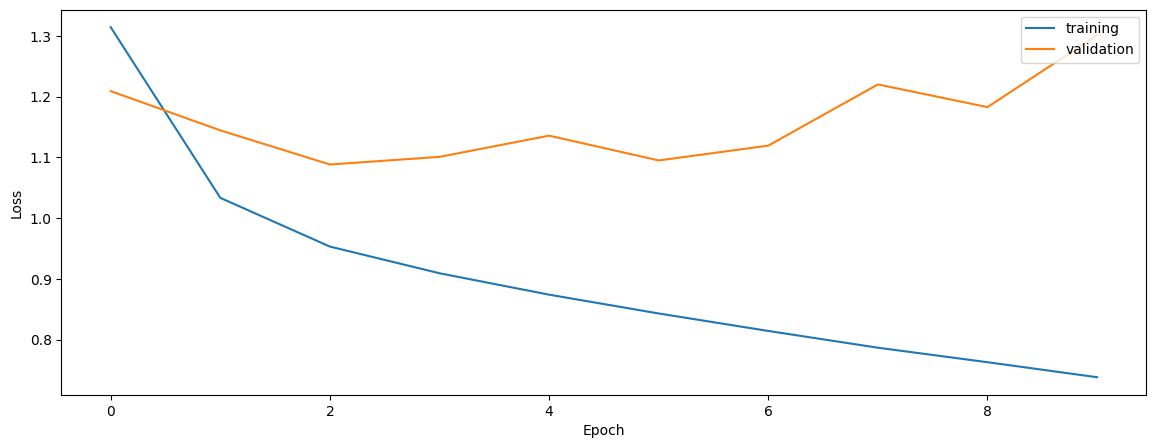

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6361995811496612
0.5691741163437758
0.6254192643990117


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5872647616285693
0.566075379266751
0.5488330232181863


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5842710985631024
0.5744482058226134
0.5581302658237658


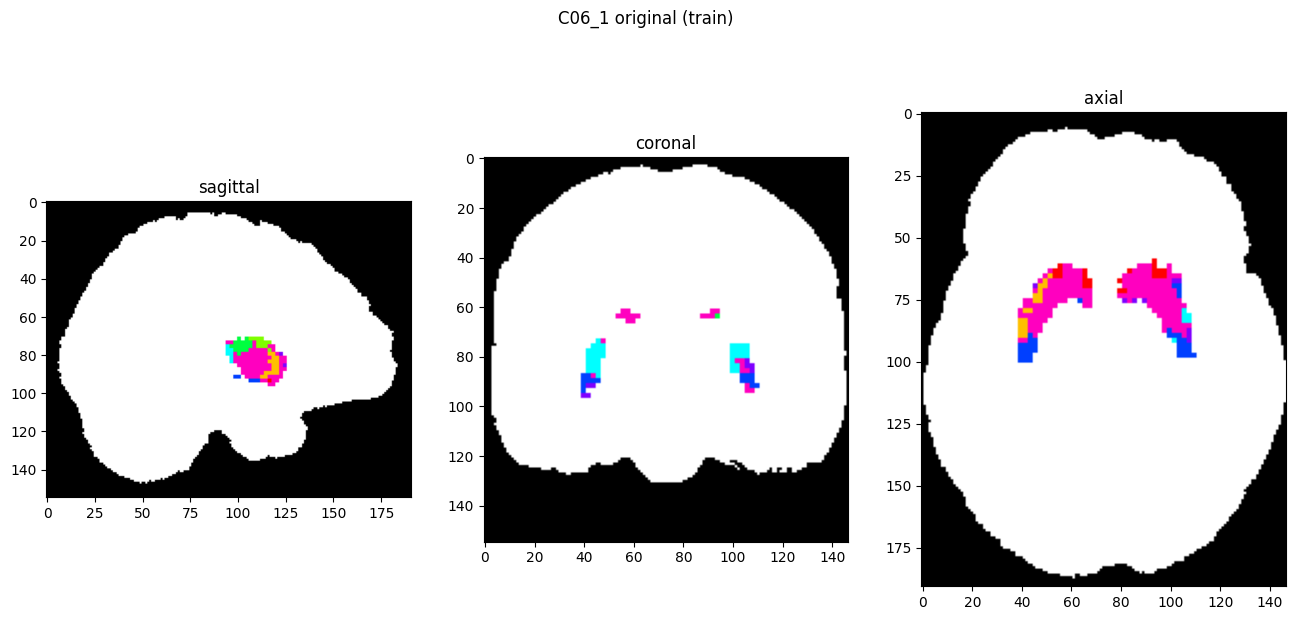

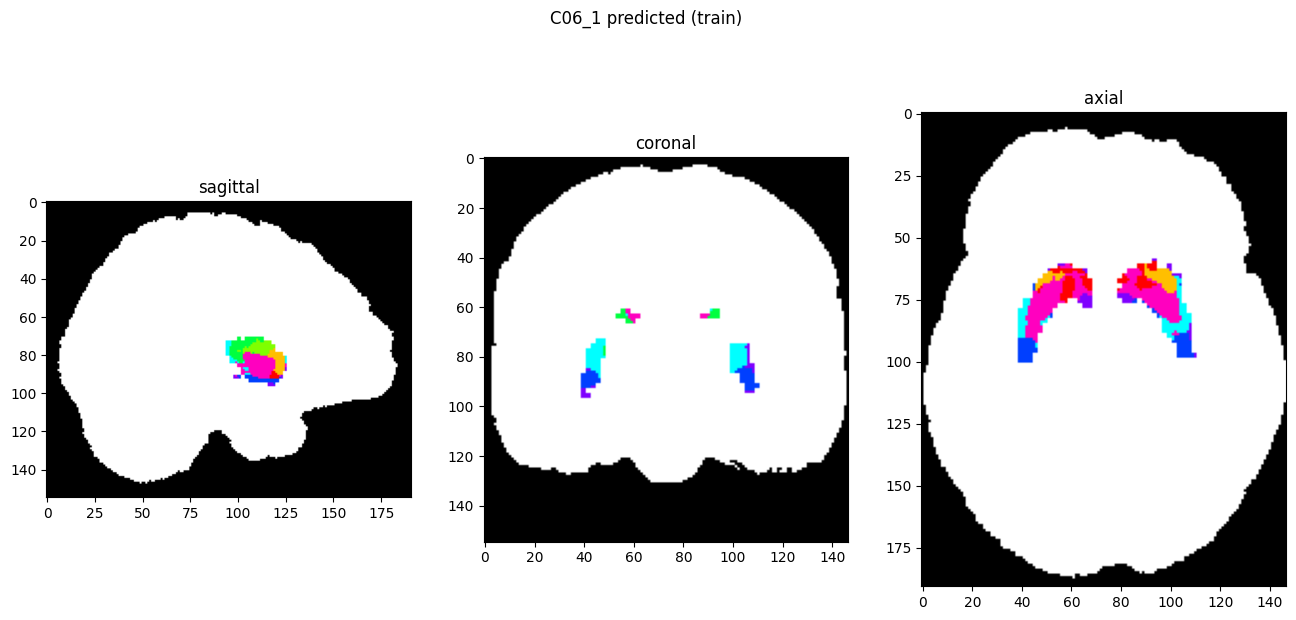

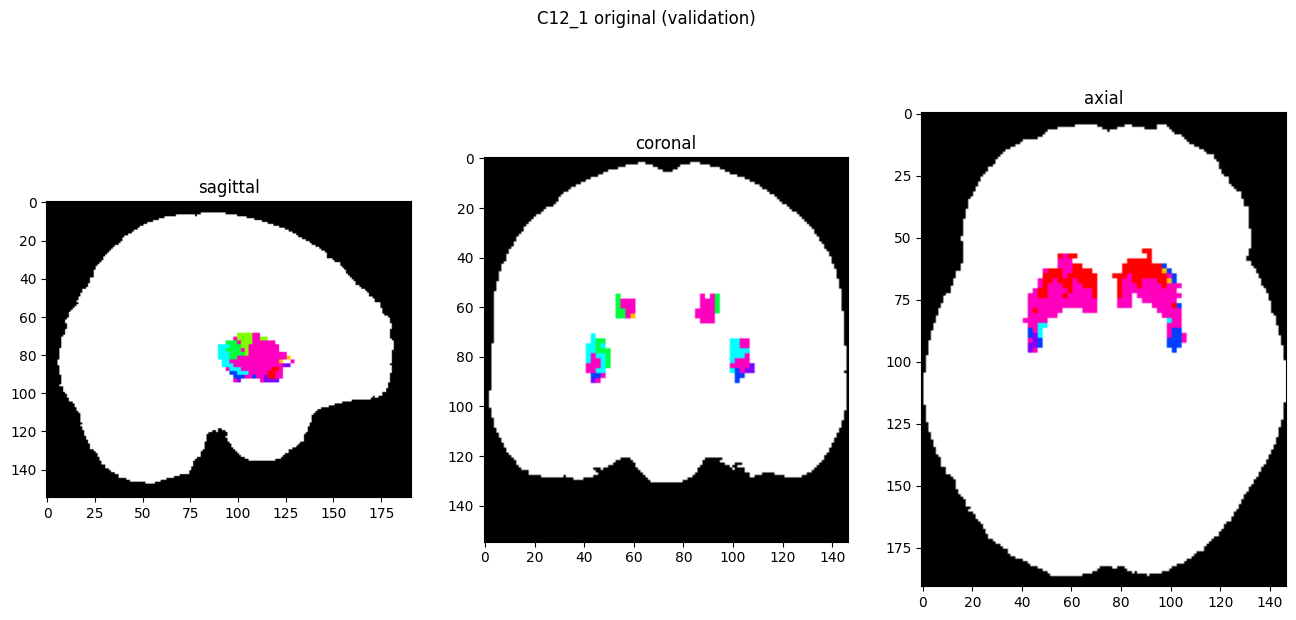

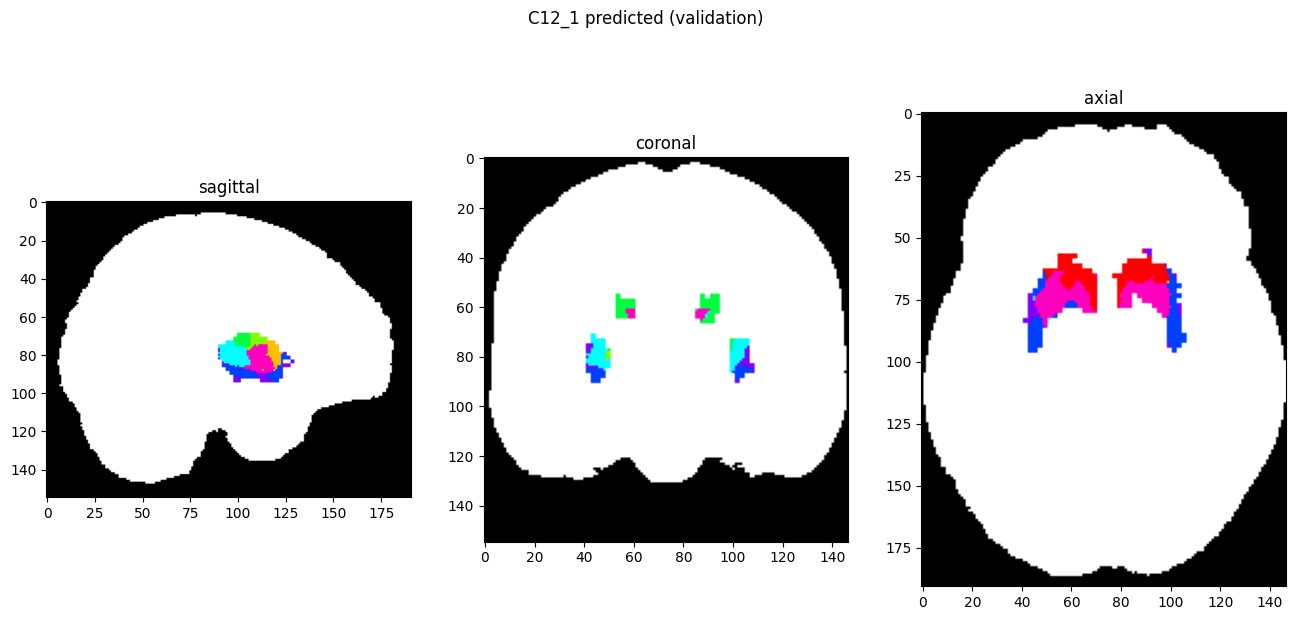

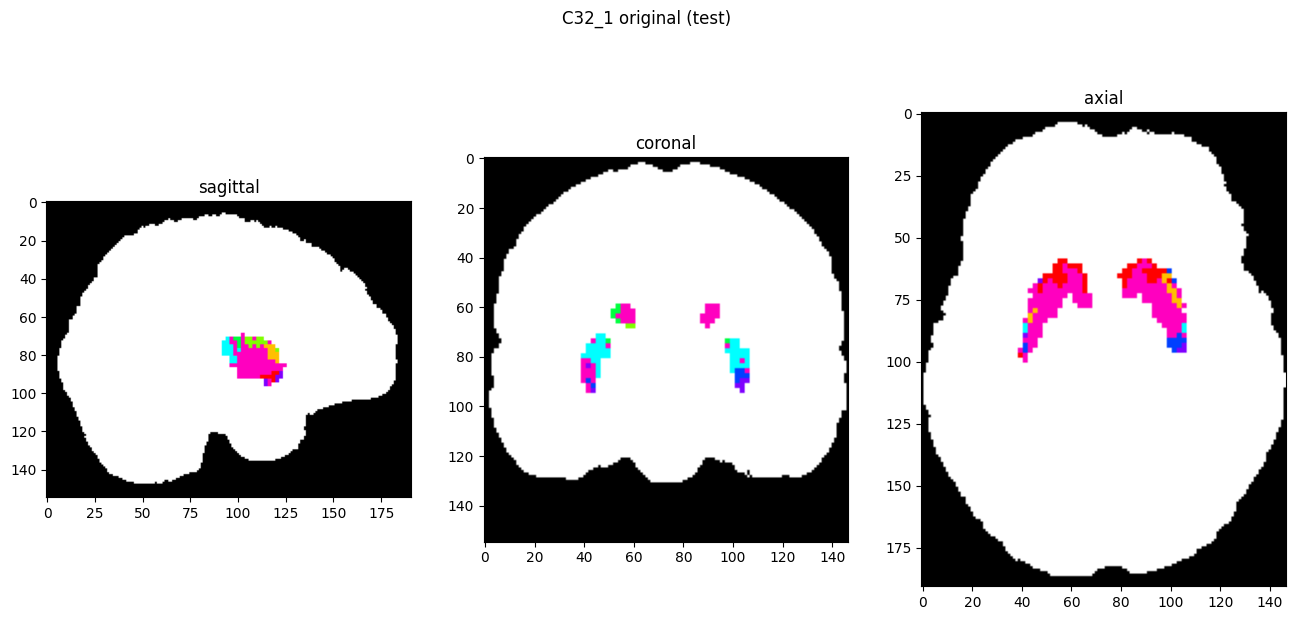

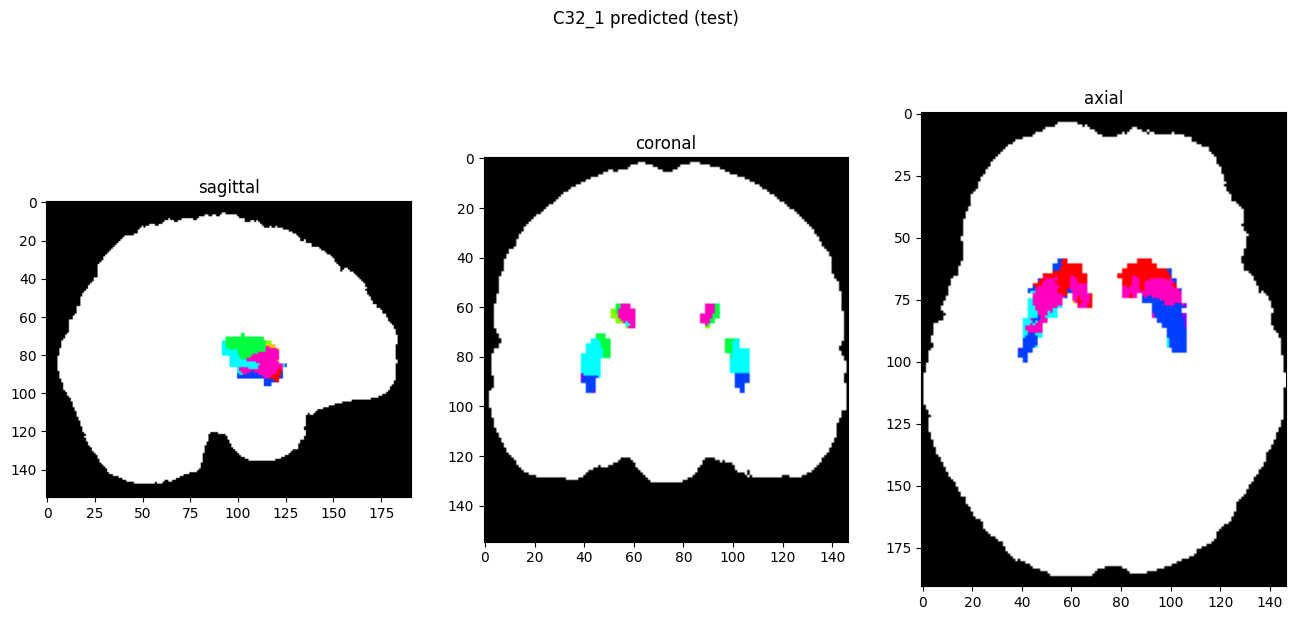

In [10]:
showResults(model, gen, threshold=0)